In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import os

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms

# import local packages
from utils import data_utils, training_utils
from utils.training_utils import train_model, test_model
from models.dense_convtranspose1d import DenseConvTranspose1D
import Simple_RCWA

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
pi = np.pi

# ================= Unit Define
meters = 1
centimeters = 1e-2 * meters
millimeters = 1e-3 * meters
micrometres = 1e-6 * meters

# ================= Constant Define
c0 = 3e8
e0 = 8.85e-12
u0 = 1.256e-6
yeta0 = np.sqrt(u0/e0)

# Visualize Target Spectra

freq_true.shape (1003,)
R_true.shape (201,)


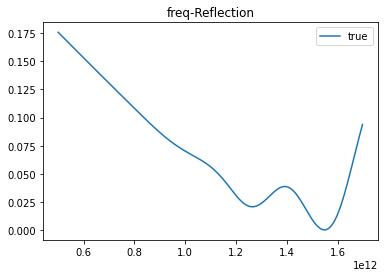

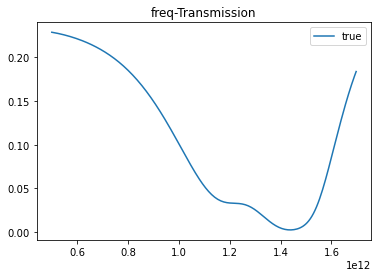

1098
(222,)
idx_freq_tg1 ORIG: 151
idx_freq_tg1: 166.77611940298507
R_tg1: 0.038314723405216806
T_tg1: 0.004280525157849011
T_tg2: 0.22840801357720697
--------
idx_freq_tg2 ORIG: 117
idx_freq_tg2: 129.22388059701493
R_tg2: 0.03066116289643781


In [4]:
path_true_R = './Simple_RCWA/data/R_absorber.txt'
R_file = Simple_RCWA.utils.data_utils.load_property_txt(path_true_R)
freq_true = R_file[:, 0] * 1e12
R_true = R_file[:, 1]
R_true = R_true**2
print('freq_true.shape', freq_true.shape)
# print(R_true)

path_true_T = './Simple_RCWA/data/T_absorber.txt'
T_file = Simple_RCWA.utils.data_utils.load_property_txt(path_true_T)
T_true = T_file[:, 1]
T_true = T_true**2

# truncate freq
freq_truncate = 1.7  # in THz
N_freq_stop = np.argmax(R_file[:,0]>freq_truncate)
freq_true = freq_true[:N_freq_stop]
R_true = R_true[:N_freq_stop]
T_true = T_true[:N_freq_stop]
freq_step = 4
freq_true, R_true, T_true = freq_true[::freq_step], R_true[::freq_step], T_true[::freq_step]
print('R_true.shape', R_true.shape)

plt.figure(1)
plt.plot(freq_true, R_true, label='true')
plt.title('freq-Reflection')
plt.legend()

plt.figure(2)
plt.plot(freq_true, T_true, label='true')
plt.title('freq-Transmission')
plt.legend()
plt.show()

# ================= Material Property Define
path_absorber = './Simple_RCWA/material_property/permittivity_absorber.txt'
eps_absorber_file = Simple_RCWA.utils.data_utils.load_property_txt(path_absorber)
print(eps_absorber_file.shape[0])
# truncate freq over 1.7THz
# freq_truncate = 1.7  # in THz
# freq_step = 4
if freq_truncate != 'none' and freq_truncate>eps_absorber_file[0,0] and freq_truncate<eps_absorber_file[-1,0]:
    N_freq_stop = np.argmax(eps_absorber_file[:,0]>freq_truncate)
    eps_absorber_file = eps_absorber_file[:N_freq_stop]
eps_absorber_file = eps_absorber_file[::freq_step]  # solve rcwa with a step size
eps_absorber = eps_absorber_file[:,1] + eps_absorber_file[:,2]*1j

freq = eps_absorber_file[:,0]*1e12
print(freq.shape)


# ================== Get Target Spectra Value
# print(freq_true)
idx_freq_tg1 = np.min(np.argwhere(freq_true>=1.4*1e12))
print('idx_freq_tg1 ORIG:', idx_freq_tg1)
R_tg1 = R_true[idx_freq_tg1]
T_tg1 = T_true[idx_freq_tg1]
T_tg2 = T_true[0]

idx_freq_tg1 = idx_freq_tg1/201*222
print('idx_freq_tg1:', idx_freq_tg1)
print('R_tg1:', R_tg1)
print('T_tg1:', T_tg1)
print('T_tg2:', T_tg2)


print('--------')
idx_freq_tg2 = np.min(np.argwhere(freq_true>=1.2*1e12))
print('idx_freq_tg2 ORIG:', idx_freq_tg2)
R_tg2 = R_true[idx_freq_tg2]

idx_freq_tg2 = idx_freq_tg2/201*222
print('idx_freq_tg2:', idx_freq_tg2)
print('R_tg2:', R_tg2)

# Looping to generate data and training

In [5]:
def visualize_trained_net(dataloader_test, size_fig=(21,12)):
    for idx, data in enumerate(dataloader_test):
        X, y = data
        X = X.to(device)
        y = y.to(device)
        y_pred = net_dense(X)  # [N_eg,2,N_freq]

        y_np = y.cpu().detach().numpy()
        y_pred_np = y_pred.cpu().detach().numpy()
        if idx==0:
            y_test_np = y_np
            y_test_pred_np = y_pred_np
        else:
            y_test_np = np.concatenate((y_test_np,y_np), axis=0)
            y_test_pred_np = np.concatenate((y_test_pred_np,y_pred_np), axis=0)
            
        if y_test_pred_np.shape[0]>=4:
            break
    print('y_test_np.shape:', y_test_np.shape)
    print('y_test_pred_np.shape:', y_test_pred_np.shape)

    fig1 = plt.figure(1, figsize=size_fig)
    fig1.suptitle('Training result on test set: freq-R')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(y_test_np.shape[2]), y_test_np[idx_fig,0,:], c='r')
        plt.scatter(np.arange(y_test_pred_np.shape[2]), y_test_pred_np[idx_fig,0,:], c='b')
        plt.legend(('true', 'prediction'))
        plt.title('sample idx: '+str(idx_fig))

    fig2 = plt.figure(2, figsize=size_fig)
    fig2.suptitle('Training result on test set: freq-T')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(y_test_np.shape[2]), y_test_np[idx_fig,1,:], c='r')
        plt.scatter(np.arange(y_test_pred_np.shape[2]), y_test_pred_np[idx_fig,1,:], c='b')
        plt.legend(('true', 'prediction'))
        plt.title('sample idx: '+str(idx_fig))
    plt.show()
    
    
def visualize_spectra_search(params_pick, R_pick, T_pick, size_fig=(21,12)):
    fig1 = plt.figure(1, figsize=size_fig)
    fig1.suptitle('Spectra search result: freq-R')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(R_pick.shape[1]), R_pick[idx_fig,:], c='r')
        plt.title(str(idx_fig+1) + 'th best match')

    fig2 = plt.figure(2, figsize=size_fig)
    fig2.suptitle('Spectra search result: freq-T')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(T_pick.shape[1]), T_pick[idx_fig,:], c='r')
        plt.title(str(idx_fig+1) + 'th best match')
    plt.show()
    
    
def visualize_learned_and_rcwa(param_pick, R_pick, T_pick, R_simu, T_simu, size_fig=(21,12)):
    fig1 = plt.figure(1, figsize=size_fig)
    fig1.suptitle('Spectra of learned network and RCWA: freq-R')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(R_pick.shape[1]), R_pick[idx_fig,:], c='r')
        plt.scatter(np.arange(R_simu.shape[1]), R_simu[idx_fig,:], c='b')
        plt.legend(('learned spectra', 'RCWA spectra'))
        plt.title(str(idx_fig+1) + 'th best match')

    fig2 = plt.figure(2, figsize=size_fig)
    fig2.suptitle('Spectra of learned network and RCWA: freq-T')
    for idx_fig in range(4):
        plt.subplot(2, 2, idx_fig+1)
        plt.scatter(np.arange(T_pick.shape[1]), T_pick[idx_fig,:], c='r')
        plt.scatter(np.arange(T_simu.shape[1]), T_simu[idx_fig,:], c='b')
        plt.legend(('learned spectra', 'RCWA spectra'))
        plt.title(str(idx_fig+1) + 'th best match')
    plt.show()

**************************** ROUND 1 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 200
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [131.  76.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [ 64. 125.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [78. 79.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [55. 79.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [59. 73.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [ 54. 111.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [ 78. 106.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [ 78. 113.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [84. 64.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [ 60. 112.]
Calculation Progress: 100%
-------

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [146.  69.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [53. 85.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [ 64. 134.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [137.  52.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [84. 71.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [120.  93.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [105.  89.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [145.  68.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [133. 131.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [128.  90.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [ 61. 133.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [ 62. 140.]
Calculation Progress: 100%
-----

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 0.0013180663765160717
### TEST LOSS  0.0009003225713968277
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 0.0005527571387210628
### TEST LOSS  0.00016412105954562625
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 0.0004135431253871502
### TEST LOSS  0.0005647024760643641
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 0.0003473401412975363
### TEST LOSS  0.00016108506436770162
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 0.000240782411165128
### TEST LOSS  0.00023743226726461822
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 0.0001850397217185673
### TEST LOSS  7.610395793259765e-05
----------------------------------------------------------------------
***

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 2.9046125672493873e-06
### TEST LOSS  3.039331507655637e-06
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 3.5948794766227367e-06
### TEST LOSS  2.023850811383454e-06
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 2.452685757674544e-06
### TEST LOSS  3.178672083474036e-06
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 3.3857590796060323e-06
### TEST LOSS  1.991923378833841e-06
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 2.836456928747566e-06
### TEST LOSS  2.7684936867444776e-06
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 3.0325184394541793e-06
### TEST LOSS  1.880541996494382e-06
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 1.0459590070865944e-06
### TEST LOSS  7.96149909850404e-07
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 8.298411659524164e-07
### TEST LOSS  7.072498154532999e-07
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 9.71724706246846e-07
### TEST LOSS  1.082564305458315e-06
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 7.606559557160608e-07
### TEST LOSS  5.840337280460517e-07
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 6.753367772915908e-07
### TEST LOSS  7.444003244927444e-07
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 9.951473360558794e-07
### TEST LOSS  1.1356015268878157e-06
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 7.2324854944128e-07
### TEST LOSS  1.4546867911728138e-06
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 7.057165438340008e-07
### TEST LOSS  6.425190501128478e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 5.597214056507483e-07
### TEST LOSS  5.212850548256635e-07
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 5.617440453065114e-07
### TEST LOSS  3.711756543604376e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 4.850389286659152e-07
### TEST LOSS  3.4553513235853944e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 5.372161052719093e-07
### TEST LOSS  4.565494672685115e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 3.3839817554337514e-07
### TEST LOSS  2.559579096820623e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 3.2581420924771007e-07
### TEST LOSS  6.762813882232876e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 3.623692041543336e-07
### TEST LOSS  3.385833243404098e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 3.418516656594761e-07
### TEST LOSS  2.7095916266262066e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 4.389107643376633e-07
### TEST LOSS  6.777298343270862e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 5.108903242145857e-07
### TEST LOSS  3.03815473519838e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 3.7449779835441175e-07
### TEST LOSS  2.930783011834137e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 4.073105481339212e-07
### TEST LOSS  5.118512926098143e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 6.939478817713507e-07
### TEST LOSS  9.546600570805215e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 5.109636281375174e-07
### TEST LOSS  4.1003364496342937e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 3.6465711438893323e-07
### TEST LOSS  5.810190183789624e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 3.751758199044275e-07
### TEST LOSS  1.9001682005637122e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 3.011053602719471e-07
### TEST LOSS  5.158653569499924e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 3.1409218063771506e-07
### TEST LOSS  2.508851177177955e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 4.583393975821082e-07
### TEST LOSS  5.166876254255234e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 7.190925502698065e-07
### TEST LOSS  5.056643601619726e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 4.547639306196061e-07
### TEST LOSS  4.595567683433425e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 4.7553018355017686e-07
### TEST LOSS  4.3314568642927043e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 2.5566942465360396e-07
### TEST LOSS  1.976736712094862e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 2.1850532395006894e-07
### TEST LOSS  1.4684953460649316e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 2.7577892025121287e-07
### TEST LOSS  2.702254514967232e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 2.3244687742618452e-07
### TEST LOSS  2.1433431622123558e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 2.5430403569615125e-07
### TEST LOSS  3.1400428686841525e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 2.5172970554265815e-07
### TEST LOSS  2.055761001429346e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 2.72147799424971e-07
### TEST LOSS  2.981246041144914e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 2.5325944143617106e-07
### TEST LOSS  2.2132093135951436e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 2.5922112891763047e-07
### TEST LOSS  1.5270790261941633e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 2.019484839443919e-07
### TEST LOSS  3.3127360173542303e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 2.10676933765086e-07
### TEST LOSS  1.4372561925786917e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 2.549474465673995e-07
### TEST LOSS  3.069164809706611e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 1.7225782988461447e-07
### TEST LOSS  1.5627304132218947e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 2.280298418178006e-07
### TEST LOSS  4.7292512779980217e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 5.622052042220104e-07
### TEST LOSS  2.5538354956703796e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 3.036484779528337e-07
### TEST LOSS  4.135773300125341e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 2.444105099641547e-07
### TEST LOSS  1.253150330171593e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 2.8958325001937626e-07
### TEST LOSS  1.7169930780861856e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 1.5273154046369087e-07
### TEST LOSS  9.450872321773811e-08
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 1.7660577309897007e-07
### TEST LOSS  1.1224012534209275e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 1.6277569825362548e-07
### TEST LOSS  1.9629142400390265e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 1.3483417969695212e-07
### TEST LOSS  1.3535419185473074e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 1.5435764948890097e-07
### TEST LOSS  1.3721322507838826e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 1.707529462180446e-07
### TEST LOSS  1.0805937951848439e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 2.081438666401425e-07
### TEST LOSS  1.2701446413151038e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 2.4263019126280484e-07
### TEST LOSS  1.1115738137353522e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 1.5006896845193296e-07
### TEST LOSS  1.3861279057891807e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 1.4519134769130915e-07
### TEST LOSS  3.0897913916305697e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 1.7566749642483616e-07
### TEST LOSS  2.2173047398155177e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 3.387243422281472e-07
### TEST LOSS  2.336766016242109e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 2.393133457090357e-07
### TEST LOSS  9.89093654387337e-08
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 2.471438141959936e-07
### TEST LOSS  1.0793645799367368e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 1.364721159013982e-07
### TEST LOSS  1.354603635187838e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 1.6373911361000636e-07
### TEST LOSS  1.6087588268950034e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 2.218264920461621e-07
### TEST LOSS  2.101936663242062e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 1.9352103622694017e-07
### TEST LOSS  1.5793900824216203e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 1.334702987598746e-07
### TEST LOSS  1.4692326052075563e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 1.5594924419382038e-07
### TEST LOSS  1.1260253766446719e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 1.87948994518905e-07
### TEST LOSS  1.8265444623466465e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 2.1115298981300157e-07
### TEST LOSS  1.9993700088131541e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 1.6540773435380628e-07
### TEST LOSS  2.085737046778983e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 2.3992010166118406e-07
### TEST LOSS  2.1885901920389492e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 1.4162865377365108e-07
### TEST LOSS  3.3776754548853205e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 2.3302278024495137e-07
### TEST LOSS  2.165515127217077e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 2.00665579157544e-07
### TEST LOSS  4.180799730117239e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 1.635344052886012e-07
### TEST LOSS  1.0792988073641634e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 1.4923759415808037e-07
### TEST LOSS  2.572854545708954e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 2.588326326424806e-07
### TEST LOSS  1.6245570103971355e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 1.490403052084588e-07
### TEST LOSS  1.2500930068881644e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 1.5412172968076732e-07
### TEST LOSS  1.2423707100121342e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 1.331404418625226e-07
### TEST LOSS  7.876819789013705e-08
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 1.0984488323373398e-07
### TEST LOSS  1.439640016087651e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 1.4059746549222042e-07
### TEST LOSS  2.546950857625537e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 1.7942806445958581e-07
### TEST LOSS  1.236198580537954e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 1.5281930895838514e-07
### TEST LOSS  1.7582418128843832e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 1.4001268599628248e-07
### TEST LOSS  1.1296801479450853e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 1.0619777474296654e-07
### TEST LOSS  7.57511765906808e-08
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 1.0831350948592444e-07
### TEST LOSS  3.9512582361567183e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 2.466527493005799e-07
### TEST LOSS  2.116135107144146e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 1.7950645583297842e-07
### TEST LOSS  3.1538379137903877e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 2.5782943669838686e-07
### TEST LOSS  2.395527095207702e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 1.7342919691465398e-07
### TEST LOSS  1.7067194827783774e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 1.1129400265375011e-07
### TEST LOSS  9.035969839032987e-08
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 1.351463118570706e-07
### TEST LOSS  1.5856560272216788e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 1.1662425423608625e-07
### TEST LOSS  1.3971744768544644e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 1.0684603881649935e-07
### TEST LOSS  2.35118548630453e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 1.967815733916467e-07
### TEST LOSS  7.888353792395719e-08
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 1.2275396415795115e-07
### TEST LOSS  1.2632858907106007e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 9.598415220857248e-08
### TEST LOSS  6.261036962958617e-08
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 1.8540697269919803e-07
### TEST LOSS  1.0695398107903505e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 1.0497505210871339e-07
### TEST LOSS  1.2784106218077795e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 9.947140884314365e-08
### TEST LOSS  9.923768828912216e-08
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 1.224422647272405e-07
### TEST LOSS  1.073249886000364e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 9.916288881584023e-08
### TEST LOSS  2.6271210155452235e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 1.1083579263271303e-07
### TEST LOSS  1.0340734490910108e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 1.2906826650116442e-07
### TEST LOSS  1.2438381702395418e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 1.0984227850840966e-07
### TEST LOSS  7.086768268512363e-08
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 9.035796019851716e-08
### TEST LOSS  6.666430844385711e-08
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 1.2087636229729527e-07
### TEST LOSS  6.454153952025384e-08
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 1.2246449856867514e-07
### TEST LOSS  1.21350126391917e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 1.2789332209273142e-07
### TEST LOSS  5.69298942802258e-08
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 1.2116853547183838e-07
### TEST LOSS  1.2773388154604012e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 9.991547663901202e-08
### TEST LOSS  2.5527013273555593e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 1.978902927923798e-07
### TEST LOSS  1.3514365804212503e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1112 || AVG LOSS 1.0328042075791188e-07
### TEST LOSS  7.281439925084972e-08
----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 9.095060843122838e-08
### TEST LOSS  8.587596767029027e-08
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 9.933009231133383e-08
### TEST LOSS  5.589984416095225e-08
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 7.00503212591741e-08
### TEST LOSS  5.079255179415062e-08
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 9.651800076504457e-08
### TEST LOSS  1.6046781799635332e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 1.2492438120403903e-07
### TEST LOSS  8.249047075044776e-08
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1164 || AVG LOSS 1.7310282918181485e-07
### TEST LOSS  1.326414889035732e-07
----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 2.3355944151148833e-07
### TEST LOSS  1.1472837021149947e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 9.896644554530098e-08
### TEST LOSS  7.886398615634486e-08
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 1.016054226798957e-07
### TEST LOSS  7.4855904586002e-08
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 1.138182093018969e-07
### TEST LOSS  5.932628729018082e-08
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 9.735749554096173e-08
### TEST LOSS  5.779250263534171e-08
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 8.890130821725961e-08
### TEST LOSS  5.3151983555229286e-08
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 8.953137278666645e-08
### TEST LOSS  7.447854244446717e-08
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 7.288683988360134e-08
### TEST LOSS  8.150714592147779e-08
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 1.3678890056212368e-07
### TEST LOSS  8.649984314009392e-08
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 8.739187308925977e-08
### TEST LOSS  8.067146003061983e-08
----------------------------------------------------------------------
*** EPOCH 1222 || AVG LOSS 1.0662066808997394e-07
### TEST LOSS  1.7287800346821314e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 7.630496516419783e-08
### TEST LOSS  8.542646175631792e-08
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 1.1157220656698997e-07
### TEST LOSS  1.0734672410232331e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 7.369244778843153e-08
### TEST LOSS  5.012362554642399e-08
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 8.281527245301846e-08
### TEST LOSS  9.918119777315344e-08
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 9.870635922837323e-08
### TEST LOSS  1.1499180393078252e-07
----------------------------------------------------------------------
*** EPOCH 1274 || AVG LOSS 9.229720873360492e-08
### TEST LOSS  1.299570631848231e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 1.2211838384068586e-07
### TEST LOSS  8.969543567142561e-08
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 1.252697832399008e-07
### TEST LOSS  6.956019168076939e-08
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 8.596557208306876e-08
### TEST LOSS  7.720119536240115e-08
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 1.2299999307074928e-07
### TEST LOSS  5.3237934357260506e-08
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 7.214037100577997e-08
### TEST LOSS  4.345238124869866e-08
----------------------------------------------------------------------
*** EPOCH 1326 || AVG LOSS 7.134064199387779e-08
### TEST LOSS  4.2754835523813504e-08
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 1.0525002591244004e-07
### TEST LOSS  8.76424384917603e-08
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 1.146439039878544e-07
### TEST LOSS  7.162427806406413e-08
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 7.767126723123852e-08
### TEST LOSS  1.8796241363361332e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 9.762595619022818e-08
### TEST LOSS  1.3042503847297363e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 8.382807870965792e-08
### TEST LOSS  4.943899393576127e-08
----------------------------------------------------------------------
*** EPOCH 1378 || AVG LOSS 8.202056382522471e-08
### TEST LOSS  4.890509449258692e-08
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 9.365858384846604e-08
### TEST LOSS  1.1425292001376874e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 1.660862456098755e-07
### TEST LOSS  9.592518779300008e-08
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 1.0199264735888391e-07
### TEST LOSS  6.670973699366793e-08
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 1.3914762471145535e-07
### TEST LOSS  1.1227885465814325e-07
----------------------------------------------------------------------
*** EPOCH 1430 || AVG LOSS 8.53094580399727e-08
### TEST LOSS  8.984248722754273e-08
----------------------------------------------------------------------
*** EPOCH 1431 || AVG LOSS 1.0446026267985075e-07
### TEST LOSS  1.4288642565437235e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 7.012500016223556e-08
### TEST LOSS  9.704431154962852e-08
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 7.985622570760852e-08
### TEST LOSS  1.3293693731005382e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 7.675981537502708e-08
### TEST LOSS  4.840858380816826e-08
----------------------------------------------------------------------
*** EPOCH 1482 || AVG LOSS 1.0510387904005825e-07
### TEST LOSS  1.4474445464429664e-07
----------------------------------------------------------------------
*** EPOCH 1483 || AVG LOSS 1.4099346837603832e-07
### TEST LOSS  8.178821531146241e-08
----------------------------------------------------------------------
*** EPOCH 1484 || AVG LOSS 1.0639338493767525e-07
### TEST LOSS  8.466320622346757e-08
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 1.401432935654867e-07
### TEST LOSS  1.1379927874107428e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 8.28255395646238e-08
### TEST LOSS  1.102576400550485e-07
----------------------------------------------------------------------
*** EPOCH 1534 || AVG LOSS 9.867419459297366e-08
### TEST LOSS  6.350315118197614e-08
----------------------------------------------------------------------
*** EPOCH 1535 || AVG LOSS 8.256658770910974e-08
### TEST LOSS  5.5989543075914604e-08
----------------------------------------------------------------------
*** EPOCH 1536 || AVG LOSS 7.756967451033603e-08
### TEST LOSS  8.101537218863086e-08
----------------------------------------------------------------------
*** EPOCH 1537 || AVG LOSS 6.333211540532346e-08
### TEST LOSS  5.4420549844280686e-08
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 8.837967848673856e-08
### TEST LOSS  9.045015758601949e-08
----------------------------------------------------------------------
*** EPOCH 1586 || AVG LOSS 1.1030354145624699e-07
### TEST LOSS  4.879428180023145e-08
----------------------------------------------------------------------
*** EPOCH 1587 || AVG LOSS 8.721042811465907e-08
### TEST LOSS  1.2393698748761986e-07
----------------------------------------------------------------------
*** EPOCH 1588 || AVG LOSS 7.822597027917766e-08
### TEST LOSS  5.154957941992203e-08
----------------------------------------------------------------------
*** EPOCH 1589 || AVG LOSS 8.078411176448696e-08
### TEST LOSS  1.298970010073693e-07
----------------------------------------------------------------------
*** EPOCH 1590 || AVG LOSS 9.370177766143683e-08
### TEST LOSS  8.59255327630611e-08
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1638 || AVG LOSS 6.729245132230943e-08
### TEST LOSS  4.057492120068673e-08
----------------------------------------------------------------------
*** EPOCH 1639 || AVG LOSS 9.728030675226762e-08
### TEST LOSS  2.1735716397112506e-07
----------------------------------------------------------------------
*** EPOCH 1640 || AVG LOSS 1.1000134682248586e-07
### TEST LOSS  1.2581031683112087e-07
----------------------------------------------------------------------
*** EPOCH 1641 || AVG LOSS 8.949640921684931e-08
### TEST LOSS  8.187651682571111e-08
----------------------------------------------------------------------
*** EPOCH 1642 || AVG LOSS 8.552365375003035e-08
### TEST LOSS  4.7254390030578484e-08
----------------------------------------------------------------------
*** EPOCH 1643 || AVG LOSS 8.57556108435631e-08
### TEST LOSS  6.042204129623012e-08
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1691 || AVG LOSS 5.486598002590881e-08
### TEST LOSS  1.1901616403520165e-07
----------------------------------------------------------------------
*** EPOCH 1692 || AVG LOSS 6.655518300480168e-08
### TEST LOSS  5.3862911168304585e-08
----------------------------------------------------------------------
*** EPOCH 1693 || AVG LOSS 1.391054202759534e-07
### TEST LOSS  6.608520190335791e-08
----------------------------------------------------------------------
*** EPOCH 1694 || AVG LOSS 7.966005285631184e-08
### TEST LOSS  8.314426717485428e-08
----------------------------------------------------------------------
*** EPOCH 1695 || AVG LOSS 8.690524690990742e-08
### TEST LOSS  4.94806838465441e-08
----------------------------------------------------------------------
*** EPOCH 1696 || AVG LOSS 9.542077489488321e-08
### TEST LOSS  4.389800523085796e-08
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1744 || AVG LOSS 5.73855111341004e-08
### TEST LOSS  7.633839042379502e-08
----------------------------------------------------------------------
*** EPOCH 1745 || AVG LOSS 6.627642873624495e-08
### TEST LOSS  6.034003519062026e-08
----------------------------------------------------------------------
*** EPOCH 1746 || AVG LOSS 6.295626875818527e-08
### TEST LOSS  5.9924518088413e-08
----------------------------------------------------------------------
*** EPOCH 1747 || AVG LOSS 6.549665570343422e-08
### TEST LOSS  1.1513833679070255e-07
----------------------------------------------------------------------
*** EPOCH 1748 || AVG LOSS 7.037283688671181e-08
### TEST LOSS  5.200808672611856e-08
----------------------------------------------------------------------
*** EPOCH 1749 || AVG LOSS 6.542311302926151e-08
### TEST LOSS  5.40081555773971e-08
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1797 || AVG LOSS 7.935285868843067e-08
### TEST LOSS  5.657359144114101e-08
----------------------------------------------------------------------
*** EPOCH 1798 || AVG LOSS 8.043429266635372e-08
### TEST LOSS  7.431374389928654e-08
----------------------------------------------------------------------
*** EPOCH 1799 || AVG LOSS 6.295157035207665e-08
### TEST LOSS  5.9399524114193504e-08
----------------------------------------------------------------------
*** EPOCH 1800 || AVG LOSS 7.289920838093877e-08
### TEST LOSS  8.213226247259324e-08
----------------------------------------------------------------------
*** EPOCH 1801 || AVG LOSS 8.110547474071694e-08
### TEST LOSS  1.0134488566867124e-07
----------------------------------------------------------------------
*** EPOCH 1802 || AVG LOSS 7.933238427071388e-08
### TEST LOSS  4.5028698991700367e-08
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1850 || AVG LOSS 7.600388371997723e-08
### TEST LOSS  4.8853522116587556e-08
----------------------------------------------------------------------
*** EPOCH 1851 || AVG LOSS 1.0404629337656956e-07
### TEST LOSS  6.546535047391444e-08
----------------------------------------------------------------------
*** EPOCH 1852 || AVG LOSS 8.045389038979777e-08
### TEST LOSS  7.740699459191092e-08
----------------------------------------------------------------------
*** EPOCH 1853 || AVG LOSS 6.421678782952967e-08
### TEST LOSS  9.103547190155344e-08
----------------------------------------------------------------------
*** EPOCH 1854 || AVG LOSS 7.294300088389605e-08
### TEST LOSS  4.8206230710926924e-08
----------------------------------------------------------------------
*** EPOCH 1855 || AVG LOSS 7.47412228330191e-08
### TEST LOSS  4.33961488965906e-08
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1903 || AVG LOSS 5.526353590745714e-08
### TEST LOSS  6.535213969982578e-08
----------------------------------------------------------------------
*** EPOCH 1904 || AVG LOSS 7.241571386984447e-08
### TEST LOSS  4.6535827635807436e-08
----------------------------------------------------------------------
*** EPOCH 1905 || AVG LOSS 5.2951257103472924e-08
### TEST LOSS  4.643757023359285e-08
----------------------------------------------------------------------
*** EPOCH 1906 || AVG LOSS 5.814779329149644e-08
### TEST LOSS  7.470987857990015e-08
----------------------------------------------------------------------
*** EPOCH 1907 || AVG LOSS 6.71193123435998e-08
### TEST LOSS  4.4932768616945395e-08
----------------------------------------------------------------------
*** EPOCH 1908 || AVG LOSS 9.845307027411821e-08
### TEST LOSS  6.490073308403528e-08
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1956 || AVG LOSS 9.359974145972671e-08
### TEST LOSS  4.9284600104707956e-08
----------------------------------------------------------------------
*** EPOCH 1957 || AVG LOSS 6.194202126330595e-08
### TEST LOSS  4.66231947863586e-08
----------------------------------------------------------------------
*** EPOCH 1958 || AVG LOSS 8.43197982280941e-08
### TEST LOSS  7.981401021576555e-08
----------------------------------------------------------------------
*** EPOCH 1959 || AVG LOSS 1.4401608460001826e-07
### TEST LOSS  1.11385567436173e-07
----------------------------------------------------------------------
*** EPOCH 1960 || AVG LOSS 8.747996104396804e-08
### TEST LOSS  5.5927475983708064e-08
----------------------------------------------------------------------
*** EPOCH 1961 || AVG LOSS 6.492469683649916e-08
### TEST LOSS  4.598846103931464e-08
----------------------------------------------------------

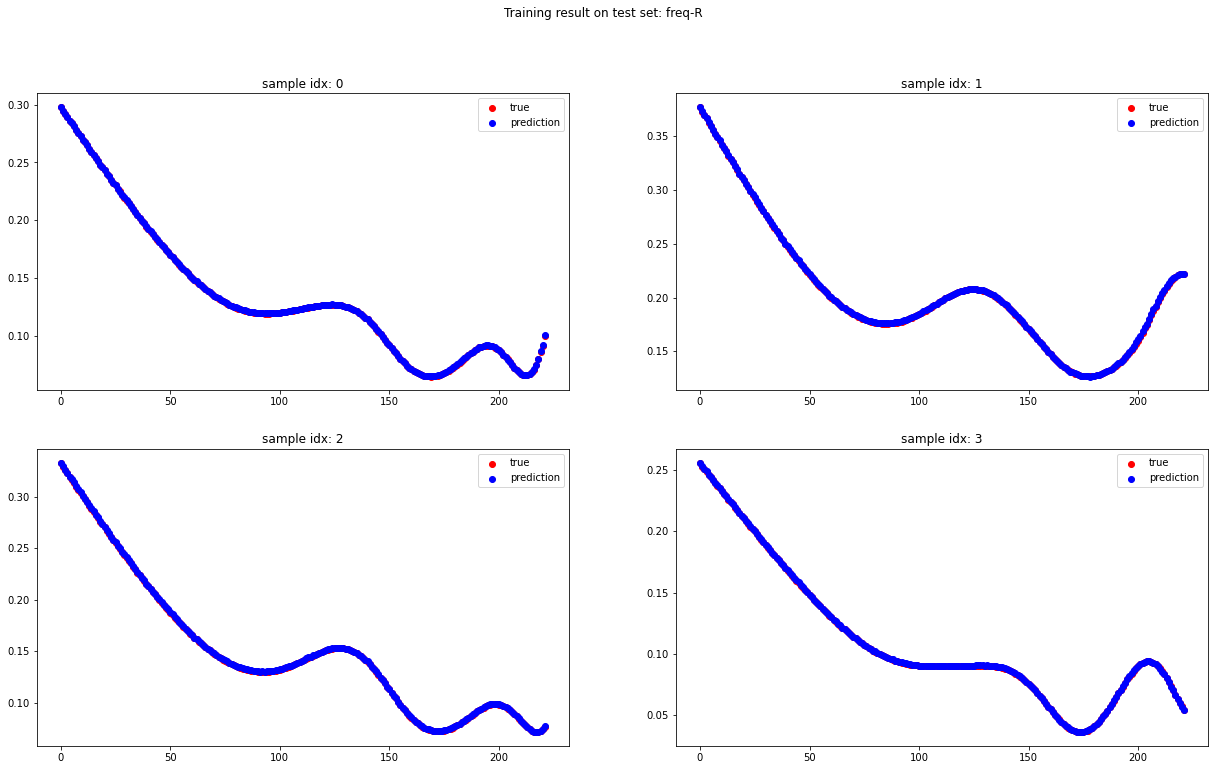

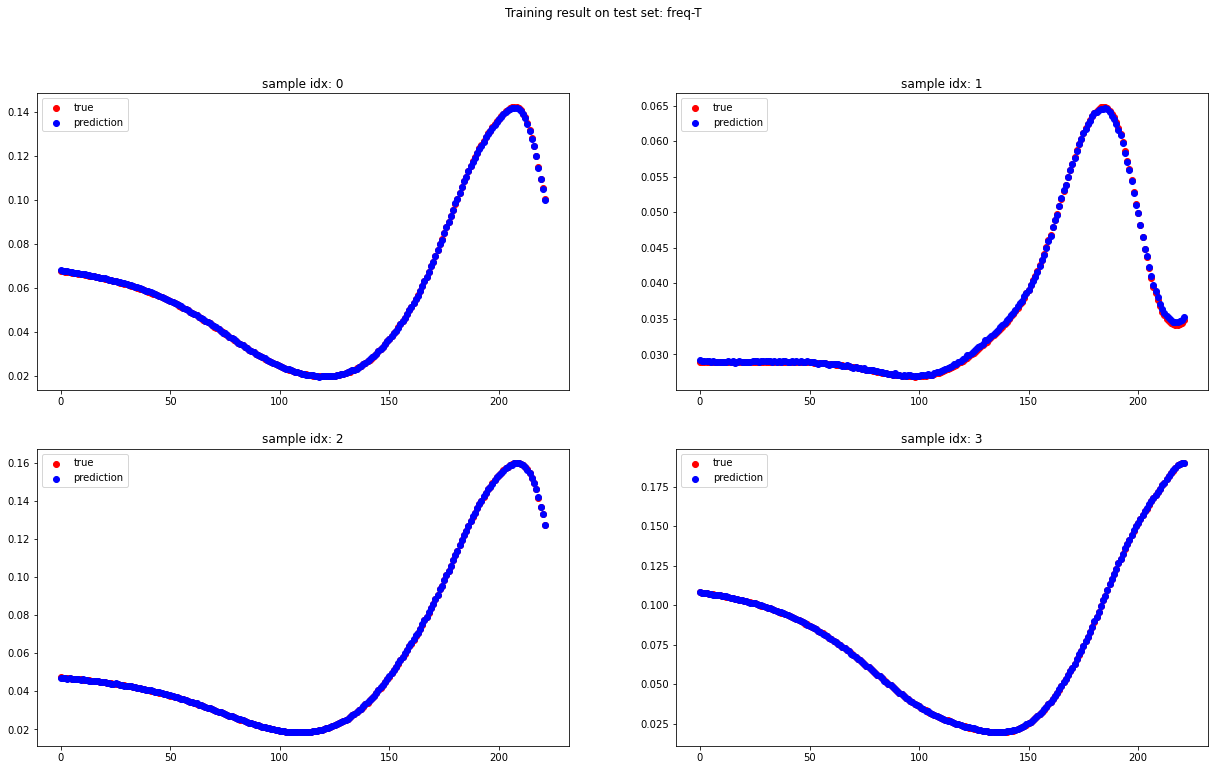

pseudo_params.shape: (10201, 4)
params_pick.shape: (10, 4)
params_pick: [[145. 122. 160.  75.]
 [145. 121. 160.  75.]
 [146. 121. 160.  75.]
 [146. 122. 160.  75.]
 [145. 123. 160.  75.]
 [146. 120. 160.  75.]
 [145. 120. 160.  75.]
 [144. 122. 160.  75.]
 [146. 123. 160.  75.]
 [144. 123. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


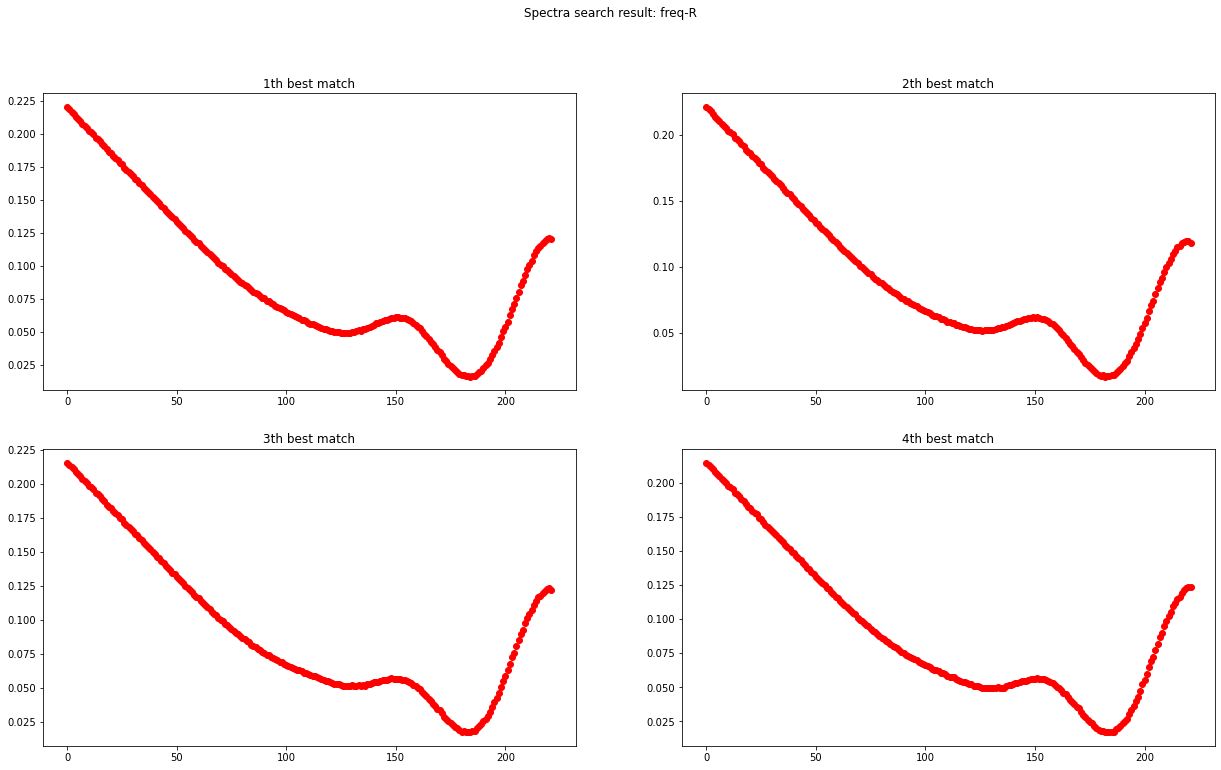

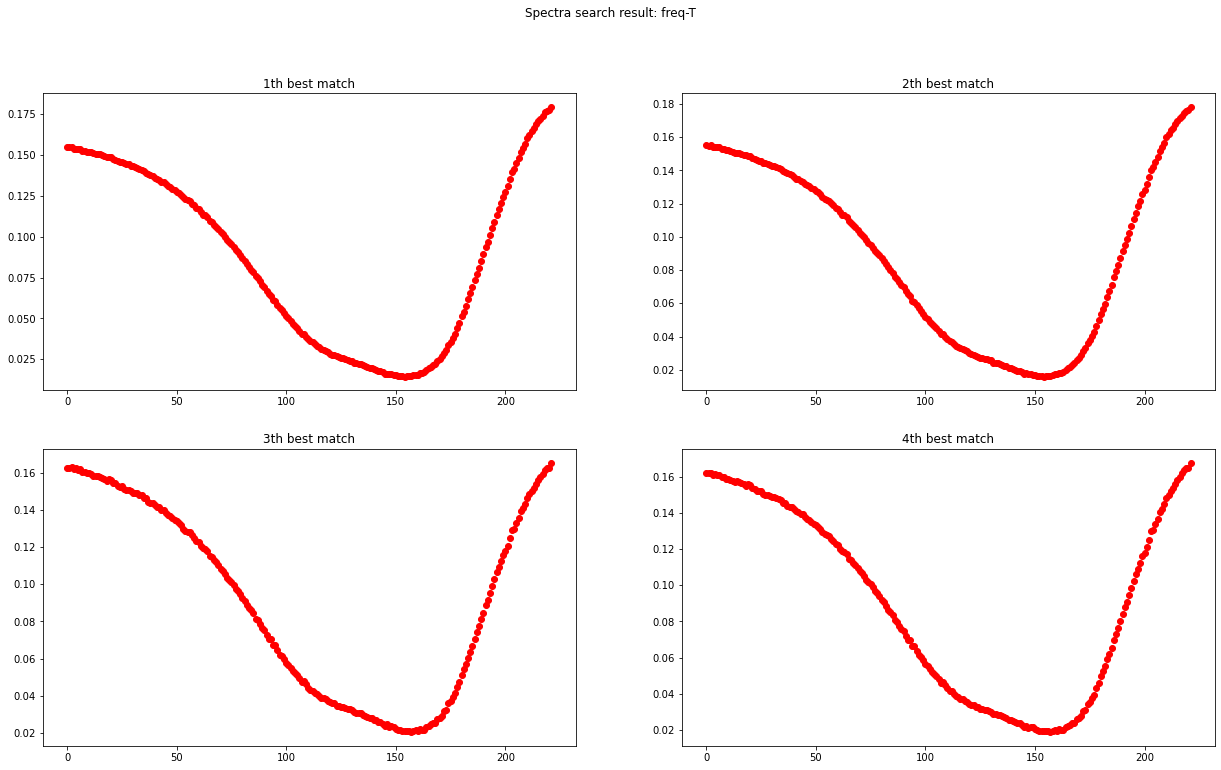

*** Reruning RCWA on picked params
params_dict.shape: (200, 4)
R_dict.shape: (200, 222)
T_dict.shape: (200, 222)
--------------------
1 th match
Not in the dict, calling RCWA...
# params_pick: [145. 122. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
2 th match
Not in the dict, calling RCWA...
# params_pick: [145. 121. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
3 th match
Not in the dict, calling RCWA...
# params_pick: [146. 121. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
4 th match
Not in the dict, calling RCWA...
# params_pick: [146. 122. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
5 th match
Not in the dict, calling RCWA...
# params_pick: [145. 123. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
6

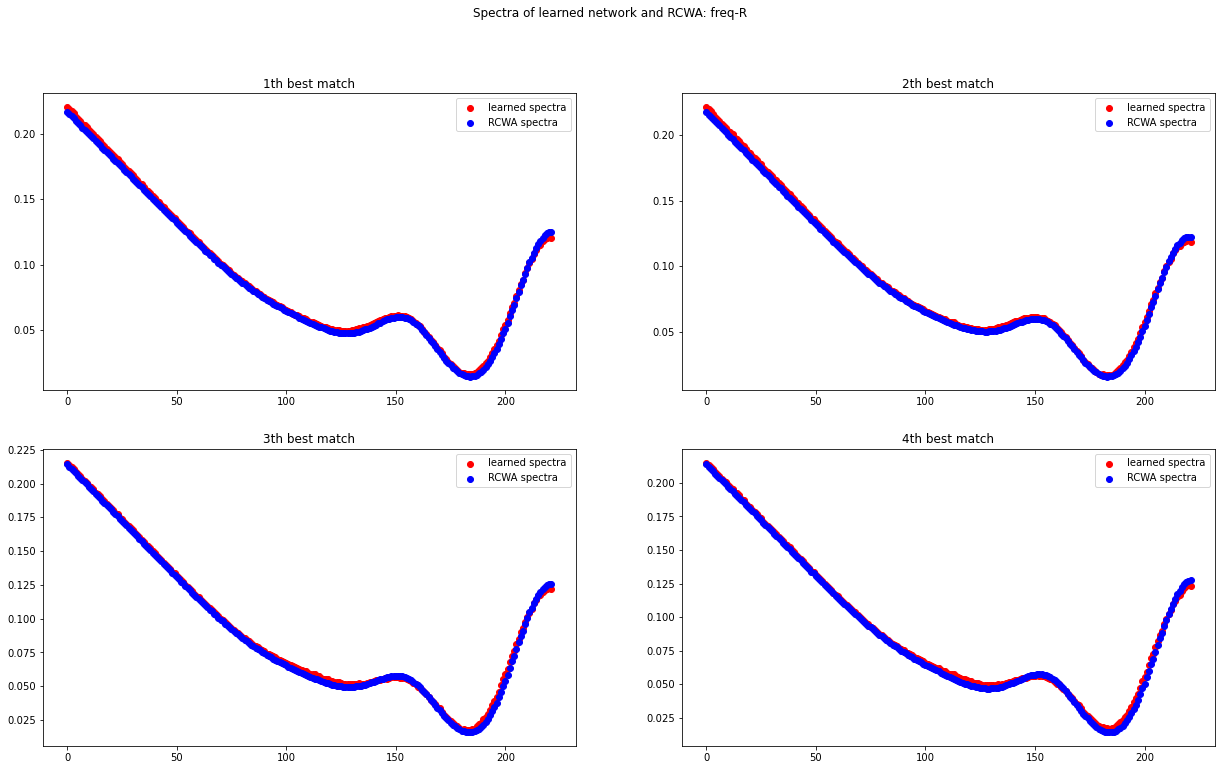

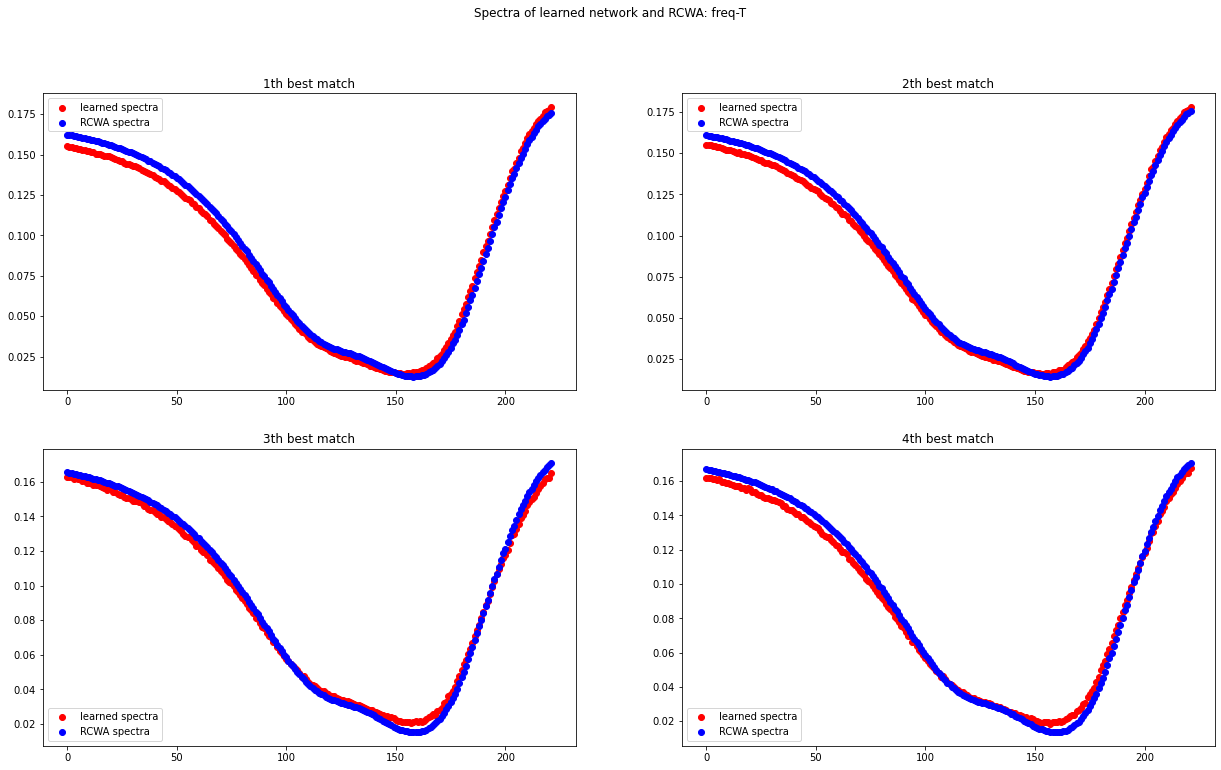

** Model saved.
**************************** ROUND 2 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 400
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [135.  73.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [ 56. 114.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [ 57. 103.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [119.  75.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [123. 124.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [109. 115.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [ 56. 119.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [97. 80.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [59. 96.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [148. 146.]
Calculation Pr

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [107. 119.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [121. 128.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [107.  89.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [ 56. 108.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [124.  63.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [140.  81.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [ 51. 108.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [123.  82.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [150. 119.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [ 81. 116.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [124.  57.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [77. 79.]
Calculation Progress: 100%
---

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 0.00039650964375482546
### TEST LOSS  0.0004021000349894166
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 0.00012837083919748694
### TEST LOSS  4.091684847177627e-05
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 4.1580970571430956e-05
### TEST LOSS  5.7907662873428e-05
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 2.970800165712717e-05
### TEST LOSS  3.0308572301388875e-05
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 5.0801768882706713e-05
### TEST LOSS  3.3187828194058966e-05
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 5.429334573705091e-05
### TEST LOSS  3.102149882276232e-05
----------------------------------------------------------------------
*

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 1.5855215103854902e-06
### TEST LOSS  1.3064273313527035e-06
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 1.6959433364149845e-06
### TEST LOSS  1.5991920273942621e-06
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 1.2169183574783914e-06
### TEST LOSS  9.949316108759376e-07
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 9.812955998000917e-07
### TEST LOSS  7.06611861763425e-07
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 1.0721818918568716e-06
### TEST LOSS  1.3744343239826169e-06
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 1.2746911271932503e-06
### TEST LOSS  8.005633276297885e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 8.485478011621694e-07
### TEST LOSS  7.509414103878953e-07
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 5.998736887313782e-07
### TEST LOSS  6.177104789154934e-07
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 7.042418699754193e-07
### TEST LOSS  4.784523686870065e-07
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 6.685157631203253e-07
### TEST LOSS  1.2771955842557265e-06
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 1.037919859800951e-06
### TEST LOSS  4.521491140015617e-07
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 6.489022088018715e-07
### TEST LOSS  1.5829116553807883e-06
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 5.406941554220168e-07
### TEST LOSS  3.072155863037551e-07
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 4.3048331241912765e-07
### TEST LOSS  4.6971286356741376e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 4.87311669070678e-07
### TEST LOSS  3.7854370778707863e-07
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 4.008297880453426e-07
### TEST LOSS  3.8383528533358913e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 5.557558264079887e-07
### TEST LOSS  4.846801147095903e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 4.6859085484740603e-07
### TEST LOSS  3.765900089547358e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 4.4592314701219494e-07
### TEST LOSS  2.371743311376425e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 4.247927274114716e-07
### TEST LOSS  4.16373339362508e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 4.862730405363891e-07
### TEST LOSS  3.9320479080136767e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 6.384348370147563e-07
### TEST LOSS  4.049341508031527e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 4.0908406126582977e-07
### TEST LOSS  4.166252978166085e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 3.7772732432106436e-07
### TEST LOSS  6.072234270959598e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 4.038481432644403e-07
### TEST LOSS  3.4482131165229174e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 4.0882745500958605e-07
### TEST LOSS  1.187645409572724e-06
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 4.093951794281736e-07
### TEST LOSS  4.1919009656036604e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 4.102508784153969e-07
### TEST LOSS  7.920018560980679e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 4.334835628583278e-07
### TEST LOSS  3.3292843681920203e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 2.664266647300906e-07
### TEST LOSS  3.7412237456161773e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 3.583890044200899e-07
### TEST LOSS  3.2778423530999135e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 3.102515164066233e-07
### TEST LOSS  2.7810492989980656e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 3.4038278601045136e-07
### TEST LOSS  2.762002845694648e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 4.129400799079974e-07
### TEST LOSS  2.9171224961525394e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 3.511154561852692e-07
### TEST LOSS  2.3591466676483228e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 3.7700586081435005e-07
### TEST LOSS  5.37385967428842e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 2.7169933625614817e-07
### TEST LOSS  3.5933513705307024e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 2.9657088771450903e-07
### TEST LOSS  3.2699392230976326e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 3.04621087128254e-07
### TEST LOSS  1.4821138449860882e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 2.931133991612711e-07
### TEST LOSS  3.775650867510194e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 3.8302890399855015e-07
### TEST LOSS  1.855689409543023e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 2.8974936552295103e-07
### TEST LOSS  1.5619525110347846e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 2.2718391358367283e-07
### TEST LOSS  1.625446988858433e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 2.111902245527375e-07
### TEST LOSS  3.2669263324199466e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 2.2509685020821735e-07
### TEST LOSS  2.0742260412968486e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 2.2968097606934635e-07
### TEST LOSS  2.3320699682471968e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 2.998648430452278e-07
### TEST LOSS  2.5021739939271964e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 3.941471218205095e-07
### TEST LOSS  5.611556635661449e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 2.2115361164587455e-07
### TEST LOSS  2.074187245663476e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 1.9928230878374365e-07
### TEST LOSS  2.467067166852151e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 2.2547149243656862e-07
### TEST LOSS  2.65086929592447e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 2.7642170695507674e-07
### TEST LOSS  1.692624517583378e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 3.769638297068667e-07
### TEST LOSS  2.112047852165233e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 2.2501224381521467e-07
### TEST LOSS  1.6699822443418574e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 2.221803581559101e-07
### TEST LOSS  1.7293578006653357e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 2.5562416885449577e-07
### TEST LOSS  2.1094404682268456e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 2.943486052142674e-07
### TEST LOSS  1.7888561861430693e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 2.447236387759233e-07
### TEST LOSS  1.58556697253213e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 2.0439234000413364e-07
### TEST LOSS  1.4560508532213134e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 2.247627794638163e-07
### TEST LOSS  1.5700381320963666e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 2.2297568266438362e-07
### TEST LOSS  1.957118603475768e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 4.035117978862246e-07
### TEST LOSS  2.741863530294116e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 3.526305773160487e-07
### TEST LOSS  2.4155845560850747e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 2.5918994777107686e-07
### TEST LOSS  2.3437188427048264e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 2.4082861321605975e-07
### TEST LOSS  1.8403921823543593e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 2.0725890430561834e-07
### TEST LOSS  2.6453195071477847e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 2.644776119176129e-07
### TEST LOSS  1.5203826109200236e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 2.2029323616834519e-07
### TEST LOSS  1.2567377657054143e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 1.8533205274451346e-07
### TEST LOSS  2.296204423638907e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 2.455835831760567e-07
### TEST LOSS  1.9085557786032345e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 2.6681369249104135e-07
### TEST LOSS  2.1718828927911696e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 2.408651077523416e-07
### TEST LOSS  2.0202760471950873e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 1.8889745177386174e-07
### TEST LOSS  3.251320777053479e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 2.0500440248483187e-07
### TEST LOSS  1.1824081388075076e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 1.848979142016205e-07
### TEST LOSS  2.636773643871493e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 1.8513100028982875e-07
### TEST LOSS  1.400447982765248e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 2.3133441666267628e-07
### TEST LOSS  1.922538454361226e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 2.0155107380404047e-07
### TEST LOSS  3.56233025892531e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 2.314317373652841e-07
### TEST LOSS  1.1723917362852869e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 2.50833609851675e-07
### TEST LOSS  5.519329562275743e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 3.7442896277273264e-07
### TEST LOSS  6.318280251586353e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 2.4456171579423367e-07
### TEST LOSS  1.2798774899162405e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 2.0621161431311208e-07
### TEST LOSS  2.9652611980660976e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 1.8201347558033375e-07
### TEST LOSS  1.0275298478745754e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 2.0793904179861044e-07
### TEST LOSS  1.8915617753615757e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 1.6439348388352925e-07
### TEST LOSS  1.5941175490752357e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 2.172196172978147e-07
### TEST LOSS  1.283676240859677e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 1.6500545748865392e-07
### TEST LOSS  1.4633007102323367e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 2.8880686269161516e-07
### TEST LOSS  2.1581959449198015e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 2.3291211945775103e-07
### TEST LOSS  1.1955221997557905e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 2.754924948789039e-07
### TEST LOSS  1.3692248283329414e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 1.780508197057884e-07
### TEST LOSS  1.234134832846697e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 1.8563461386733594e-07
### TEST LOSS  1.4284115697667707e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 1.699836076829442e-07
### TEST LOSS  1.0880221168463322e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 1.5996970190723658e-07
### TEST LOSS  1.1219373400687498e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 1.7573328120690235e-07
### TEST LOSS  1.4116978282648537e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 1.797440253969995e-07
### TEST LOSS  1.7506382476994986e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 1.5673817709505045e-07
### TEST LOSS  1.2704897756066202e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 2.0324821805139949e-07
### TEST LOSS  2.647835538975111e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 1.7243105578934604e-07
### TEST LOSS  1.3938128162749308e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 2.3693173280658898e-07
### TEST LOSS  5.296098919416181e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 2.1802452100150304e-07
### TEST LOSS  2.1669941929758352e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 1.7336530130585004e-07
### TEST LOSS  2.784873226839106e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 2.1151461881085965e-07
### TEST LOSS  1.0240582900185775e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 1.3503096797595758e-07
### TEST LOSS  1.479383750317235e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 1.6984888101090335e-07
### TEST LOSS  1.7394801451094585e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 1.7538154640561742e-07
### TEST LOSS  1.185396977613588e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 1.6421639559283108e-07
### TEST LOSS  1.3288666877997457e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 1.4565139037969744e-07
### TEST LOSS  1.7877342865328197e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 1.4913575275610213e-07
### TEST LOSS  2.377604886305562e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 2.0577187461068293e-07
### TEST LOSS  1.4603530947473095e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 2.272707778416816e-07
### TEST LOSS  1.2335671802550982e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 1.826662558812586e-07
### TEST LOSS  2.587916583252081e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 1.7434744747024667e-07
### TEST LOSS  1.268076950111663e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 2.0704673114213535e-07
### TEST LOSS  3.460374244923514e-07
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 1.7496520282822558e-07
### TEST LOSS  1.0354845277523357e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 1.5970038276247321e-07
### TEST LOSS  1.83341415530928e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 1.471039812361852e-07
### TEST LOSS  1.2493865734578927e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 1.816348820993241e-07
### TEST LOSS  2.8078219334778015e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 1.792077960915961e-07
### TEST LOSS  1.4166262237343594e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1112 || AVG LOSS 1.668959231304612e-07
### TEST LOSS  1.3759320793838015e-07
----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 1.4641415652771882e-07
### TEST LOSS  1.8293397374691267e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 1.5650683168111357e-07
### TEST LOSS  1.2345215220458763e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 1.4627966309355146e-07
### TEST LOSS  1.1051452138606994e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 1.4540004374730132e-07
### TEST LOSS  9.756369105199762e-08
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 1.4991989136570183e-07
### TEST LOSS  2.200669560655418e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1164 || AVG LOSS 1.3268231334517823e-07
### TEST LOSS  1.6268331629968694e-07
----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 1.7918465772925884e-07
### TEST LOSS  2.2934011430682707e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 1.497710221842752e-07
### TEST LOSS  1.5709458267565424e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 2.324564091038539e-07
### TEST LOSS  1.1849452382269494e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 1.7959537956357963e-07
### TEST LOSS  1.2599523439386454e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 1.3097103888082273e-07
### TEST LOSS  1.1434574531676844e-07
------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1216 || AVG LOSS 1.305140172425112e-07
### TEST LOSS  1.1958531587197285e-07
----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 1.6071273861939517e-07
### TEST LOSS  2.3534436148035334e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 1.534151549043017e-07
### TEST LOSS  1.1816767771695898e-07
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 1.7534918081096862e-07
### TEST LOSS  8.701305039456504e-08
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 1.548246487992344e-07
### TEST LOSS  1.5103290706974803e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 1.4704545080235222e-07
### TEST LOSS  1.7269455080774301e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1268 || AVG LOSS 1.8892739642950573e-07
### TEST LOSS  8.394839904705502e-08
----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 1.0751949083953605e-07
### TEST LOSS  9.759026416607715e-08
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 1.8797788634117296e-07
### TEST LOSS  1.1089183260537538e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 1.4114252114394432e-07
### TEST LOSS  1.4445893251983458e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 1.471646837902796e-07
### TEST LOSS  1.230508601679503e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 1.536529983958701e-07
### TEST LOSS  2.1024179612065078e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1320 || AVG LOSS 1.276182290599337e-07
### TEST LOSS  9.55322304226532e-08
----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 1.404353029732519e-07
### TEST LOSS  1.9841239407014655e-07
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 1.5518196398556227e-07
### TEST LOSS  1.7311259862632747e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 1.753943540494518e-07
### TEST LOSS  1.4237850720633105e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 1.387256415519289e-07
### TEST LOSS  9.47233663358323e-08
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 1.3301879119520522e-07
### TEST LOSS  1.7363503464669824e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1372 || AVG LOSS 1.1917065371847002e-07
### TEST LOSS  6.975648917754522e-08
----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 1.3759769166288293e-07
### TEST LOSS  2.3912565912572364e-07
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 1.9378206487896675e-07
### TEST LOSS  9.162164715803556e-08
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 1.2199888175690176e-07
### TEST LOSS  1.24838958726059e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 1.4493992663844324e-07
### TEST LOSS  1.0353110013738842e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 1.5890007124763627e-07
### TEST LOSS  1.7269596478778718e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1424 || AVG LOSS 1.71591097992696e-07
### TEST LOSS  1.270590838468403e-07
----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 1.1695330140115701e-07
### TEST LOSS  8.254185956957372e-08
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 1.2005043160456807e-07
### TEST LOSS  7.590640412521073e-08
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 1.9115842824213304e-07
### TEST LOSS  1.6520988547578477e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 1.438989417645864e-07
### TEST LOSS  1.3805496597759279e-07
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 1.169605358719572e-07
### TEST LOSS  1.7837312545528525e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1476 || AVG LOSS 1.38023907210183e-07
### TEST LOSS  1.302191800315692e-07
----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 1.1554521202050694e-07
### TEST LOSS  1.0144688999957907e-07
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 1.0087578383277674e-07
### TEST LOSS  1.1967109851222327e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 1.213648146825008e-07
### TEST LOSS  1.2457908245740631e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 1.3049816176557983e-07
### TEST LOSS  1.256610460131924e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 1.220175364791132e-07
### TEST LOSS  1.5016749443930166e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1528 || AVG LOSS 1.325618198544376e-07
### TEST LOSS  2.1277876527392436e-07
----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 1.3259872113646765e-07
### TEST LOSS  4.2056932632779837e-07
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 1.525963243587114e-07
### TEST LOSS  7.899256478557011e-08
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 9.778046575537047e-08
### TEST LOSS  8.121739488350006e-08
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 1.32866645308205e-07
### TEST LOSS  8.115954841514395e-08
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 1.0943704342958327e-07
### TEST LOSS  6.783252063750449e-08
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1580 || AVG LOSS 1.399179900896108e-07
### TEST LOSS  1.8366687726256714e-07
----------------------------------------------------------------------
*** EPOCH 1581 || AVG LOSS 1.491260239228076e-07
### TEST LOSS  1.4388556005921296e-07
----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 1.697248242549243e-07
### TEST LOSS  1.0535444872061817e-07
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 1.5572540597474928e-07
### TEST LOSS  1.3362517137238683e-07
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 1.2477361385432318e-07
### TEST LOSS  1.2795087537635178e-07
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 1.4111533787719567e-07
### TEST LOSS  1.1246926708471013e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1632 || AVG LOSS 1.1867246690222544e-07
### TEST LOSS  2.0837569299677247e-07
----------------------------------------------------------------------
*** EPOCH 1633 || AVG LOSS 1.3317810617641257e-07
### TEST LOSS  1.1839748263279641e-07
----------------------------------------------------------------------
*** EPOCH 1634 || AVG LOSS 1.1900473907644482e-07
### TEST LOSS  1.241482531592434e-07
----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 1.1805868999736901e-07
### TEST LOSS  9.61085895312408e-08
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 1.2776280285287102e-07
### TEST LOSS  8.85011625465874e-08
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 1.404022174700259e-07
### TEST LOSS  1.6874824619132292e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1684 || AVG LOSS 1.2345955907155926e-07
### TEST LOSS  9.000509256414564e-08
----------------------------------------------------------------------
*** EPOCH 1685 || AVG LOSS 1.1820772634063559e-07
### TEST LOSS  7.231003766131987e-08
----------------------------------------------------------------------
*** EPOCH 1686 || AVG LOSS 1.0659115320166279e-07
### TEST LOSS  1.2393772289935137e-07
----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 9.458172221199491e-08
### TEST LOSS  5.911502872398463e-08
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 1.0646699824423678e-07
### TEST LOSS  7.828251824548715e-08
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 1.3365357587336035e-07
### TEST LOSS  1.4942345079778838e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1736 || AVG LOSS 1.0021818240835145e-07
### TEST LOSS  1.013233254335925e-07
----------------------------------------------------------------------
*** EPOCH 1737 || AVG LOSS 1.1821344446438786e-07
### TEST LOSS  9.459141144437429e-08
----------------------------------------------------------------------
*** EPOCH 1738 || AVG LOSS 1.1718954242567748e-07
### TEST LOSS  9.008779973858812e-08
----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 1.0150810968001523e-07
### TEST LOSS  8.628429763272531e-08
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 1.182074029992819e-07
### TEST LOSS  9.603775434167498e-08
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 1.407021133026376e-07
### TEST LOSS  1.8837835706146203e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1788 || AVG LOSS 1.6665542904359398e-07
### TEST LOSS  1.3312667590525962e-07
----------------------------------------------------------------------
*** EPOCH 1789 || AVG LOSS 1.4156554791533439e-07
### TEST LOSS  8.955531427545793e-08
----------------------------------------------------------------------
*** EPOCH 1790 || AVG LOSS 1.1183779853318754e-07
### TEST LOSS  8.340371474938972e-08
----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 1.390539248591338e-07
### TEST LOSS  1.802586619229866e-07
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 1.4339721031042528e-07
### TEST LOSS  9.635447995037794e-08
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 1.3826405062644653e-07
### TEST LOSS  7.474084344020564e-08
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1840 || AVG LOSS 1.288258501452866e-07
### TEST LOSS  8.848152432960887e-08
----------------------------------------------------------------------
*** EPOCH 1841 || AVG LOSS 1.1382056188224965e-07
### TEST LOSS  1.1554945800185124e-07
----------------------------------------------------------------------
*** EPOCH 1842 || AVG LOSS 9.236967007719699e-08
### TEST LOSS  9.665368239097916e-08
----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 1.1170593165132914e-07
### TEST LOSS  9.11336665391597e-08
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 1.0722666132556569e-07
### TEST LOSS  1.600495285932387e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 1.2969834538356652e-07
### TEST LOSS  2.0492035209448053e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1892 || AVG LOSS 1.1615546938292809e-07
### TEST LOSS  1.0885686189491632e-07
----------------------------------------------------------------------
*** EPOCH 1893 || AVG LOSS 1.0941103870898417e-07
### TEST LOSS  1.497230665374142e-07
----------------------------------------------------------------------
*** EPOCH 1894 || AVG LOSS 1.5870526033356923e-07
### TEST LOSS  1.7022437504010668e-07
----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 1.1505291013236274e-07
### TEST LOSS  9.803851360364509e-08
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 9.531005797924764e-08
### TEST LOSS  1.149379625549803e-07
----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 1.265410075967921e-07
### TEST LOSS  1.0862808963452153e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1944 || AVG LOSS 1.3564361579287975e-07
### TEST LOSS  2.0590834282074866e-07
----------------------------------------------------------------------
*** EPOCH 1945 || AVG LOSS 1.2108382955178242e-07
### TEST LOSS  8.448631660940009e-08
----------------------------------------------------------------------
*** EPOCH 1946 || AVG LOSS 1.0060054524085871e-07
### TEST LOSS  1.2416245454005548e-07
----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 9.630467548538135e-08
### TEST LOSS  8.087304929442023e-08
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 1.21320778800893e-07
### TEST LOSS  1.1702451511534188e-07
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 2.1470745156237925e-07
### TEST LOSS  3.391294995935823e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1996 || AVG LOSS 1.0635878703979529e-07
### TEST LOSS  1.357505361454514e-07
----------------------------------------------------------------------
*** EPOCH 1997 || AVG LOSS 7.6657586598472e-08
### TEST LOSS  9.016077721450226e-08
----------------------------------------------------------------------
*** EPOCH 1998 || AVG LOSS 1.4728983479983526e-07
### TEST LOSS  8.715338021640188e-08
----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 1.0062891941275965e-07
### TEST LOSS  7.477566891604208e-08
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 8.622842883054815e-08
### TEST LOSS  6.862951214732978e-08
** loss_train 8.622842883054815e-08
** loss_test 6.862951214732978e-08
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


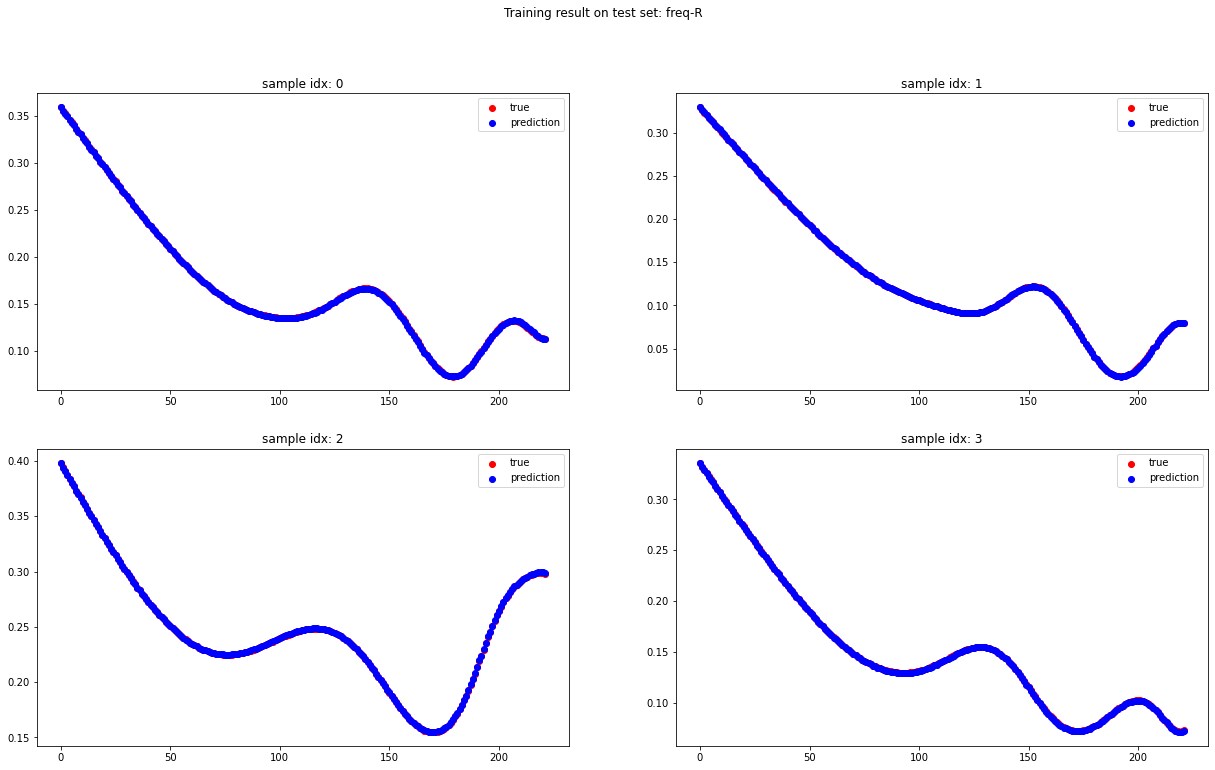

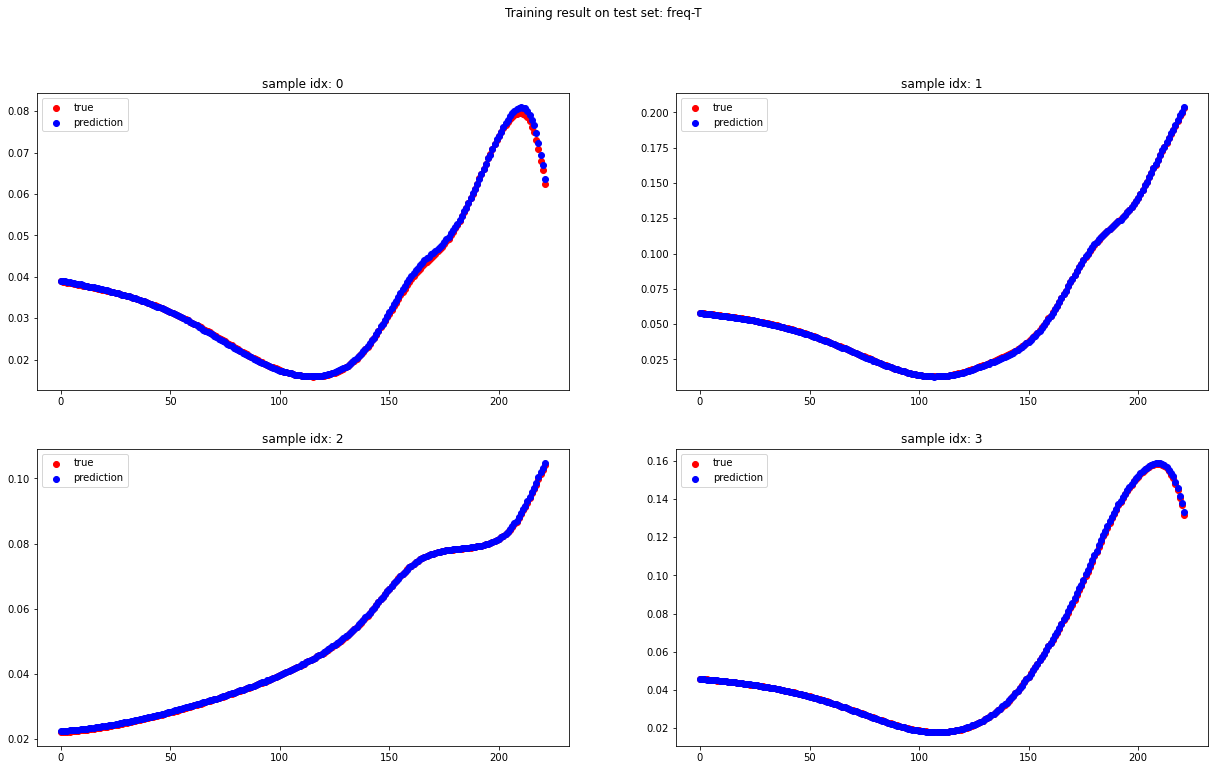

pseudo_params.shape: (10201, 4)
params_pick.shape: (10, 4)
params_pick: [[145. 122. 160.  75.]
 [146. 121. 160.  75.]
 [146. 122. 160.  75.]
 [145. 121. 160.  75.]
 [145. 123. 160.  75.]
 [146. 123. 160.  75.]
 [146. 120. 160.  75.]
 [145. 120. 160.  75.]
 [144. 122. 160.  75.]
 [145. 124. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


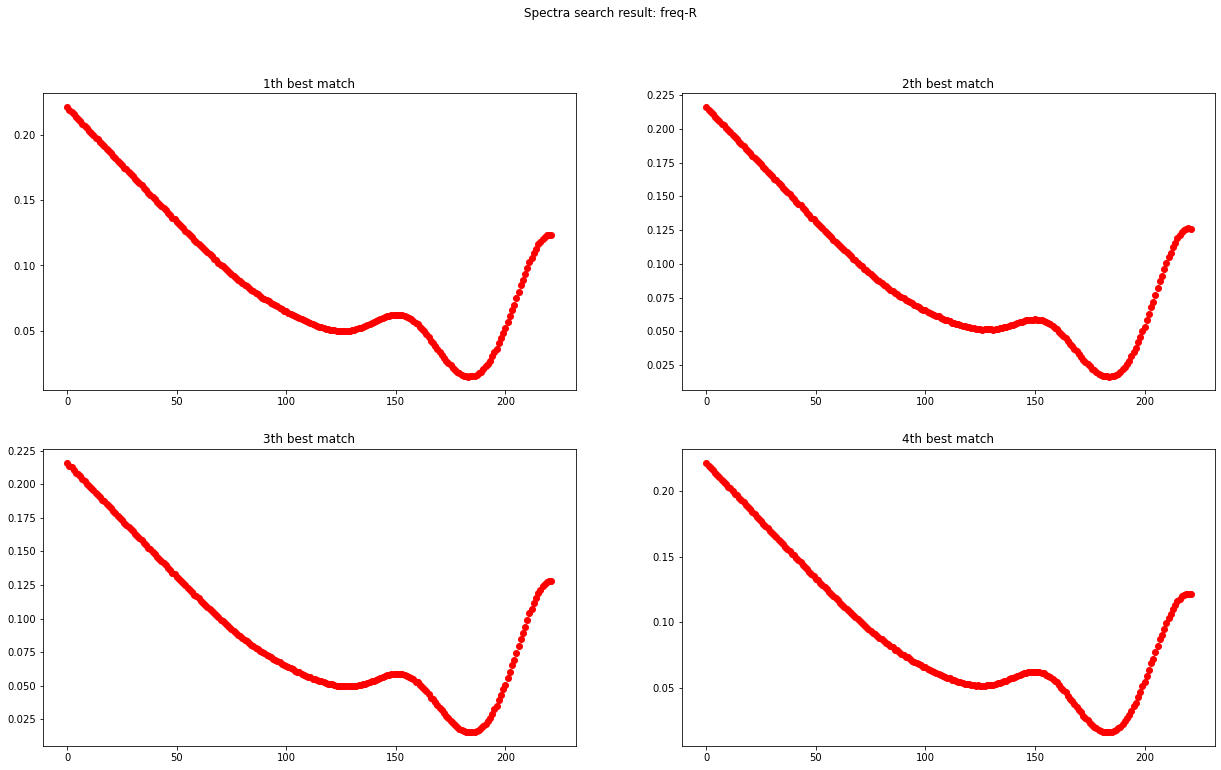

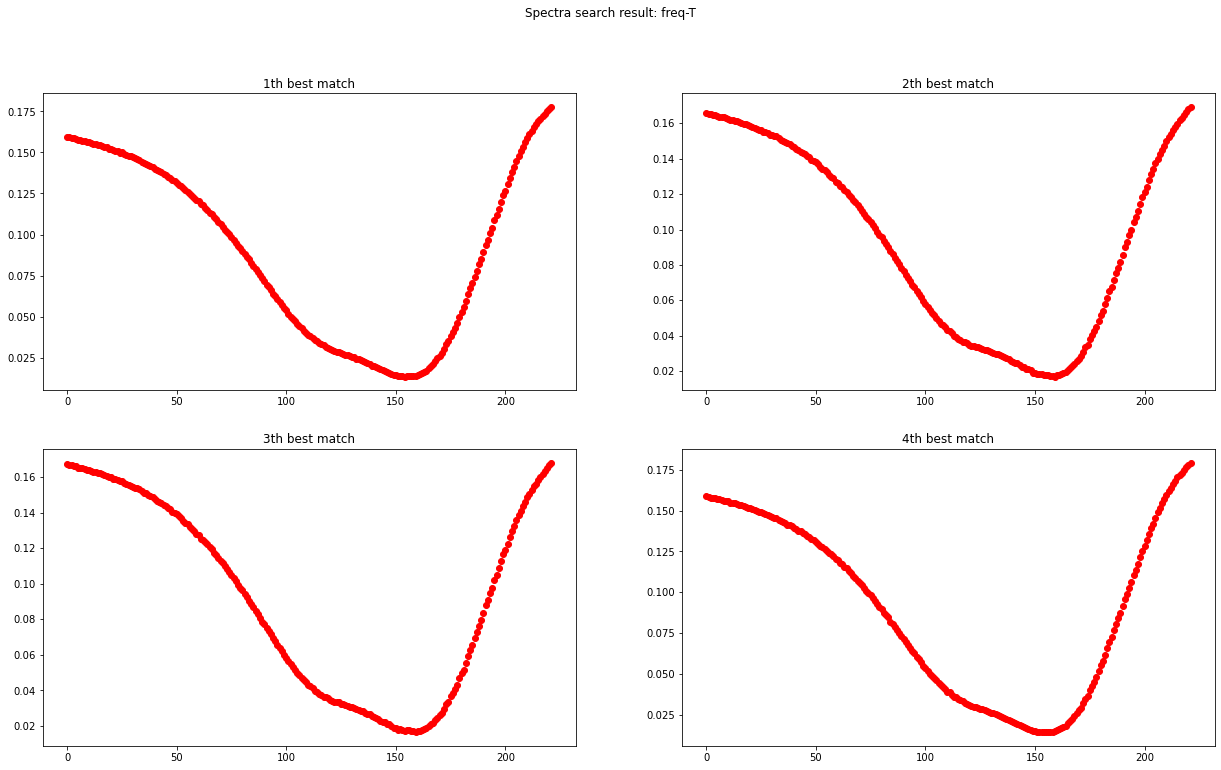

*** Reruning RCWA on picked params
params_dict.shape: (410, 4)
R_dict.shape: (410, 222)
T_dict.shape: (410, 222)
--------------------
1 th match
Already in the dict.
# params_dict: [145. 122. 160.  75.] params_pick: [145. 122. 160.  75.]
--------------------
2 th match
Already in the dict.
# params_dict: [146. 121. 160.  75.] params_pick: [146. 121. 160.  75.]
--------------------
3 th match
Already in the dict.
# params_dict: [146. 122. 160.  75.] params_pick: [146. 122. 160.  75.]
--------------------
4 th match
Already in the dict.
# params_dict: [145. 121. 160.  75.] params_pick: [145. 121. 160.  75.]
--------------------
5 th match
Already in the dict.
# params_dict: [145. 123. 160.  75.] params_pick: [145. 123. 160.  75.]
--------------------
6 th match
Already in the dict.
# params_dict: [146. 123. 160.  75.] params_pick: [146. 123. 160.  75.]
--------------------
7 th match
Already in the dict.
# params_dict: [146. 120. 160.  75.] params_pick: [146. 120. 160.  75.]
------------

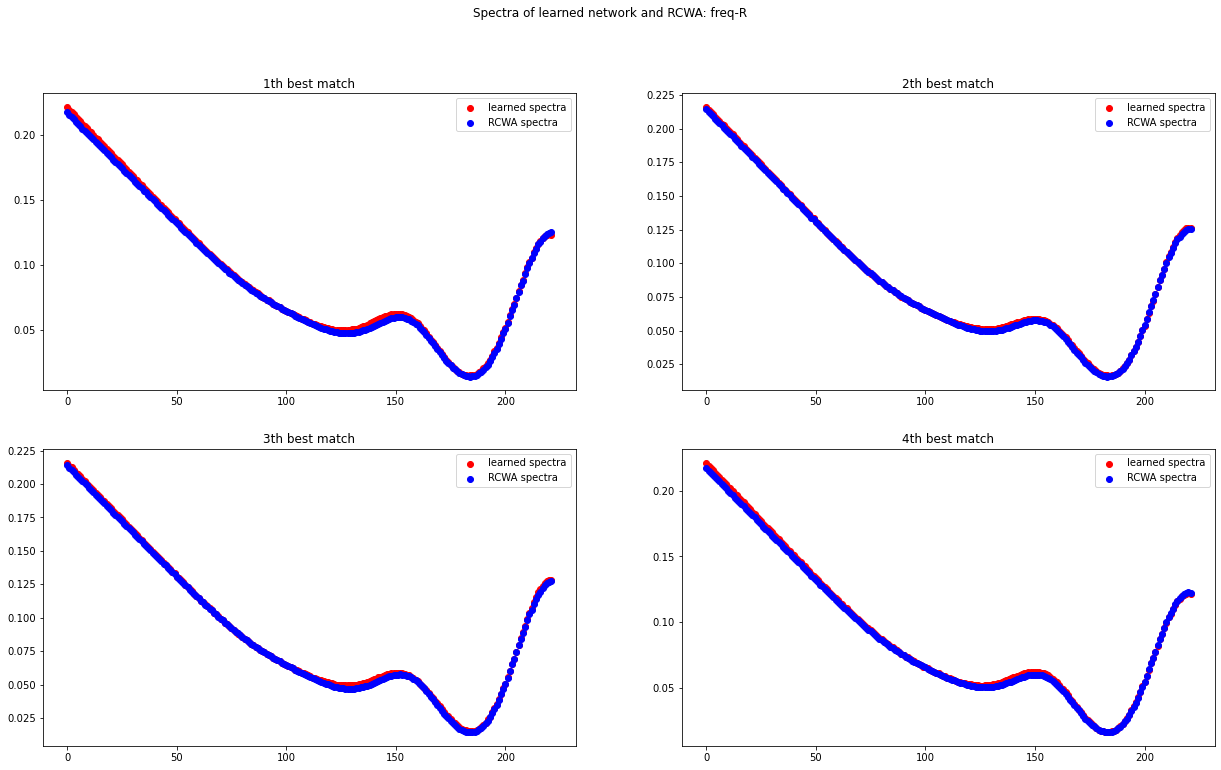

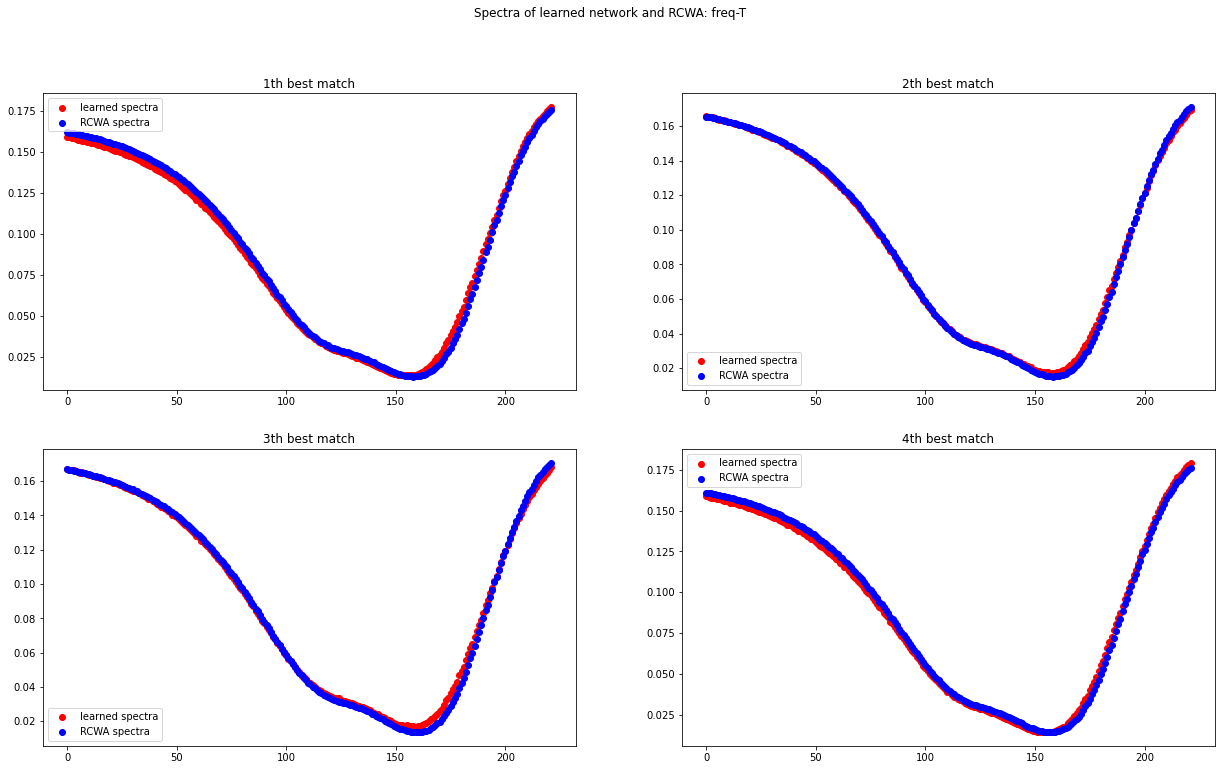

** Model saved.
**************************** ROUND 3 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 600
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [110. 104.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [121.  77.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [ 72. 109.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [102.  87.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [ 62. 143.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [133.  77.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [ 85. 103.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [ 92. 124.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [123.  85.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [104. 139.]
Calculatio

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [137. 119.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [ 58. 113.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [ 72. 135.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [73. 77.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [95. 78.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [136.  74.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [ 97. 131.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [88. 69.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [129.  79.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [ 51. 143.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [97. 94.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [ 87. 122.]
Calculation Progress: 100%
---------

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 0.00025814151362283153
### TEST LOSS  0.0005004068661946803
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 9.512348591821744e-05
### TEST LOSS  6.403846863476146e-05
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 7.723142743013037e-05
### TEST LOSS  3.7473550845687794e-05
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 7.584604848072255e-05
### TEST LOSS  4.443962865884209e-05
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 7.536886431201614e-05
### TEST LOSS  3.8414033446719666e-05
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 3.562207226764258e-05
### TEST LOSS  3.295162120290721e-05
----------------------------------------------------------------------
**

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 3.865014801765672e-06
### TEST LOSS  2.6214533540446105e-06
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 3.7085519319646208e-06
### TEST LOSS  4.785110225687579e-06
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 4.602719620478979e-06
### TEST LOSS  2.0385877456242774e-06
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 2.3067278070480294e-06
### TEST LOSS  1.7970392415615304e-06
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 2.612853933759614e-06
### TEST LOSS  1.5041770464247545e-06
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 4.778133099658059e-06
### TEST LOSS  3.2840452301267455e-06
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 6.151532365083294e-06
### TEST LOSS  2.141990206736308e-06
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 3.3431308311075253e-06
### TEST LOSS  1.1891754828260066e-06
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 2.0973457864196613e-06
### TEST LOSS  1.3665249538361322e-06
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 3.3164215756305755e-06
### TEST LOSS  7.96762747591452e-06
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 3.2964423544020366e-06
### TEST LOSS  9.257968511317611e-07
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 4.805264768492634e-06
### TEST LOSS  1.610492252742309e-06
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 6.392865483088409e-07
### TEST LOSS  5.257439157604596e-07
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 6.402285398543484e-07
### TEST LOSS  4.997633248472589e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 7.122974867594204e-07
### TEST LOSS  4.888134191737158e-07
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 5.796614958460584e-07
### TEST LOSS  5.112096851512938e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 6.273252080172635e-07
### TEST LOSS  4.901043269001093e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 5.244101425579591e-07
### TEST LOSS  5.864526144705451e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 5.307260693795021e-07
### TEST LOSS  3.66520813107248e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 4.556869413896436e-07
### TEST LOSS  4.304171044269525e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 4.595523631323317e-07
### TEST LOSS  3.4396459290696333e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 4.929586699257508e-07
### TEST LOSS  4.01369637377987e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 5.268513838885269e-07
### TEST LOSS  4.3478930125375984e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 4.923832255343541e-07
### TEST LOSS  4.2717209364834867e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 4.6368071873340945e-07
### TEST LOSS  4.757270378124506e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 5.623881383816828e-07
### TEST LOSS  5.525249409604132e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 5.077513921432815e-07
### TEST LOSS  3.948033635323453e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 4.7292186785341526e-07
### TEST LOSS  5.476196191820135e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 5.137933896648405e-07
### TEST LOSS  3.493464835931566e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 4.863811147200655e-07
### TEST LOSS  7.70307527394228e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 4.941764186128239e-07
### TEST LOSS  3.661854716736141e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 4.124156629655336e-07
### TEST LOSS  3.605586174318079e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 4.044396805014117e-07
### TEST LOSS  3.2083821110973076e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 4.3447243789055773e-07
### TEST LOSS  2.7663674333982476e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 3.6421272080625993e-07
### TEST LOSS  4.7084499025610665e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 3.831649749130861e-07
### TEST LOSS  2.9483501862159756e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 3.7500171477115413e-07
### TEST LOSS  3.5220621599465733e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 3.8134818849400174e-07
### TEST LOSS  3.9030184476966195e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 3.497412186407682e-07
### TEST LOSS  3.442280874171249e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 3.5443821145027717e-07
### TEST LOSS  3.9686494801571826e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 4.941025487840515e-07
### TEST LOSS  5.079557089023486e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 4.0356108507684967e-07
### TEST LOSS  5.17734166452202e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 3.1050597161315825e-07
### TEST LOSS  3.270139517199924e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 3.296306611725678e-07
### TEST LOSS  4.975128591569147e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 3.4532376137856127e-07
### TEST LOSS  2.619763361306266e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 3.897557477117175e-07
### TEST LOSS  3.639383439551441e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 3.495579818846295e-07
### TEST LOSS  3.0589532368847154e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 3.115969465738999e-07
### TEST LOSS  4.289905272495768e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 3.4432328176237094e-07
### TEST LOSS  4.5431205977466664e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 3.4858728548433267e-07
### TEST LOSS  2.5942154656554015e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 2.9554205620859383e-07
### TEST LOSS  3.13193690241557e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 3.158454044616121e-07
### TEST LOSS  2.711750255457446e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 3.076855940994013e-07
### TEST LOSS  3.761926860887696e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 3.2691244223670423e-07
### TEST LOSS  2.0739592482894093e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 2.90320097165638e-07
### TEST LOSS  3.0572021437870313e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 2.9094316345161057e-07
### TEST LOSS  2.455624341892973e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 3.1212948236714056e-07
### TEST LOSS  2.3053630116010027e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 2.836595912173815e-07
### TEST LOSS  2.88602889339826e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 3.0043178766684757e-07
### TEST LOSS  2.470629946553042e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 2.7840796709810436e-07
### TEST LOSS  2.755484776647184e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 1.7646997031424878e-06
### TEST LOSS  2.9333640820065434e-06
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 1.849931627025588e-06
### TEST LOSS  8.725414393969307e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 2.5808400431041414e-06
### TEST LOSS  8.179096211178047e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 2.0427650466281476e-06
### TEST LOSS  6.345881047309376e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 1.2283569947276382e-06
### TEST LOSS  9.61285751246679e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 1.3930169229325884e-06
### TEST LOSS  8.384465672861552e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 5.170660347649421e-07
### TEST LOSS  4.504109496237005e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 5.015022529401373e-07
### TEST LOSS  4.3321220901917616e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 4.6796086437576417e-07
### TEST LOSS  3.735398637319223e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 5.695714210200246e-07
### TEST LOSS  4.2635754324591187e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 4.3233154205365074e-07
### TEST LOSS  3.8774802785863153e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 4.764260324267392e-07
### TEST LOSS  4.1840434050754993e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 3.3815097253864225e-07
### TEST LOSS  3.0355358009930774e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 3.373631535138107e-07
### TEST LOSS  3.673103302996121e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 4.1269976592298955e-07
### TEST LOSS  2.8488972721637157e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 3.5794372943579825e-07
### TEST LOSS  2.7025657168956565e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 3.574793453105703e-07
### TEST LOSS  3.8218745935915246e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 3.3059161317794407e-07
### TEST LOSS  4.0259586045168464e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 3.452487967692264e-07
### TEST LOSS  4.3497033175299293e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 3.551082464111251e-07
### TEST LOSS  2.990191900506842e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 3.641729351618513e-07
### TEST LOSS  2.2042904706470128e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 3.5336115518092014e-07
### TEST LOSS  2.670638679092008e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 3.553521866628273e-07
### TEST LOSS  5.803946818458725e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 3.2446754850923297e-07
### TEST LOSS  2.4240764654829644e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 3.710374818292432e-07
### TEST LOSS  3.029272319407836e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 3.267436234940154e-07
### TEST LOSS  2.1229362801022944e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 3.0215800885358133e-07
### TEST LOSS  2.8735429206487123e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 3.5646546978777377e-07
### TEST LOSS  4.64886438875409e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 3.438370523175157e-07
### TEST LOSS  2.9776207889477115e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 3.712828743474006e-07
### TEST LOSS  2.6027135409852537e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 2.954609345569755e-07
### TEST LOSS  3.038298454309067e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 2.7624794190828084e-07
### TEST LOSS  2.3429420221216586e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 2.827143518106349e-07
### TEST LOSS  1.9893488456546038e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 3.4532301287507984e-07
### TEST LOSS  3.7378140405053273e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 2.926647171660098e-07
### TEST LOSS  3.4451215292897865e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 2.906792490442456e-07
### TEST LOSS  2.6425778148425e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 2.796367049739956e-07
### TEST LOSS  3.2900300400089895e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 2.7853091616236725e-07
### TEST LOSS  1.0753658633196512e-06
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 3.1930683201508715e-07
### TEST LOSS  3.352196560829018e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 3.1651470512391217e-07
### TEST LOSS  2.1150287131553745e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 2.930841241640299e-07
### TEST LOSS  2.734431379596774e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 2.679048993966167e-07
### TEST LOSS  2.2650462641296247e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 2.717165460689823e-07
### TEST LOSS  1.7589765219680783e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 2.813493576484897e-07
### TEST LOSS  1.9402910330275822e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 2.9597678246062743e-07
### TEST LOSS  2.079559540864769e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 2.7702044530878803e-07
### TEST LOSS  2.4554594486087604e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 2.984408881564112e-07
### TEST LOSS  2.0700421051363568e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 2.43704399961094e-07
### TEST LOSS  2.8521052936664796e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 2.3595863462529584e-07
### TEST LOSS  3.1498031047602933e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 2.4884921199822923e-07
### TEST LOSS  1.9963132539639142e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 2.4373492850079024e-07
### TEST LOSS  2.8834627919928204e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 2.443561326970212e-07
### TEST LOSS  2.549443078376296e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 2.3856371164162243e-07
### TEST LOSS  1.8405908501032778e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 2.5140093827739445e-07
### TEST LOSS  2.446662108468445e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 2.6745040562659026e-07
### TEST LOSS  2.2266348922686222e-07
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 3.564061126700343e-07
### TEST LOSS  5.357572061054977e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 2.466233915043858e-07
### TEST LOSS  2.0291812871972877e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 2.553678492430341e-07
### TEST LOSS  2.3805788866108438e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 2.3540061310593312e-07
### TEST LOSS  3.442386792408393e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 2.1972842950764478e-07
### TEST LOSS  4.523204463819436e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1112 || AVG LOSS 2.494061915392365e-07
### TEST LOSS  2.625203481759147e-07
----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 2.5787446357838915e-07
### TEST LOSS  2.749563508233324e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 2.3120252463352623e-07
### TEST LOSS  1.9473541594076474e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 2.7430201470816466e-07
### TEST LOSS  2.405093511015366e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 2.5766667377524755e-07
### TEST LOSS  1.4935540093574673e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 2.1569656764697241e-07
### TEST LOSS  1.9288721217789214e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1164 || AVG LOSS 2.3496023819902235e-07
### TEST LOSS  1.6801664691633454e-07
----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 2.5214179479130885e-07
### TEST LOSS  2.0632624853078596e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 2.3053173771122221e-07
### TEST LOSS  3.9310285160354397e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 2.5509472781237716e-07
### TEST LOSS  3.469456386382161e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 2.629922331879679e-07
### TEST LOSS  2.3328973952629894e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 2.485149372866147e-07
### TEST LOSS  2.57168060279077e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1216 || AVG LOSS 2.4315504527786893e-07
### TEST LOSS  1.675322178268996e-07
----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 3.0133570765755736e-07
### TEST LOSS  3.281454452361585e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 2.6647398206828634e-07
### TEST LOSS  3.5007780891444577e-07
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 2.287345534194666e-07
### TEST LOSS  1.7614129572191612e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 2.174267473324202e-07
### TEST LOSS  1.5229697680751997e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 2.2748834670830813e-07
### TEST LOSS  1.5148059636279262e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1268 || AVG LOSS 2.2514051110385698e-07
### TEST LOSS  3.215373551610254e-07
----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 2.476958850413287e-07
### TEST LOSS  1.9669967343816097e-07
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 2.5458918639624055e-07
### TEST LOSS  2.2653559976030616e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 2.2954226412075229e-07
### TEST LOSS  1.9699622081740623e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 2.2109332635800173e-07
### TEST LOSS  2.128912891900351e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 2.2058342914614096e-07
### TEST LOSS  3.7818785851110687e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1320 || AVG LOSS 2.1109374503206861e-07
### TEST LOSS  1.626165363354125e-07
----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 2.3187475958567442e-07
### TEST LOSS  2.8110046596591724e-07
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 2.022149034915562e-07
### TEST LOSS  2.1680318695871392e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 2.1871713132763185e-07
### TEST LOSS  2.231020188345509e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 2.1520498774722322e-07
### TEST LOSS  1.931663733658853e-07
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 2.208271111274011e-07
### TEST LOSS  3.012660051303505e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1372 || AVG LOSS 1.9980345291159552e-07
### TEST LOSS  2.0261450907178693e-07
----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 2.3444059313722694e-07
### TEST LOSS  1.8183498519243182e-07
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 2.1234417688790566e-07
### TEST LOSS  1.3539640046171067e-07
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 1.9201014384388296e-07
### TEST LOSS  1.910845573623495e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 2.0650952780698617e-07
### TEST LOSS  1.8734631465930659e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 2.140036693898395e-07
### TEST LOSS  2.6504646023618585e-07
------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1424 || AVG LOSS 2.2033147675829904e-07
### TEST LOSS  1.555253972027357e-07
----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 2.2107981886658005e-07
### TEST LOSS  2.0164600142733332e-07
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 2.4384018796119735e-07
### TEST LOSS  3.2251403720490794e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 2.0699842957938587e-07
### TEST LOSS  1.6694714430640386e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 2.044730716477261e-07
### TEST LOSS  1.4535719117247936e-07
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 2.1817468205990547e-07
### TEST LOSS  1.984935727882152e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1476 || AVG LOSS 2.1946692235393547e-07
### TEST LOSS  2.036032103407908e-07
----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 1.965974447652267e-07
### TEST LOSS  1.7270789164235288e-07
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 2.4805095882503755e-07
### TEST LOSS  1.802333602856581e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 2.0456157833118976e-07
### TEST LOSS  2.3210148785640033e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 2.0241719202710822e-07
### TEST LOSS  2.890780813736961e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 2.1922848075561774e-07
### TEST LOSS  2.6211243348623407e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1528 || AVG LOSS 1.927513928171957e-07
### TEST LOSS  4.0518825509631523e-07
----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 2.1916434610247394e-07
### TEST LOSS  1.4893860130390144e-07
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 1.9471354514818036e-07
### TEST LOSS  1.8885003625099569e-07
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 2.0991160328757512e-07
### TEST LOSS  1.8749514651972277e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 2.0529899279253529e-07
### TEST LOSS  2.7348693897187735e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 1.8821786186210923e-07
### TEST LOSS  1.5378003581645316e-07
-----------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1580 || AVG LOSS 1.8247130025924226e-07
### TEST LOSS  2.3320263488181405e-07
----------------------------------------------------------------------
*** EPOCH 1581 || AVG LOSS 2.2842684169373702e-07
### TEST LOSS  2.2147102324904861e-07
----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 2.1120497168070074e-07
### TEST LOSS  1.8309387428416812e-07
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 1.9882365934087432e-07
### TEST LOSS  1.5660171312801037e-07
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 1.906353178160458e-07
### TEST LOSS  2.1925782157773534e-07
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 2.1030252235062126e-07
### TEST LOSS  2.3110679592264205e-07
-----------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1632 || AVG LOSS 1.877028082889846e-07
### TEST LOSS  2.0331273889142824e-07
----------------------------------------------------------------------
*** EPOCH 1633 || AVG LOSS 2.0838340548519813e-07
### TEST LOSS  4.1634849720948193e-07
----------------------------------------------------------------------
*** EPOCH 1634 || AVG LOSS 1.9655810042114772e-07
### TEST LOSS  1.8407280953801495e-07
----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 1.9013824884931788e-07
### TEST LOSS  4.0255232155080495e-07
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 1.9698911748318912e-07
### TEST LOSS  1.64622998492329e-07
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 2.1199703441610042e-07
### TEST LOSS  2.2851468233713806e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1684 || AVG LOSS 1.7453120840412358e-07
### TEST LOSS  1.4723311873391745e-07
----------------------------------------------------------------------
*** EPOCH 1685 || AVG LOSS 2.077880570997929e-07
### TEST LOSS  3.930775278604415e-07
----------------------------------------------------------------------
*** EPOCH 1686 || AVG LOSS 1.8943120245751287e-07
### TEST LOSS  1.7059936081093636e-07
----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 2.143405677005698e-07
### TEST LOSS  1.6176987571725476e-07
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 2.0537730359630284e-07
### TEST LOSS  2.095893576223615e-07
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 1.8603158323730422e-07
### TEST LOSS  1.787335908905637e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1736 || AVG LOSS 1.8938966521867922e-07
### TEST LOSS  1.7151924838445768e-07
----------------------------------------------------------------------
*** EPOCH 1737 || AVG LOSS 1.7337720293516175e-07
### TEST LOSS  1.5725506980541266e-07
----------------------------------------------------------------------
*** EPOCH 1738 || AVG LOSS 1.9038668255255687e-07
### TEST LOSS  1.422615798989884e-07
----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 2.6145893424237934e-07
### TEST LOSS  3.697108089302977e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 2.6917787105655103e-07
### TEST LOSS  1.8690601501071393e-07
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 2.2035523933539025e-07
### TEST LOSS  2.71633489824631e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1788 || AVG LOSS 1.6920164687720767e-07
### TEST LOSS  2.7213022393526546e-07
----------------------------------------------------------------------
*** EPOCH 1789 || AVG LOSS 1.850228250965813e-07
### TEST LOSS  2.6092020119803135e-07
----------------------------------------------------------------------
*** EPOCH 1790 || AVG LOSS 2.1267214557714928e-07
### TEST LOSS  1.596463113805334e-07
----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 1.9614679086288334e-07
### TEST LOSS  1.720664831357984e-07
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 1.8292544041879446e-07
### TEST LOSS  1.5843402836581947e-07
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 1.8608113134514307e-07
### TEST LOSS  1.6039760137371357e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1840 || AVG LOSS 1.8996147791069025e-07
### TEST LOSS  1.648140823817812e-07
----------------------------------------------------------------------
*** EPOCH 1841 || AVG LOSS 1.887538455491722e-07
### TEST LOSS  1.907005926998156e-07
----------------------------------------------------------------------
*** EPOCH 1842 || AVG LOSS 1.7104910940239175e-07
### TEST LOSS  2.1174464532375876e-07
----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 1.7647526878346772e-07
### TEST LOSS  1.4218246412332923e-07
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 1.744258527214271e-07
### TEST LOSS  2.260930058481689e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 1.6717168744702821e-07
### TEST LOSS  1.6439465532079743e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1892 || AVG LOSS 1.8158233705397227e-07
### TEST LOSS  1.945267595399653e-07
----------------------------------------------------------------------
*** EPOCH 1893 || AVG LOSS 1.8017373454822423e-07
### TEST LOSS  1.1559951376385571e-07
----------------------------------------------------------------------
*** EPOCH 1894 || AVG LOSS 1.9417613985162064e-07
### TEST LOSS  1.3728160850076972e-07
----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 1.7499741746955048e-07
### TEST LOSS  1.7346278645567912e-07
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 1.843603664723285e-07
### TEST LOSS  1.4502172578861266e-07
----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 1.699719469291002e-07
### TEST LOSS  1.9204886017279125e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1944 || AVG LOSS 1.9107747390852598e-07
### TEST LOSS  1.257720383149616e-07
----------------------------------------------------------------------
*** EPOCH 1945 || AVG LOSS 1.6634779990513474e-07
### TEST LOSS  3.0955927993798264e-07
----------------------------------------------------------------------
*** EPOCH 1946 || AVG LOSS 1.7915062313337653e-07
### TEST LOSS  1.6292440423942227e-07
----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 1.8954784905211853e-07
### TEST LOSS  1.192925177898966e-07
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 1.8705929145509021e-07
### TEST LOSS  1.7108838948034747e-07
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 1.7245656160606397e-07
### TEST LOSS  2.0620270725481129e-07
------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1996 || AVG LOSS 1.7858284353818495e-07
### TEST LOSS  2.783075372134489e-07
----------------------------------------------------------------------
*** EPOCH 1997 || AVG LOSS 2.0232199705224236e-07
### TEST LOSS  1.6972896490743653e-07
----------------------------------------------------------------------
*** EPOCH 1998 || AVG LOSS 1.8324234870211362e-07
### TEST LOSS  1.190684023476428e-07
----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 1.9736743383032737e-07
### TEST LOSS  1.583301351754724e-07
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 1.9307128098648245e-07
### TEST LOSS  3.937240049051777e-07
** loss_train 1.9307128098648245e-07
** loss_test 3.937240049051777e-07
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


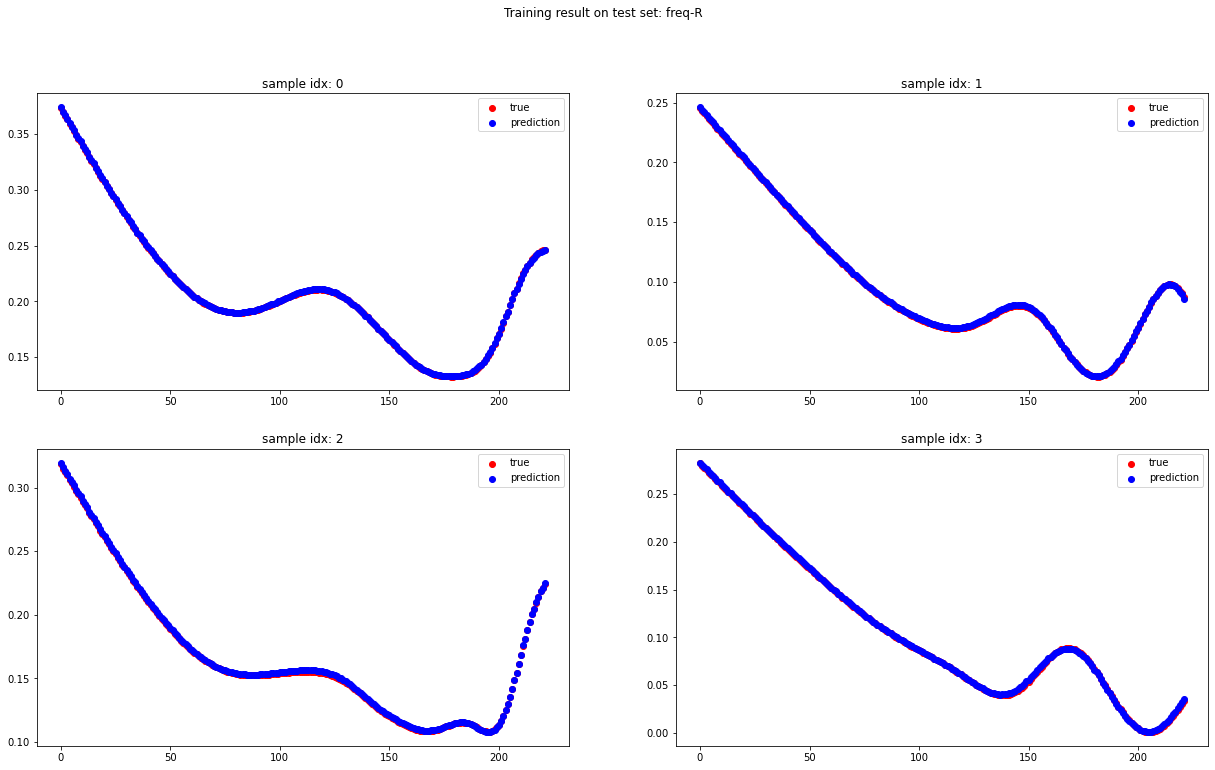

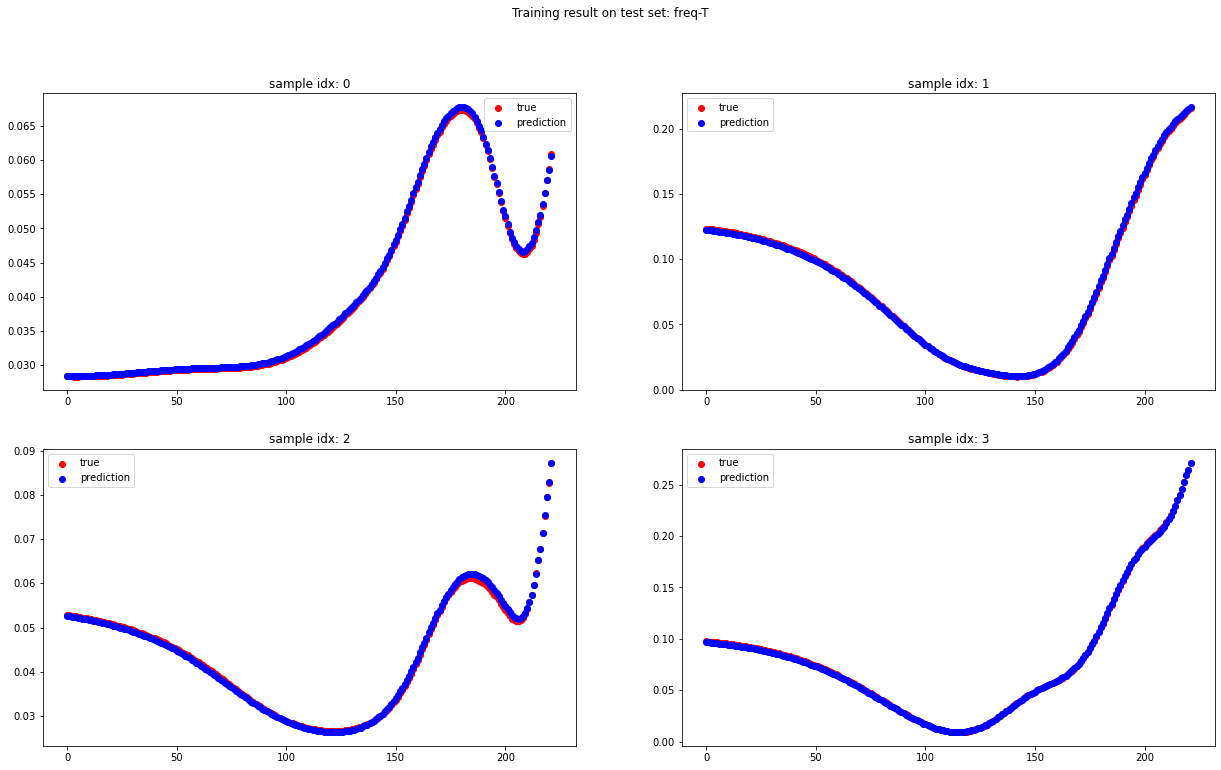

pseudo_params.shape: (10201, 4)
params_pick.shape: (10, 4)
params_pick: [[146. 121. 160.  75.]
 [145. 121. 160.  75.]
 [147. 121. 160.  75.]
 [146. 122. 160.  75.]
 [145. 120. 160.  75.]
 [146. 120. 160.  75.]
 [147. 122. 160.  75.]
 [145. 122. 160.  75.]
 [147. 120. 160.  75.]
 [146. 123. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


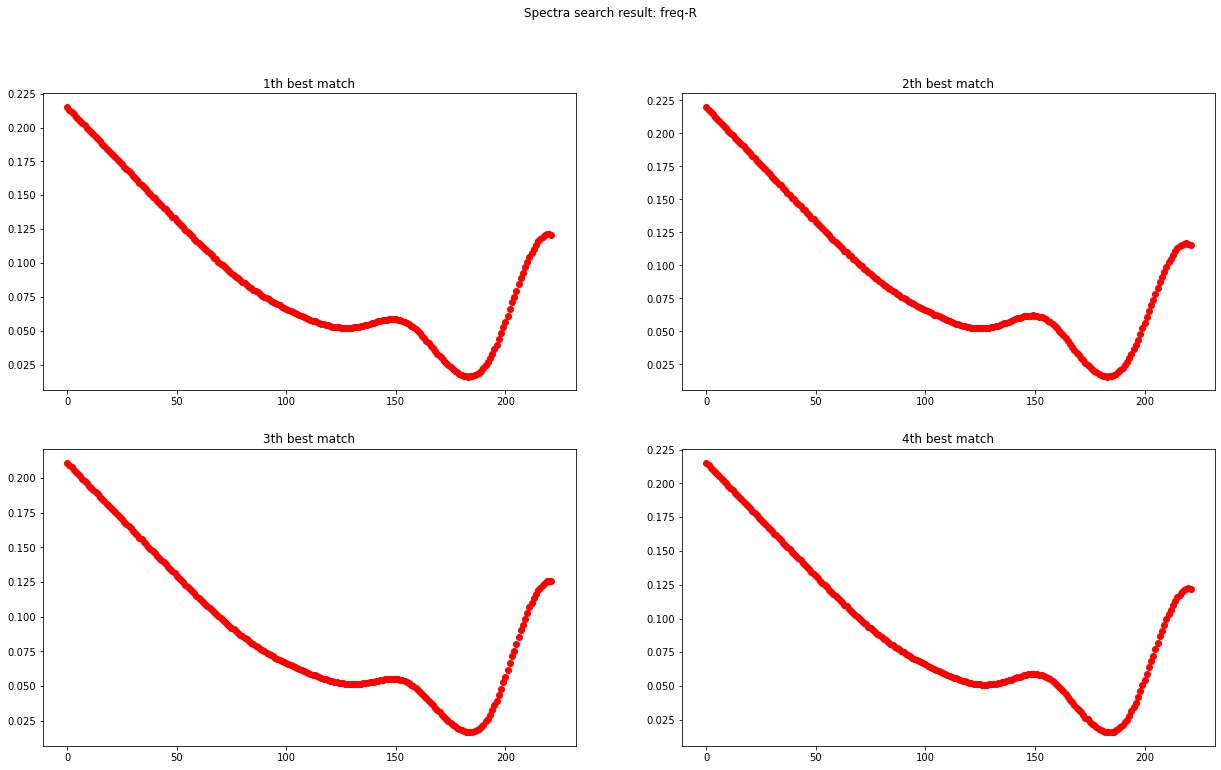

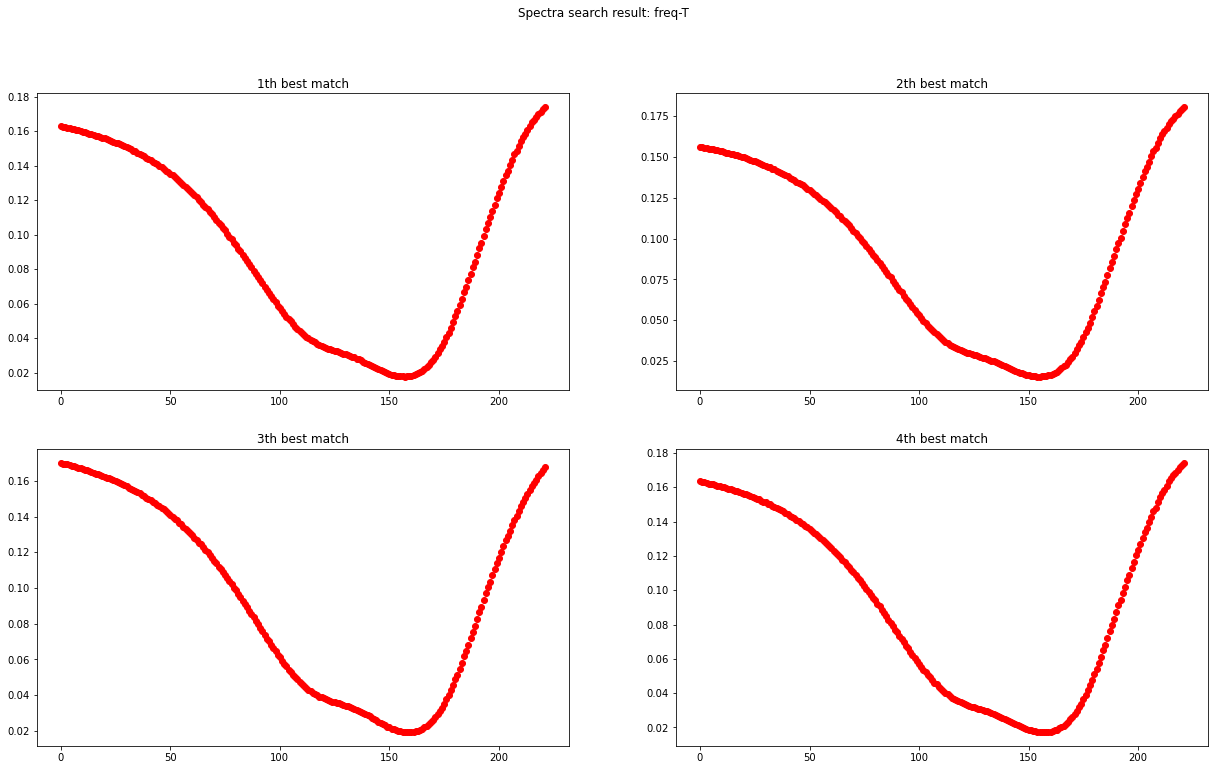

*** Reruning RCWA on picked params
params_dict.shape: (611, 4)
R_dict.shape: (611, 222)
T_dict.shape: (611, 222)
--------------------
1 th match
Already in the dict.
# params_dict: [146. 121. 160.  75.] params_pick: [146. 121. 160.  75.]
--------------------
2 th match
Already in the dict.
# params_dict: [145. 121. 160.  75.] params_pick: [145. 121. 160.  75.]
--------------------
3 th match
Not in the dict, calling RCWA...
# params_pick: [147. 121. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
4 th match
Already in the dict.
# params_dict: [146. 122. 160.  75.] params_pick: [146. 122. 160.  75.]
--------------------
5 th match
Already in the dict.
# params_dict: [145. 120. 160.  75.] params_pick: [145. 120. 160.  75.]
--------------------
6 th match
Already in the dict.
# params_dict: [146. 120. 160.  75.] params_pick: [146. 120. 160.  75.]
--------------------
7 th match
Not in the dict, calling RCWA...
# params_pick: [147. 122

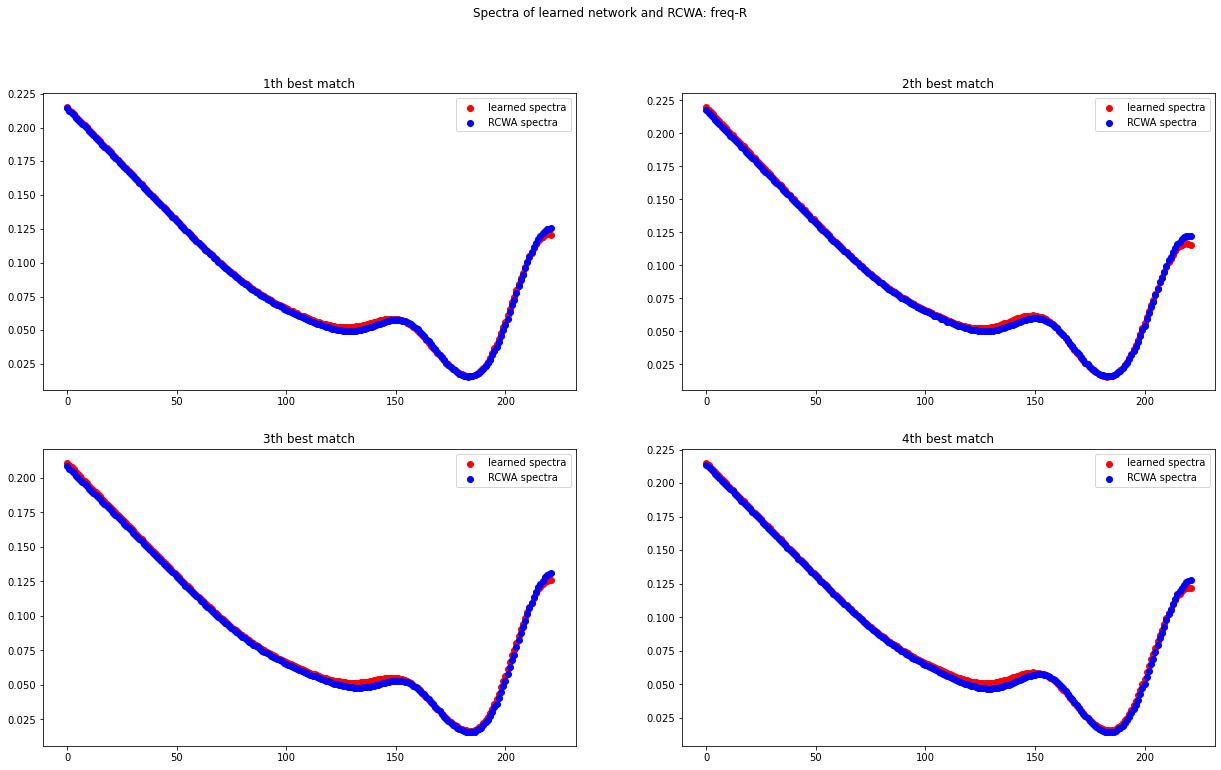

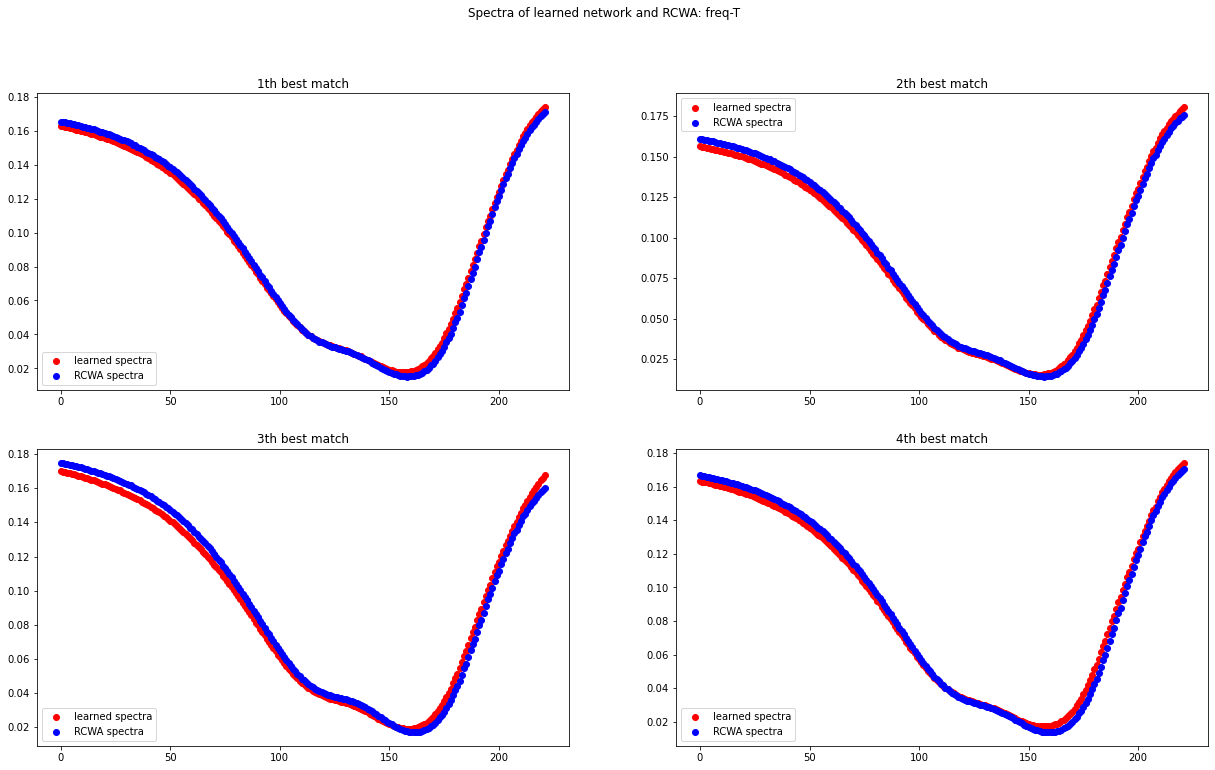

** Model saved.
**************************** ROUND 4 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 800
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [132. 123.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [145. 102.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [135.  57.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [132.  51.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [ 54. 144.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [ 79. 131.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [92. 96.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [ 54. 138.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [134.  63.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [ 92. 138.]
Calculation 

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [81. 86.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [137.  80.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [145.  86.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [143. 113.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [106. 133.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [114. 116.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [117. 121.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [150.  75.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [129. 104.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [116. 123.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [110. 112.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [78. 84.]
Calculation Progress: 100%
-----

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 8.971886625531056e-05
### TEST LOSS  0.00034727301802680205
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 3.12938191437695e-05
### TEST LOSS  2.0697408369111752e-05
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 3.118869538070612e-05
### TEST LOSS  7.866360889844752e-05
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 1.3190046881561557e-05
### TEST LOSS  2.3728949296734452e-05
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 2.000973478203605e-05
### TEST LOSS  8.883664122549817e-06
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 1.0413698280160589e-05
### TEST LOSS  1.2188568992617851e-05
----------------------------------------------------------------------


----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 3.087761291524771e-06
### TEST LOSS  2.836538707621609e-06
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 2.504582594440308e-06
### TEST LOSS  2.1942468796017542e-06
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 2.714957849256905e-06
### TEST LOSS  1.8421554652074217e-06
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 3.032750592417699e-06
### TEST LOSS  2.634030958385362e-06
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 2.2589148684915017e-06
### TEST LOSS  2.780220199838368e-06
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 2.3429988771894727e-06
### TEST LOSS  1.3810669277821337e-06
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 1.032200908950287e-06
### TEST LOSS  9.658329531703203e-07
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 9.616134960310773e-07
### TEST LOSS  8.419845727303255e-07
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 9.16166733642143e-07
### TEST LOSS  9.155378630036163e-07
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 1.148803561044076e-06
### TEST LOSS  1.0476535455457754e-06
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 1.249214177772018e-06
### TEST LOSS  1.228500176845652e-06
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 9.5301507295531e-07
### TEST LOSS  7.187849557036922e-07
------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 6.835513616731958e-07
### TEST LOSS  1.1649518114609236e-06
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 7.672033796168875e-07
### TEST LOSS  1.4345881140798156e-06
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 1.069916180505004e-06
### TEST LOSS  9.634104050822618e-07
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 8.442341034076151e-07
### TEST LOSS  7.367448328447305e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 7.702677069776342e-07
### TEST LOSS  5.95292161638857e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 8.589650932222526e-07
### TEST LOSS  7.07681328056727e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 7.321430434981125e-07
### TEST LOSS  6.445030322765888e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 8.220462862862376e-07
### TEST LOSS  7.619260316005239e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 6.700070748344444e-07
### TEST LOSS  6.803542333955193e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 6.422714864795509e-07
### TEST LOSS  6.121430734159125e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 6.784372134305272e-07
### TEST LOSS  6.092662871992616e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 9.255500217975055e-07
### TEST LOSS  7.195289602653551e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 8.911027885094569e-07
### TEST LOSS  4.935802853841172e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 8.150593829370223e-07
### TEST LOSS  6.359804463803206e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 6.294125116479421e-07
### TEST LOSS  7.273443429767212e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 6.427842797585015e-07
### TEST LOSS  5.407113358539087e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 6.593605047999773e-07
### TEST LOSS  4.844768473806956e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 5.986243545663683e-07
### TEST LOSS  5.165435676227995e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 6.139399349258667e-07
### TEST LOSS  4.86113040191564e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 5.646927992941642e-07
### TEST LOSS  5.599338640157233e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 5.283717272241973e-07
### TEST LOSS  4.105257526513621e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 6.217605099401169e-07
### TEST LOSS  9.305085436987307e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 6.720150183969764e-07
### TEST LOSS  7.286087016685391e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 6.551352293593382e-07
### TEST LOSS  7.748829536543175e-07
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 6.138259832466631e-07
### TEST LOSS  5.446160524040048e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 5.692316299610311e-07
### TEST LOSS  4.7369879041525564e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 5.675989230713441e-07
### TEST LOSS  5.172491791919734e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 5.791007069166909e-07
### TEST LOSS  4.6980500911786294e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 5.824074975269156e-07
### TEST LOSS  8.41747346195613e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 6.285181824949859e-07
### TEST LOSS  6.134743794442935e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 5.439654628380807e-07
### TEST LOSS  4.6115450184440004e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 5.287634788331274e-07
### TEST LOSS  4.0507606276681446e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 5.14746551907308e-07
### TEST LOSS  3.7260244549012594e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 5.359259946846606e-07
### TEST LOSS  5.432464410167389e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 5.453139185984668e-07
### TEST LOSS  5.82611486758348e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 5.10313418065067e-07
### TEST LOSS  8.097911035065408e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 5.462473450279504e-07
### TEST LOSS  5.544121961520432e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 5.357008432316235e-07
### TEST LOSS  4.7396483182637894e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 5.146369499797742e-07
### TEST LOSS  4.0111788261280407e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 5.565601192003555e-07
### TEST LOSS  4.1086523339117775e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 4.795458611095427e-07
### TEST LOSS  6.084032501500284e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 4.950328635278111e-07
### TEST LOSS  3.573530591438612e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 5.254537320142915e-07
### TEST LOSS  4.254004058642143e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 5.040535627554022e-07
### TEST LOSS  4.4781488384160184e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 4.5930257201121096e-07
### TEST LOSS  4.6431988683555875e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 4.81415751796277e-07
### TEST LOSS  7.658431826484957e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 4.511702170972853e-07
### TEST LOSS  4.0218566255134647e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 4.918480939153369e-07
### TEST LOSS  5.239383019291685e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 5.343435691340659e-07
### TEST LOSS  5.936363152159174e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 4.7598090089806535e-07
### TEST LOSS  6.536107501157554e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 4.798156650576147e-07
### TEST LOSS  4.894119219519174e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 4.5421908851039916e-07
### TEST LOSS  3.3479868003875407e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 4.51918157322595e-07
### TEST LOSS  4.3916537369644476e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 4.908442906792487e-07
### TEST LOSS  5.450420393534235e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 4.079249769040061e-07
### TEST LOSS  3.163466975782588e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 4.6188476316100235e-07
### TEST LOSS  6.013849708589684e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 4.253346591864826e-07
### TEST LOSS  4.08849582337704e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 4.531765658866149e-07
### TEST LOSS  7.457163585892582e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 5.917686539191891e-07
### TEST LOSS  3.668976683949647e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 4.786694099889743e-07
### TEST LOSS  1.013898251282323e-06
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 5.419462703137867e-07
### TEST LOSS  5.040018488481716e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 3.994190990530555e-07
### TEST LOSS  4.1351741231210326e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 6.351293347162112e-07
### TEST LOSS  8.831918923609313e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 4.588424943463565e-07
### TEST LOSS  4.6912046987775585e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 4.900627556203574e-07
### TEST LOSS  4.2005450969403074e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 4.2610344792137766e-07
### TEST LOSS  3.9283893945215215e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 4.0365669117914394e-07
### TEST LOSS  3.9394776507606366e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 4.895547746253115e-07
### TEST LOSS  3.2406546305689215e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 4.3353449424188285e-07
### TEST LOSS  5.173845707417968e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 4.478109459382651e-07
### TEST LOSS  3.590475188275377e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 4.565147987056761e-07
### TEST LOSS  3.177474852122941e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 4.38232261399385e-07
### TEST LOSS  6.420527777587873e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 4.009515011205167e-07
### TEST LOSS  3.0793265655878105e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 4.488198863317194e-07
### TEST LOSS  3.860931272470225e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 4.620043099912152e-07
### TEST LOSS  3.93622762828727e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 4.156985587133732e-07
### TEST LOSS  4.823596313485723e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 4.5171256292331206e-07
### TEST LOSS  3.325562829559203e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 5.74901887455681e-07
### TEST LOSS  3.865020659077345e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 4.889268273045034e-07
### TEST LOSS  3.359929318473102e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 4.4322621054693203e-07
### TEST LOSS  3.659297078684176e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 4.0501699785755465e-07
### TEST LOSS  4.5518878266648244e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 3.5458530299514736e-07
### TEST LOSS  3.391771249046845e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 4.4924053244521644e-07
### TEST LOSS  3.5603945036655205e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 4.1774975364949893e-07
### TEST LOSS  5.632033719393803e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 4.2946207991167994e-07
### TEST LOSS  4.558144131768434e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 4.267522850209815e-07
### TEST LOSS  3.7599618707417903e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 3.981300880218086e-07
### TEST LOSS  6.227264416717541e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 3.568180084556616e-07
### TEST LOSS  2.779692742649331e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 3.7667975918420635e-07
### TEST LOSS  2.817315791029766e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 4.1778304388007115e-07
### TEST LOSS  4.128788901880398e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 3.717332664887607e-07
### TEST LOSS  3.3755930672896284e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 3.72769786785021e-07
### TEST LOSS  2.935885348165357e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 3.4736725086137454e-07
### TEST LOSS  3.4041526930650434e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 3.7824699947730524e-07
### TEST LOSS  3.4469207103408433e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 3.358876453329884e-07
### TEST LOSS  4.290154317724652e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 3.2627845679034097e-07
### TEST LOSS  4.0251028347408163e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 3.6678291763792005e-07
### TEST LOSS  3.65330995085363e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 3.84074292805181e-07
### TEST LOSS  2.52968629155248e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 3.80077600605766e-07
### TEST LOSS  2.3520902203699734e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 3.87928509626434e-07
### TEST LOSS  5.191674929960755e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 3.5657293377955314e-07
### TEST LOSS  2.575958871394353e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 3.817937119654502e-07
### TEST LOSS  2.568461295500886e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 3.8907792846654134e-07
### TEST LOSS  3.5302766813553416e-07
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 3.8671211525453943e-07
### TEST LOSS  3.87899068717464e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 3.8255761051875227e-07
### TEST LOSS  3.357034946323741e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 3.282395032622176e-07
### TEST LOSS  4.004407709127615e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 3.4590974149040224e-07
### TEST LOSS  3.212270011469324e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 3.856906989607722e-07
### TEST LOSS  2.714764898807213e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1112 || AVG LOSS 3.580425130289555e-07
### TEST LOSS  3.565613771646288e-07
----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 3.5950136582307836e-07
### TEST LOSS  3.9498835017563277e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 3.5343916280350387e-07
### TEST LOSS  3.4415531284063644e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 3.4580020012775493e-07
### TEST LOSS  5.422732982651723e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 3.674778891049613e-07
### TEST LOSS  6.641576722662043e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 3.8386628902209453e-07
### TEST LOSS  2.3804308331894694e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1164 || AVG LOSS 3.1833152029925317e-07
### TEST LOSS  2.2934187763704964e-07
----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 3.8047814388875167e-07
### TEST LOSS  2.815662500192199e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 3.563367305758902e-07
### TEST LOSS  2.4447698147393265e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 3.326169289818992e-07
### TEST LOSS  3.7651858993588877e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 3.244961653381395e-07
### TEST LOSS  2.792977191745649e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 3.1155775285007794e-07
### TEST LOSS  3.092434302705745e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1216 || AVG LOSS 3.402429433130294e-07
### TEST LOSS  3.029814621413607e-07
----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 3.4364831151378895e-07
### TEST LOSS  2.251091295590868e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 3.190713091338893e-07
### TEST LOSS  4.091903728446293e-07
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 3.1579117334867843e-07
### TEST LOSS  2.1487503924314902e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 3.394475142526332e-07
### TEST LOSS  2.7002033912519135e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 3.7809789941167795e-07
### TEST LOSS  2.8849049016343997e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1268 || AVG LOSS 3.501845147857452e-07
### TEST LOSS  2.648199218432031e-07
----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 3.408473312882521e-07
### TEST LOSS  4.0840919268703146e-07
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 3.9210159838098943e-07
### TEST LOSS  3.43828858717643e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 3.383644010579445e-07
### TEST LOSS  4.907984679410523e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 3.5528601427525786e-07
### TEST LOSS  4.7273650001973994e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 3.135270575249649e-07
### TEST LOSS  2.2848154775563975e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1320 || AVG LOSS 3.6002705440019155e-07
### TEST LOSS  2.409966863107608e-07
----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 3.201219017912038e-07
### TEST LOSS  3.7254165619060586e-07
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 3.000969155841915e-07
### TEST LOSS  3.4547938080701596e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 3.327383227613723e-07
### TEST LOSS  4.019787359273626e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 3.9190171809533323e-07
### TEST LOSS  5.114786342611902e-07
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 3.5070624919919525e-07
### TEST LOSS  2.406354783583235e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1372 || AVG LOSS 3.32751334242154e-07
### TEST LOSS  2.654992741213391e-07
----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 3.3019521704424905e-07
### TEST LOSS  4.0333495595253527e-07
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 3.97576087665108e-07
### TEST LOSS  3.0489806945865894e-07
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 3.459577413744697e-07
### TEST LOSS  2.88117907606041e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 4.03913199096273e-07
### TEST LOSS  3.013374699397294e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 3.352555659175138e-07
### TEST LOSS  5.422167674851153e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1424 || AVG LOSS 3.2665924138974843e-07
### TEST LOSS  2.590550529646407e-07
----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 2.825668098527245e-07
### TEST LOSS  3.885700058011328e-07
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 3.286927208767665e-07
### TEST LOSS  2.735352057451716e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 3.051037958501368e-07
### TEST LOSS  4.68421913997948e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 3.261938162202327e-07
### TEST LOSS  2.7673693736574023e-07
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 4.113356007984237e-07
### TEST LOSS  2.4211773326972735e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1476 || AVG LOSS 3.41795198015582e-07
### TEST LOSS  4.0432022766860126e-07
----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 3.2084229978135426e-07
### TEST LOSS  2.6213165564096624e-07
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 3.4187994357726126e-07
### TEST LOSS  2.7000134513362656e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 3.601861633883985e-07
### TEST LOSS  6.218890362674756e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 3.2432841132745695e-07
### TEST LOSS  2.520347119154091e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 3.220590270691659e-07
### TEST LOSS  2.6834584569238967e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1528 || AVG LOSS 3.599917464258695e-07
### TEST LOSS  2.8364737640155607e-07
----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 3.1168312280449584e-07
### TEST LOSS  2.5023717142858004e-07
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 3.4262390825823273e-07
### TEST LOSS  2.099374434294532e-07
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 3.0911205649797325e-07
### TEST LOSS  2.941894704141153e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 3.248504947217512e-07
### TEST LOSS  2.358065221604496e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 3.2943219325343164e-07
### TEST LOSS  3.1560708653917874e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1580 || AVG LOSS 3.3563497785493724e-07
### TEST LOSS  2.6025018110923764e-07
----------------------------------------------------------------------
*** EPOCH 1581 || AVG LOSS 3.29004849248804e-07
### TEST LOSS  2.8901298894841904e-07
----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 3.0361619488328275e-07
### TEST LOSS  2.5531400164406176e-07
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 3.509894228548305e-07
### TEST LOSS  3.2527529943611927e-07
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 3.233059936702531e-07
### TEST LOSS  5.541981072572829e-07
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 3.103989515929051e-07
### TEST LOSS  2.983306780871923e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1632 || AVG LOSS 3.198810829485588e-07
### TEST LOSS  4.0829126154070156e-07
----------------------------------------------------------------------
*** EPOCH 1633 || AVG LOSS 3.1106612536913046e-07
### TEST LOSS  2.5265040548561046e-07
----------------------------------------------------------------------
*** EPOCH 1634 || AVG LOSS 3.187963404949201e-07
### TEST LOSS  5.817078516656693e-07
----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 3.5147209849650805e-07
### TEST LOSS  2.9749688224001147e-07
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 2.6884665348170246e-07
### TEST LOSS  2.947860243314911e-07
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 3.156944706805831e-07
### TEST LOSS  2.0331600107207729e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1684 || AVG LOSS 2.9932951207900514e-07
### TEST LOSS  2.0551829157019105e-07
----------------------------------------------------------------------
*** EPOCH 1685 || AVG LOSS 3.248202476413553e-07
### TEST LOSS  3.587394227603606e-07
----------------------------------------------------------------------
*** EPOCH 1686 || AVG LOSS 3.0703262404507825e-07
### TEST LOSS  5.383353093672364e-07
----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 3.482574487323475e-07
### TEST LOSS  3.921425838863494e-07
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 2.8142660924768136e-07
### TEST LOSS  4.224670557088454e-07
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 3.4514305685018343e-07
### TEST LOSS  2.1605218591957964e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1736 || AVG LOSS 3.19722494692698e-07
### TEST LOSS  2.782787689170618e-07
----------------------------------------------------------------------
*** EPOCH 1737 || AVG LOSS 2.926239812461873e-07
### TEST LOSS  4.5792301032558197e-07
----------------------------------------------------------------------
*** EPOCH 1738 || AVG LOSS 2.722513170594354e-07
### TEST LOSS  3.263657243716504e-07
----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 3.1110972619652345e-07
### TEST LOSS  2.742087067038786e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 3.271290293849205e-07
### TEST LOSS  2.2995483680195625e-07
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 3.272619355643158e-07
### TEST LOSS  3.1401881983583735e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1788 || AVG LOSS 3.098258297029588e-07
### TEST LOSS  3.789027995064013e-07
----------------------------------------------------------------------
*** EPOCH 1789 || AVG LOSS 2.823235035354088e-07
### TEST LOSS  2.6123408266206144e-07
----------------------------------------------------------------------
*** EPOCH 1790 || AVG LOSS 3.2836384033396727e-07
### TEST LOSS  4.49614082261481e-07
----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 2.760179461480661e-07
### TEST LOSS  2.3569025249988348e-07
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 2.857196192618261e-07
### TEST LOSS  3.2913438019477326e-07
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 3.1753340889117966e-07
### TEST LOSS  2.5131933512057003e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1840 || AVG LOSS 3.3796382748807473e-07
### TEST LOSS  2.6033210550243285e-07
----------------------------------------------------------------------
*** EPOCH 1841 || AVG LOSS 2.8148145551742944e-07
### TEST LOSS  2.5608195741710915e-07
----------------------------------------------------------------------
*** EPOCH 1842 || AVG LOSS 2.8643056711796786e-07
### TEST LOSS  2.52074985477672e-07
----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 3.0507257080980566e-07
### TEST LOSS  2.1392315829871222e-07
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 3.484833188593939e-07
### TEST LOSS  2.816082442791412e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 3.1391617077325407e-07
### TEST LOSS  2.051406629751303e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1892 || AVG LOSS 2.848497201712874e-07
### TEST LOSS  3.3052877057571095e-07
----------------------------------------------------------------------
*** EPOCH 1893 || AVG LOSS 2.998195305847773e-07
### TEST LOSS  4.044846685739382e-07
----------------------------------------------------------------------
*** EPOCH 1894 || AVG LOSS 2.87965303362725e-07
### TEST LOSS  2.9195769239246755e-07
----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 2.947082758142372e-07
### TEST LOSS  2.6091742929186995e-07
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 2.842345094489218e-07
### TEST LOSS  2.553998292853521e-07
----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 3.1140085905878577e-07
### TEST LOSS  2.1611834100099259e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1944 || AVG LOSS 3.0851127190256734e-07
### TEST LOSS  5.754564706232183e-07
----------------------------------------------------------------------
*** EPOCH 1945 || AVG LOSS 2.708637881498888e-07
### TEST LOSS  2.0751786067307876e-07
----------------------------------------------------------------------
*** EPOCH 1946 || AVG LOSS 2.7283365160446494e-07
### TEST LOSS  2.2322650868507785e-07
----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 2.7445483238519583e-07
### TEST LOSS  1.9295057403686164e-07
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 2.8381791698173233e-07
### TEST LOSS  2.2827598418947068e-07
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 3.0907385914158423e-07
### TEST LOSS  2.810267645259046e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1996 || AVG LOSS 2.787582129526456e-07
### TEST LOSS  2.4651594306609087e-07
----------------------------------------------------------------------
*** EPOCH 1997 || AVG LOSS 2.9191820020590955e-07
### TEST LOSS  2.563885447652107e-07
----------------------------------------------------------------------
*** EPOCH 1998 || AVG LOSS 2.995875125000325e-07
### TEST LOSS  3.0265358456442e-07
----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 3.086026698984057e-07
### TEST LOSS  2.48354783849436e-07
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 3.163281720297562e-07
### TEST LOSS  2.846591418877627e-07
** loss_train 3.163281720297562e-07
** loss_test 2.846591418877627e-07
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


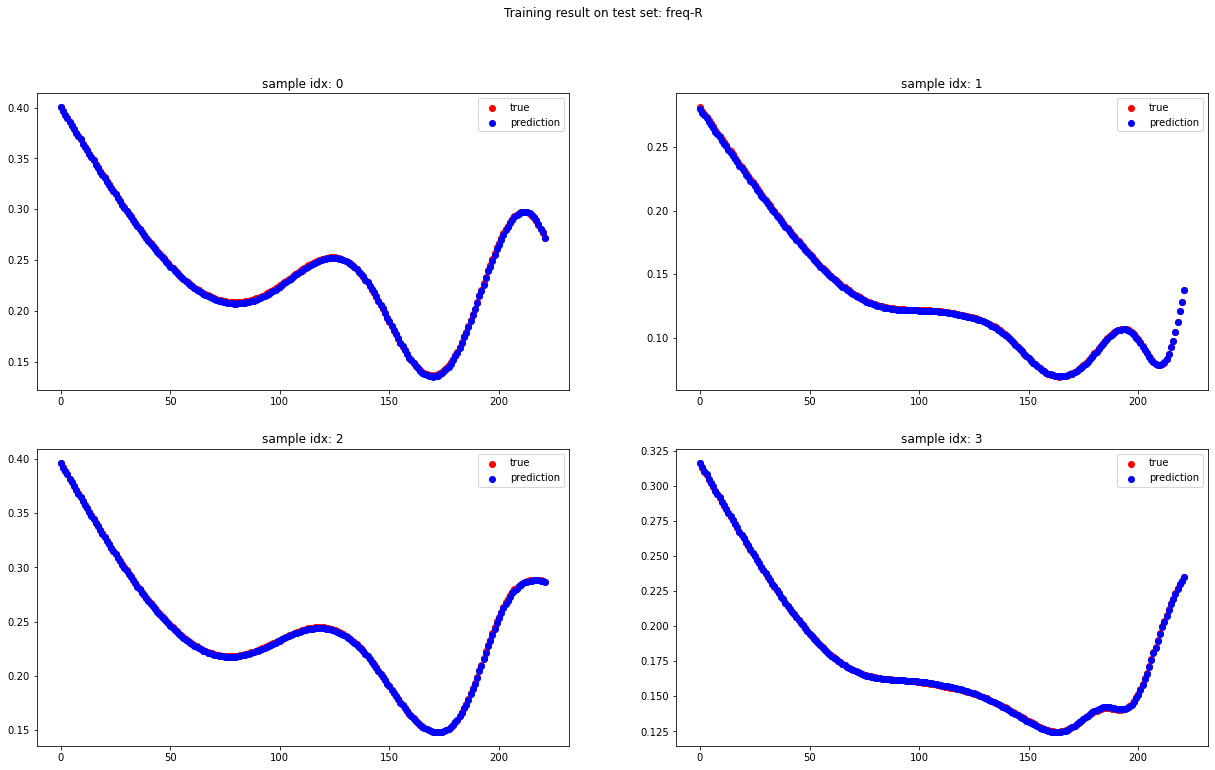

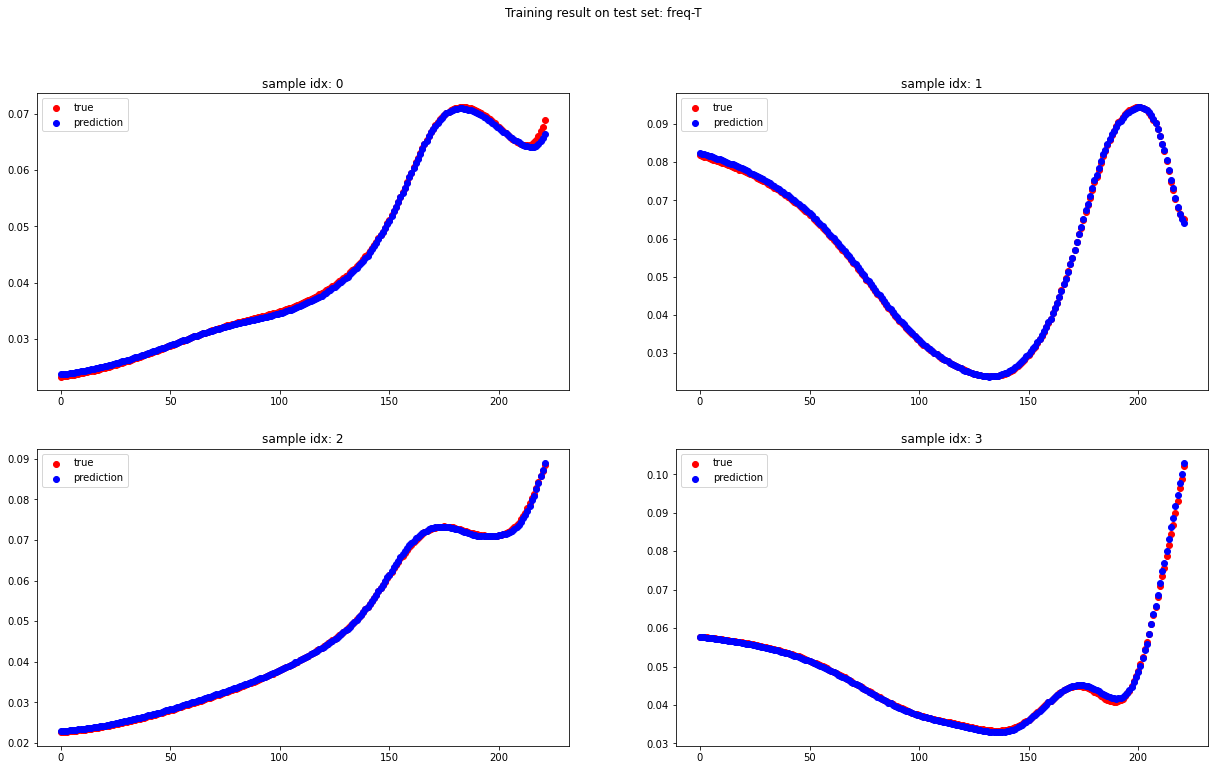

pseudo_params.shape: (10201, 4)
params_pick.shape: (10, 4)
params_pick: [[147. 121. 160.  75.]
 [147. 122. 160.  75.]
 [147. 120. 160.  75.]
 [146. 122. 160.  75.]
 [146. 121. 160.  75.]
 [147. 123. 160.  75.]
 [147. 119. 160.  75.]
 [148. 121. 160.  75.]
 [146. 123. 160.  75.]
 [146. 120. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


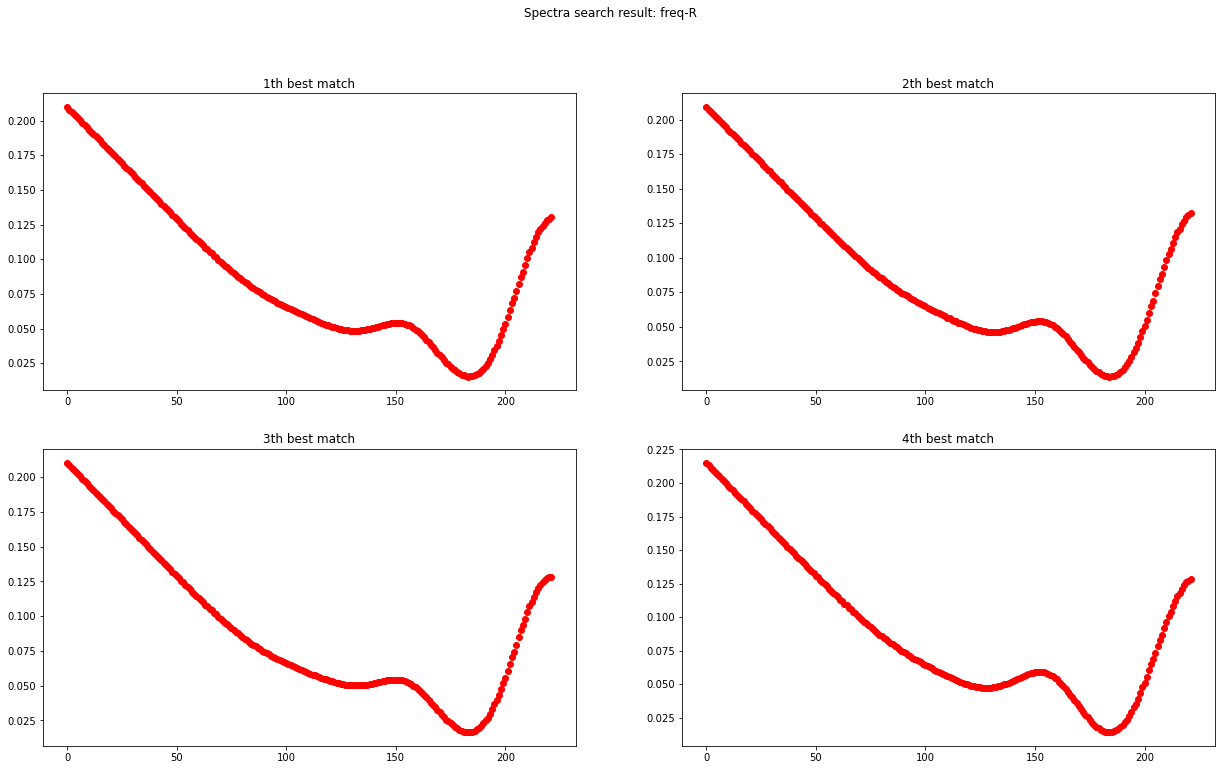

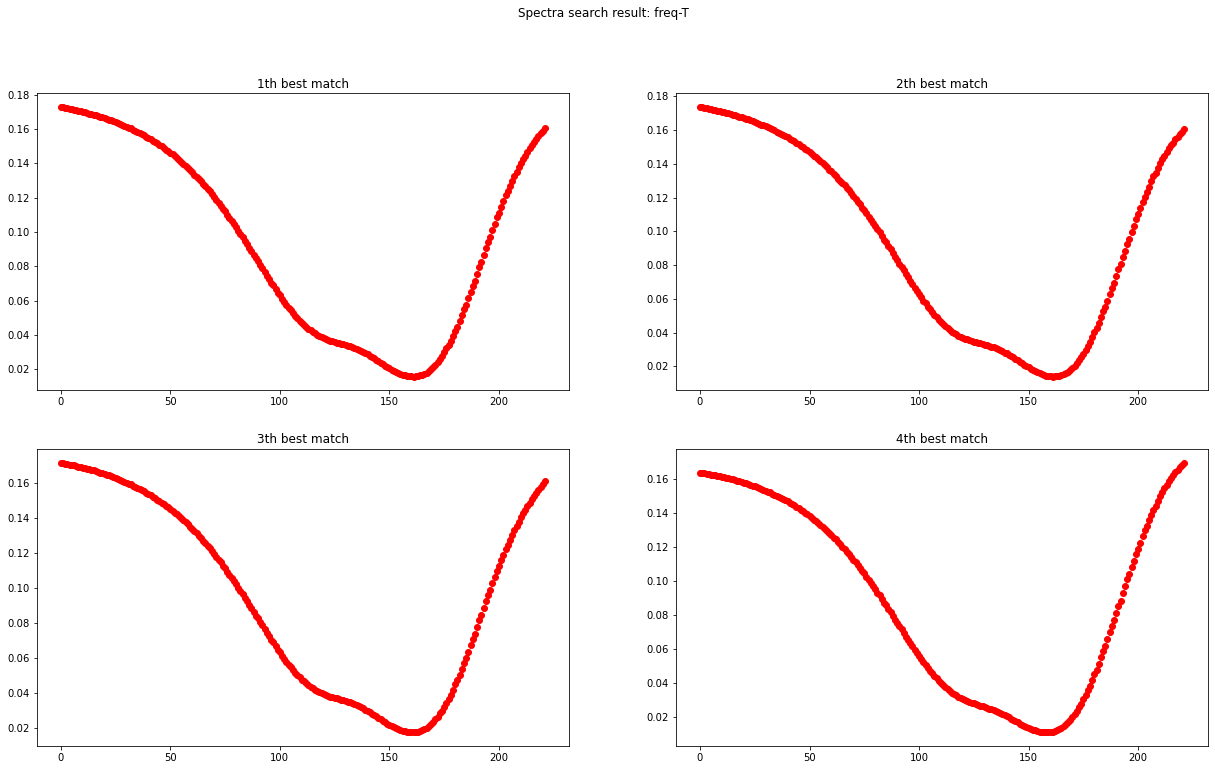

*** Reruning RCWA on picked params
params_dict.shape: (814, 4)
R_dict.shape: (814, 222)
T_dict.shape: (814, 222)
--------------------
1 th match
Already in the dict.
# params_dict: [147. 121. 160.  75.] params_pick: [147. 121. 160.  75.]
--------------------
2 th match
Already in the dict.
# params_dict: [147. 122. 160.  75.] params_pick: [147. 122. 160.  75.]
--------------------
3 th match
Already in the dict.
# params_dict: [147. 120. 160.  75.] params_pick: [147. 120. 160.  75.]
--------------------
4 th match
Already in the dict.
# params_dict: [146. 122. 160.  75.] params_pick: [146. 122. 160.  75.]
--------------------
5 th match
Already in the dict.
# params_dict: [146. 121. 160.  75.] params_pick: [146. 121. 160.  75.]
--------------------
6 th match
Not in the dict, calling RCWA...
# params_pick: [147. 123. 160.  75.]
Freq truncate.
freq.shape: (222,)
[ 1 / 1 ]
Calculation Progress: 100%
--------------------
7 th match
Not in the dict, calling RCWA...
# params_pick: [147. 119

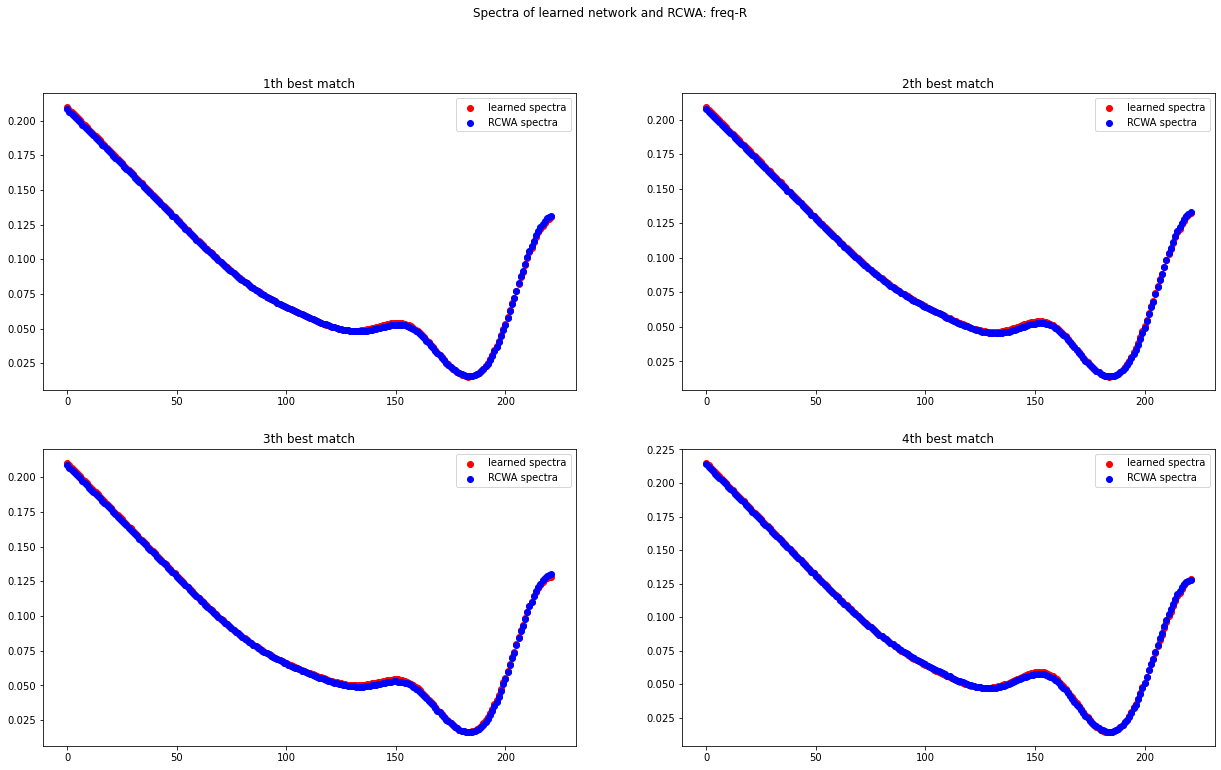

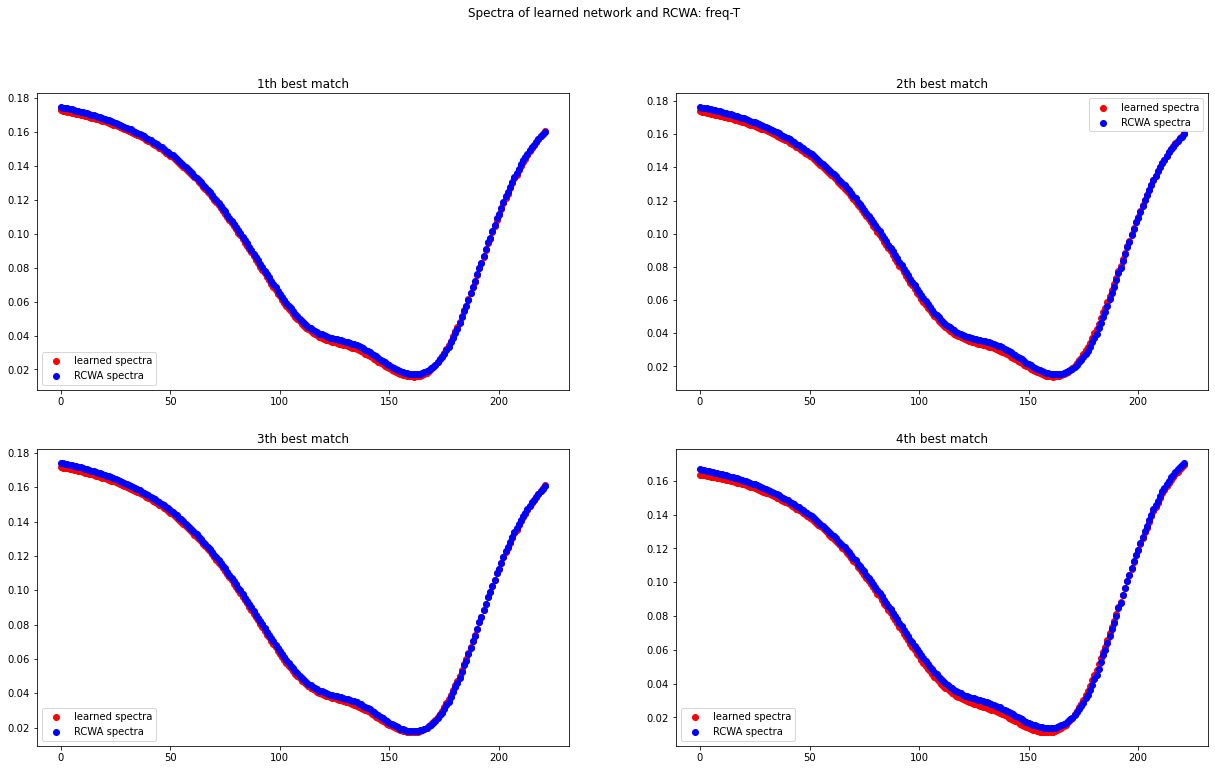

** Model saved.
**************************** ROUND 5 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 1000
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [87. 55.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [149. 137.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [93. 56.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [130.  78.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [141.  98.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [72. 65.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [85. 76.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [107. 135.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [95. 64.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [137. 138.]
Calculation Progres

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [ 83. 126.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [ 89. 104.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [139. 105.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [130.  52.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [108.  87.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [53. 53.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [104. 143.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [123.  64.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [90. 77.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [59. 86.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [56. 86.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [117. 103.]
Calculation Progress: 100%
---------

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 7.890891603096862e-05
### TEST LOSS  0.0004734262959876408
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 3.5900559006563524e-05
### TEST LOSS  8.087091615986235e-06
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 3.3159071412569575e-05
### TEST LOSS  3.6692063319302784e-05
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 1.4923277489060637e-05
### TEST LOSS  4.882299284266385e-06
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 6.488735473908492e-06
### TEST LOSS  4.018488395255796e-06
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 4.774816122221637e-06
### TEST LOSS  3.07410894796097e-06
----------------------------------------------------------------------
**

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 8.417540597420725e-07
### TEST LOSS  6.508496198875946e-07
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 8.325964088058413e-07
### TEST LOSS  6.042129105784019e-07
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 8.706050095170781e-07
### TEST LOSS  7.730400094866733e-07
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 1.0799789900346469e-06
### TEST LOSS  8.841625117383956e-07
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 7.934387394641363e-07
### TEST LOSS  5.657449776208523e-07
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 8.618545159038149e-07
### TEST LOSS  6.976976654489893e-07
---------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 8.219468840806598e-07
### TEST LOSS  1.4381408012316874e-06
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 8.958484039212067e-07
### TEST LOSS  1.5316290576568765e-06
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 7.360923154990928e-07
### TEST LOSS  7.189030687489624e-07
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 6.863959424414645e-07
### TEST LOSS  4.774167450705135e-07
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 5.87731342577058e-07
### TEST LOSS  6.09578103194508e-07
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 6.575367084771245e-07
### TEST LOSS  6.124799862542811e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 5.886971894035752e-07
### TEST LOSS  1.4663973388451268e-06
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 6.084357105962113e-07
### TEST LOSS  7.195785277266017e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 5.913682782860974e-07
### TEST LOSS  5.719134340627837e-07
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 5.507035077343403e-07
### TEST LOSS  4.96723045747179e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 5.618414225097013e-07
### TEST LOSS  5.375466609317907e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 4.900627206581021e-07
### TEST LOSS  4.848157307909181e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 5.241955062409432e-07
### TEST LOSS  5.881898971438204e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 4.580449783588847e-07
### TEST LOSS  5.383853306284436e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 5.140097237514852e-07
### TEST LOSS  5.53257247778068e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 5.231811030377287e-07
### TEST LOSS  4.504442718674303e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 5.163675415289504e-07
### TEST LOSS  6.252578998555692e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 4.915109084748792e-07
### TEST LOSS  3.933544159432737e-07
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 4.85559686090653e-07
### TEST LOSS  8.775951035507509e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 5.361273788189181e-07
### TEST LOSS  5.388687308519972e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 4.871454217685312e-07
### TEST LOSS  3.628381724259574e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 4.784332637584043e-07
### TEST LOSS  3.382623314488834e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 4.658075750647583e-07
### TEST LOSS  5.951747501361145e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 4.26235381119966e-07
### TEST LOSS  4.4584006294220063e-07
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 4.81671075505119e-07
### TEST LOSS  5.963692444765911e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 9.509094538486806e-07
### TEST LOSS  1.715403963468513e-06
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 7.298844162164641e-07
### TEST LOSS  5.067708552057107e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 7.799235638046298e-07
### TEST LOSS  5.100773004566388e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 5.839491519381568e-07
### TEST LOSS  4.580105837703741e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 5.573943165373407e-07
### TEST LOSS  5.232971981664983e-07
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 4.7680766888191784e-07
### TEST LOSS  3.577336163592311e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 4.2435189194023335e-07
### TEST LOSS  3.129535353233829e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 4.1011177532368495e-07
### TEST LOSS  7.735805335566207e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 4.310574671890777e-07
### TEST LOSS  5.481054965154423e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 4.0774769221485486e-07
### TEST LOSS  2.491817213012837e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 4.0265656668836416e-07
### TEST LOSS  6.937140805500045e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 3.653908057721367e-07
### TEST LOSS  4.6376647825733624e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 4.49938537574468e-07
### TEST LOSS  4.917891014126023e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 4.055037671584216e-07
### TEST LOSS  4.251146265232819e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 4.196412662196281e-07
### TEST LOSS  3.2319560621848117e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 4.41917467878028e-07
### TEST LOSS  4.6890266579187787e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 4.0057365679757593e-07
### TEST LOSS  4.997213106131919e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 4.110660668956712e-07
### TEST LOSS  3.682229911798155e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 4.0510302648044674e-07
### TEST LOSS  7.51904288639101e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 3.850734264680966e-07
### TEST LOSS  7.188229498448588e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 3.8591576452873257e-07
### TEST LOSS  3.1053366645513354e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 4.175601417877317e-07
### TEST LOSS  4.3711019088732427e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 3.992705472768421e-07
### TEST LOSS  5.85995201163314e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 3.7370825815941087e-07
### TEST LOSS  4.5372224046028955e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 4.319050499006494e-07
### TEST LOSS  5.316614135608688e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 4.1142138861260945e-07
### TEST LOSS  3.0929854422841647e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 4.089619817371215e-07
### TEST LOSS  5.841761624954718e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 3.6974016611068804e-07
### TEST LOSS  6.382049984191932e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 3.5901547598271576e-07
### TEST LOSS  2.370209548037868e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 3.812111292305076e-07
### TEST LOSS  3.946253646821181e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 4.514882577844048e-07
### TEST LOSS  3.176108066327288e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 3.926922173125291e-07
### TEST LOSS  4.870884026786371e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 3.5546871772140774e-07
### TEST LOSS  4.037897970950629e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 3.669729390800569e-07
### TEST LOSS  4.1896008724506827e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 3.8376259776029544e-07
### TEST LOSS  3.367261191063638e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 3.911986893960773e-07
### TEST LOSS  3.5572568322095324e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 3.6875596285312893e-07
### TEST LOSS  3.354696768080127e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 3.67517801759476e-07
### TEST LOSS  3.2386471199667236e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 3.5960882840768703e-07
### TEST LOSS  3.43139383100303e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 4.109312100624152e-07
### TEST LOSS  2.983331038800922e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 3.37391612966087e-07
### TEST LOSS  2.833312701492711e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 3.4295727416377986e-07
### TEST LOSS  2.9079031188909236e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 3.3755165941329325e-07
### TEST LOSS  3.942497755815566e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 4.043498752253072e-07
### TEST LOSS  5.695099275726534e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 3.6467680784113555e-07
### TEST LOSS  2.1885032689776077e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 3.5376533847042426e-07
### TEST LOSS  3.087688346189073e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 3.599261384330532e-07
### TEST LOSS  2.3266615301054117e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 3.47986818418633e-07
### TEST LOSS  3.726598000260613e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 3.393465761831749e-07
### TEST LOSS  7.866925367731407e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 3.392221544658014e-07
### TEST LOSS  3.276913218996924e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 3.613017464765278e-07
### TEST LOSS  2.4962363909253327e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 3.589399942534044e-07
### TEST LOSS  3.395342313676034e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 3.7071476671357575e-07
### TEST LOSS  4.2391077765084143e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 3.3829058717493867e-07
### TEST LOSS  6.390706441076569e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 3.635625985829449e-07
### TEST LOSS  4.2741469883367247e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 3.4996777154105984e-07
### TEST LOSS  3.0860278930807303e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 3.337036097725843e-07
### TEST LOSS  2.997172714458429e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 3.4625540594390714e-07
### TEST LOSS  3.488966020389247e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 3.5843407261637594e-07
### TEST LOSS  4.3337202365970976e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 3.355889107901078e-07
### TEST LOSS  2.4228898875359544e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 3.2966900143094335e-07
### TEST LOSS  2.7181838883431436e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 3.6586692622719854e-07
### TEST LOSS  3.2721463109434506e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 3.534093394605975e-07
### TEST LOSS  2.941419505001856e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 3.2691736846146567e-07
### TEST LOSS  4.262262393694982e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 3.605533155344176e-07
### TEST LOSS  4.3277202053104704e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 3.4730805899130246e-07
### TEST LOSS  2.5839033905109926e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 3.5419893301735785e-07
### TEST LOSS  3.3552089841274815e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 3.30487767129739e-07
### TEST LOSS  3.6476052211279846e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 3.37168553709688e-07
### TEST LOSS  2.757526213296539e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 3.3125379257015195e-07
### TEST LOSS  2.380633380501725e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 3.1699120361494693e-07
### TEST LOSS  4.298361185798664e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 3.528099757428294e-07
### TEST LOSS  3.650303843490595e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 3.411962679749081e-07
### TEST LOSS  3.3625458589388776e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 3.5123946092241455e-07
### TEST LOSS  2.6129387720175146e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 3.394592084973169e-07
### TEST LOSS  3.3624215044862165e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 3.0305708193978376e-07
### TEST LOSS  2.926977610210694e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 3.3983347883648205e-07
### TEST LOSS  2.9130216698073735e-07
---------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 3.229633471146798e-07
### TEST LOSS  2.336689296574453e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 2.939535201758048e-07
### TEST LOSS  3.734094207175076e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 2.995322748091667e-07
### TEST LOSS  4.2584429517470803e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 3.288902820806072e-07
### TEST LOSS  2.7681709108643796e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 3.364466099178287e-07
### TEST LOSS  2.8574917223522787e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 3.206637902337661e-07
### TEST LOSS  1.9803497271671708e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 3.5917743392488435e-07
### TEST LOSS  2.5655439230831687e-07
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 3.5833203410362556e-07
### TEST LOSS  3.94744245113543e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 2.955667137634066e-07
### TEST LOSS  4.055432517210041e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 3.3278390840862927e-07
### TEST LOSS  2.7955355316559384e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 2.9390171748033824e-07
### TEST LOSS  2.5366986449171237e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 3.0978038949491806e-07
### TEST LOSS  2.6951410821614746e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1112 || AVG LOSS 3.064689034175672e-07
### TEST LOSS  2.144616388477516e-07
----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 3.168185989110839e-07
### TEST LOSS  2.527004208256282e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 3.187963039898989e-07
### TEST LOSS  9.158263424069446e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 2.992581942251604e-07
### TEST LOSS  2.7995684490633723e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 2.9440064657215715e-07
### TEST LOSS  2.936302583596747e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 2.965767774867345e-07
### TEST LOSS  5.491018176447445e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1164 || AVG LOSS 3.015214997716953e-07
### TEST LOSS  2.9006666769267515e-07
----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 3.150654935328845e-07
### TEST LOSS  2.480949537660611e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 3.526318075479651e-07
### TEST LOSS  2.6546768860195395e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 3.154528939433021e-07
### TEST LOSS  2.472825182546027e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 2.993991679964836e-07
### TEST LOSS  3.339359788393873e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 2.9300887373651107e-07
### TEST LOSS  2.0162428787292205e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1216 || AVG LOSS 3.3047825460030824e-07
### TEST LOSS  3.1595019057325164e-07
----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 3.173804603520125e-07
### TEST LOSS  6.606843726331135e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 3.05707582327841e-07
### TEST LOSS  2.755742571025621e-07
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 2.9974961050172057e-07
### TEST LOSS  3.2517779686713765e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 2.9589284041264816e-07
### TEST LOSS  2.6626679054212826e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 2.7831474424289126e-07
### TEST LOSS  2.433198583654909e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1268 || AVG LOSS 3.028746208642019e-07
### TEST LOSS  4.458338783782286e-07
----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 2.927218664403597e-07
### TEST LOSS  2.129105174238551e-07
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 3.070930178346032e-07
### TEST LOSS  2.5593047136377816e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 3.342398924459644e-07
### TEST LOSS  2.0819313230428332e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 2.7173295682203503e-07
### TEST LOSS  3.0604149306630767e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 2.9102660663049565e-07
### TEST LOSS  2.5846194849539947e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1320 || AVG LOSS 2.911198677360005e-07
### TEST LOSS  1.9257959991136885e-07
----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 2.9214368518637456e-07
### TEST LOSS  2.376149410565631e-07
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 2.7436333389907475e-07
### TEST LOSS  2.6939585685189134e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 3.341220589625493e-07
### TEST LOSS  2.538483244052259e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 3.119226530188257e-07
### TEST LOSS  3.4992951896128944e-07
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 3.059581924880206e-07
### TEST LOSS  2.4425400511063346e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1372 || AVG LOSS 2.865570719237098e-07
### TEST LOSS  2.490487190698332e-07
----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 2.873900669939644e-07
### TEST LOSS  2.693331074018109e-07
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 3.0913594628501074e-07
### TEST LOSS  2.388083354768848e-07
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 3.58173435076381e-07
### TEST LOSS  2.9880114406447924e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 2.9709034307678904e-07
### TEST LOSS  2.1573185999083458e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 2.8846229093559826e-07
### TEST LOSS  2.4731068795820953e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1424 || AVG LOSS 2.835771872256032e-07
### TEST LOSS  3.0245145694607344e-07
----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 2.788280560892531e-07
### TEST LOSS  4.140924033890769e-07
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 3.3432875346584015e-07
### TEST LOSS  2.988442948511268e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 3.07469247250225e-07
### TEST LOSS  3.800718786806101e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 2.984701888166796e-07
### TEST LOSS  2.8778628594257803e-07
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 2.8506507583614394e-07
### TEST LOSS  3.5257691403482266e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1476 || AVG LOSS 2.841113925633465e-07
### TEST LOSS  2.2663722537193584e-07
----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 2.867371630941307e-07
### TEST LOSS  2.833831075577109e-07
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 2.792721265834075e-07
### TEST LOSS  2.3346614076065937e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 2.93487188955055e-07
### TEST LOSS  3.2510897653992286e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 2.842204229711598e-07
### TEST LOSS  3.8630963672403595e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 3.17794356877954e-07
### TEST LOSS  2.1777804875000585e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1528 || AVG LOSS 2.782628629915962e-07
### TEST LOSS  4.504863852616836e-07
----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 3.2779953176031996e-07
### TEST LOSS  3.2788263600499096e-07
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 3.0775460428600354e-07
### TEST LOSS  2.496762846249112e-07
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 3.075729207466793e-07
### TEST LOSS  2.3855885160628533e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 2.8567738612395035e-07
### TEST LOSS  2.667132700177414e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 2.9112576306289386e-07
### TEST LOSS  4.35480454067753e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1580 || AVG LOSS 2.6619909410641183e-07
### TEST LOSS  3.85812199965585e-07
----------------------------------------------------------------------
*** EPOCH 1581 || AVG LOSS 3.11269824187832e-07
### TEST LOSS  4.3279821871540964e-07
----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 3.195052304185708e-07
### TEST LOSS  2.463796676011043e-07
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 3.01909470719508e-07
### TEST LOSS  2.002937530202568e-07
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 3.4415163849743633e-07
### TEST LOSS  2.4453752682044677e-07
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 2.7841669697004077e-07
### TEST LOSS  2.5069905594439965e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1632 || AVG LOSS 2.7775244961247835e-07
### TEST LOSS  2.0396716706727603e-07
----------------------------------------------------------------------
*** EPOCH 1633 || AVG LOSS 2.5637723516780395e-07
### TEST LOSS  2.5315037438152407e-07
----------------------------------------------------------------------
*** EPOCH 1634 || AVG LOSS 2.706524732705162e-07
### TEST LOSS  2.2274224894166159e-07
----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 3.089248193148819e-07
### TEST LOSS  2.3279204886724376e-07
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 2.7622646104319413e-07
### TEST LOSS  2.1532798181548665e-07
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 2.6138790055796336e-07
### TEST LOSS  1.925778188175779e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1684 || AVG LOSS 2.7266089023925134e-07
### TEST LOSS  2.819567233321626e-07
----------------------------------------------------------------------
*** EPOCH 1685 || AVG LOSS 3.1979465119391646e-07
### TEST LOSS  5.160166134980197e-07
----------------------------------------------------------------------
*** EPOCH 1686 || AVG LOSS 2.9037522077501874e-07
### TEST LOSS  2.2470177422443763e-07
----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 2.7419988740007285e-07
### TEST LOSS  5.420561876690045e-07
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 3.270196915643453e-07
### TEST LOSS  1.9466816164973958e-07
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 2.857917279683875e-07
### TEST LOSS  2.2380986687646026e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1736 || AVG LOSS 2.825901855381119e-07
### TEST LOSS  2.3604469087482964e-07
----------------------------------------------------------------------
*** EPOCH 1737 || AVG LOSS 3.025931560216577e-07
### TEST LOSS  1.9690155947197733e-07
----------------------------------------------------------------------
*** EPOCH 1738 || AVG LOSS 2.714036496662686e-07
### TEST LOSS  2.6489683667326367e-07
----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 3.0723658927911404e-07
### TEST LOSS  5.690918840173254e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 2.7560072507171186e-07
### TEST LOSS  2.0849467716743674e-07
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 2.7348347077094104e-07
### TEST LOSS  2.672774731612056e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1788 || AVG LOSS 2.820685223525743e-07
### TEST LOSS  2.563452454751314e-07
----------------------------------------------------------------------
*** EPOCH 1789 || AVG LOSS 2.8110649861901036e-07
### TEST LOSS  3.033540120137938e-07
----------------------------------------------------------------------
*** EPOCH 1790 || AVG LOSS 2.972723155831858e-07
### TEST LOSS  2.2576885498892808e-07
----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 3.0711859394472183e-07
### TEST LOSS  2.56660253702042e-07
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 2.61649307759626e-07
### TEST LOSS  3.717215899238605e-07
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 2.8502802056173946e-07
### TEST LOSS  2.7639489511936216e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1840 || AVG LOSS 2.7144972728265773e-07
### TEST LOSS  2.623767272780242e-07
----------------------------------------------------------------------
*** EPOCH 1841 || AVG LOSS 2.7730561012617725e-07
### TEST LOSS  2.6705495770329435e-07
----------------------------------------------------------------------
*** EPOCH 1842 || AVG LOSS 2.6644269953912667e-07
### TEST LOSS  2.1851630833680246e-07
----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 2.558829902277182e-07
### TEST LOSS  2.1888886484096777e-07
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 2.5809027485657053e-07
### TEST LOSS  1.747728930467929e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 2.8014463273251524e-07
### TEST LOSS  4.5593312355170684e-07
-------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1892 || AVG LOSS 2.9070512195161766e-07
### TEST LOSS  2.0357513127085744e-07
----------------------------------------------------------------------
*** EPOCH 1893 || AVG LOSS 2.589205341045897e-07
### TEST LOSS  1.9554957949215654e-07
----------------------------------------------------------------------
*** EPOCH 1894 || AVG LOSS 2.498065617633216e-07
### TEST LOSS  2.30856858252082e-07
----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 3.143169376649269e-07
### TEST LOSS  3.104465217044587e-07
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 2.586724051241163e-07
### TEST LOSS  1.9898406454406842e-07
----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 2.7623586807834497e-07
### TEST LOSS  2.1707788656992005e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1944 || AVG LOSS 2.7345326597227883e-07
### TEST LOSS  2.84355317603513e-07
----------------------------------------------------------------------
*** EPOCH 1945 || AVG LOSS 2.5785163471070405e-07
### TEST LOSS  2.0583425358230064e-07
----------------------------------------------------------------------
*** EPOCH 1946 || AVG LOSS 2.426140855416037e-07
### TEST LOSS  2.184064356924864e-07
----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 2.613385805680934e-07
### TEST LOSS  2.877543674154973e-07
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 2.836079192327645e-07
### TEST LOSS  4.682958016625586e-07
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 2.834457256781775e-07
### TEST LOSS  6.083537035313687e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1996 || AVG LOSS 2.507296020191063e-07
### TEST LOSS  2.061679462409908e-07
----------------------------------------------------------------------
*** EPOCH 1997 || AVG LOSS 2.7070571978526916e-07
### TEST LOSS  2.4843003056200055e-07
----------------------------------------------------------------------
*** EPOCH 1998 || AVG LOSS 2.663559513251812e-07
### TEST LOSS  4.4027595057135236e-07
----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 2.683454043843625e-07
### TEST LOSS  4.2151633010689694e-07
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 2.538989963980498e-07
### TEST LOSS  2.3791944461966826e-07
** loss_train 2.538989963980498e-07
** loss_test 2.3791944461966826e-07
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


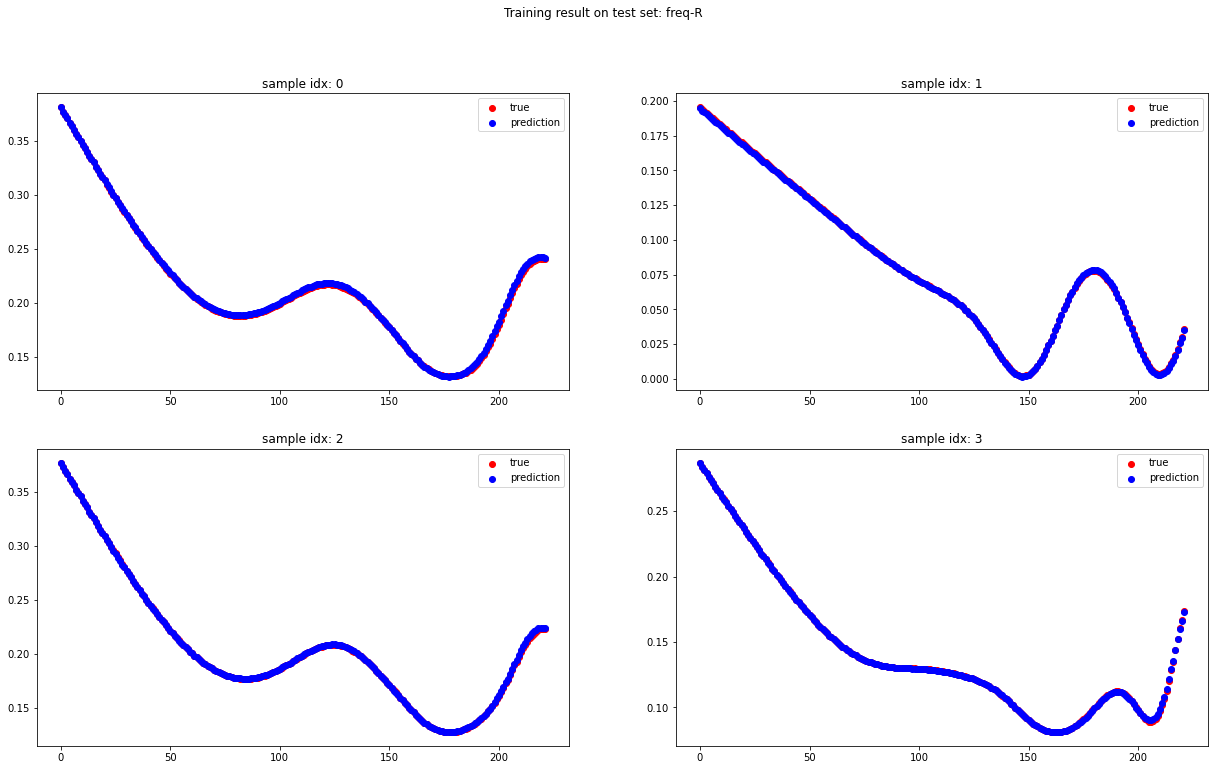

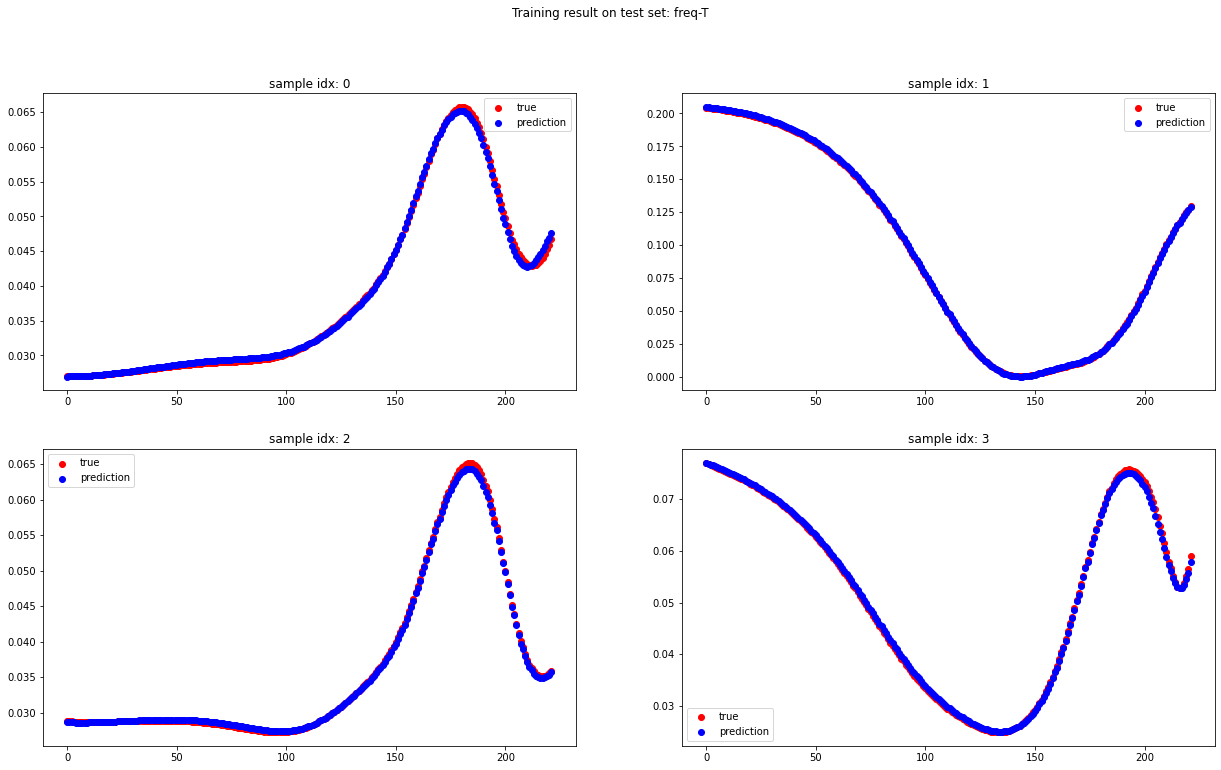

pseudo_params.shape: (10201, 4)
params_pick.shape: (10, 4)
params_pick: [[146. 121. 160.  75.]
 [146. 120. 160.  75.]
 [146. 122. 160.  75.]
 [147. 120. 160.  75.]
 [147. 121. 160.  75.]
 [146. 123. 160.  75.]
 [146. 119. 160.  75.]
 [147. 122. 160.  75.]
 [145. 122. 160.  75.]
 [145. 121. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


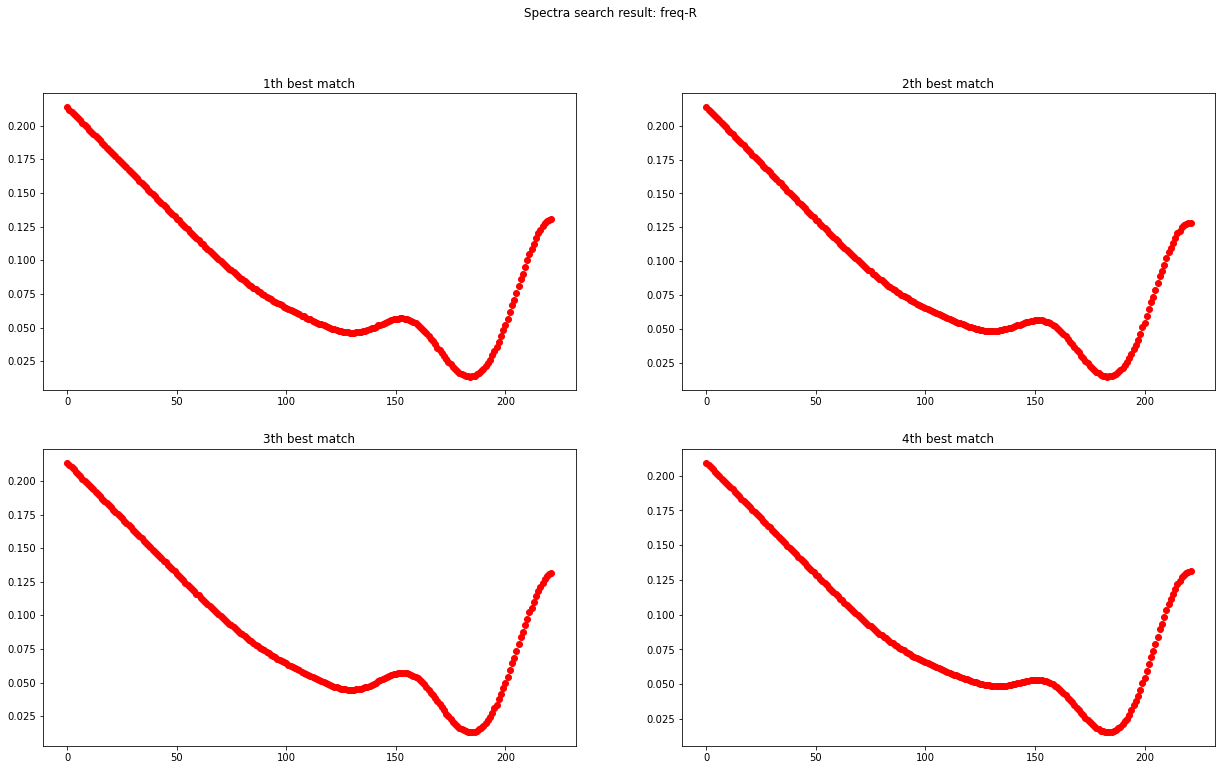

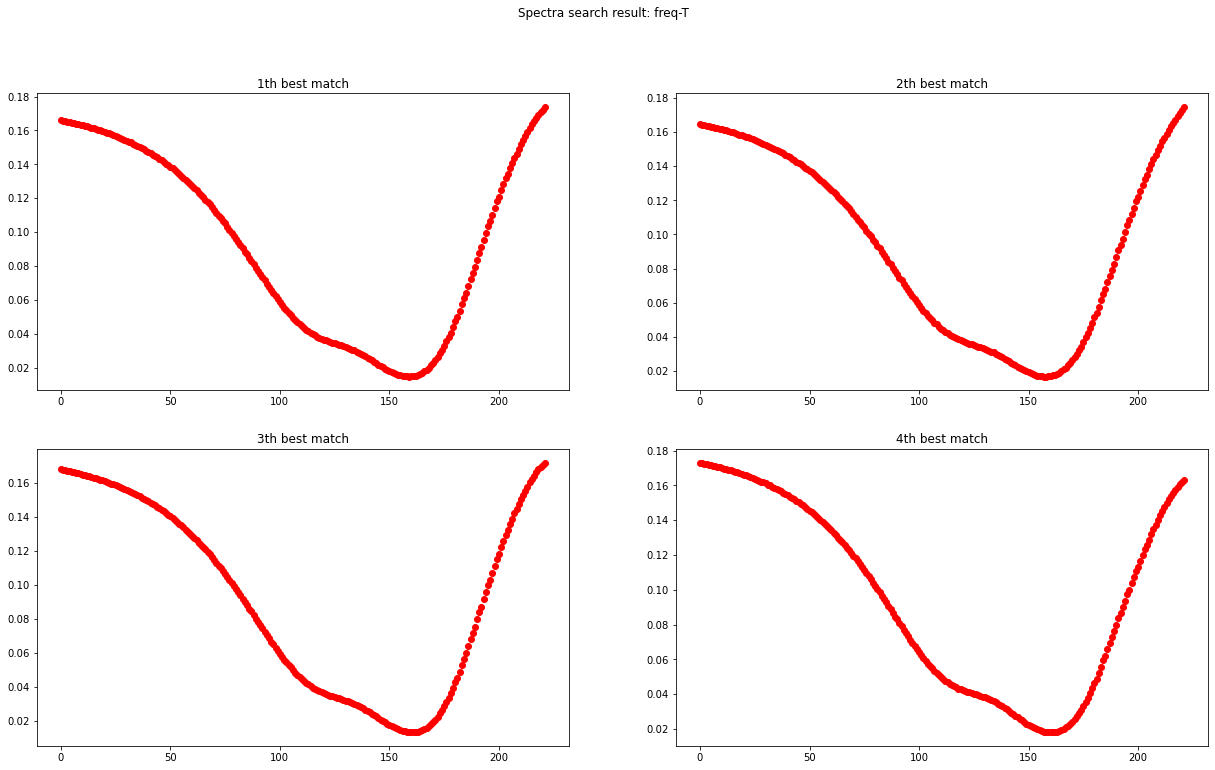

*** Reruning RCWA on picked params
params_dict.shape: (1017, 4)
R_dict.shape: (1017, 222)
T_dict.shape: (1017, 222)
--------------------
1 th match
Already in the dict.
# params_dict: [146. 121. 160.  75.] params_pick: [146. 121. 160.  75.]
--------------------
2 th match
Already in the dict.
# params_dict: [146. 120. 160.  75.] params_pick: [146. 120. 160.  75.]
--------------------
3 th match
Already in the dict.
# params_dict: [146. 122. 160.  75.] params_pick: [146. 122. 160.  75.]
--------------------
4 th match
Already in the dict.
# params_dict: [147. 120. 160.  75.] params_pick: [147. 120. 160.  75.]
--------------------
5 th match
Already in the dict.
# params_dict: [147. 121. 160.  75.] params_pick: [147. 121. 160.  75.]
--------------------
6 th match
Already in the dict.
# params_dict: [146. 123. 160.  75.] params_pick: [146. 123. 160.  75.]
--------------------
7 th match
Not in the dict, calling RCWA...
# params_pick: [146. 119. 160.  75.]
Freq truncate.
freq.shape: (222,

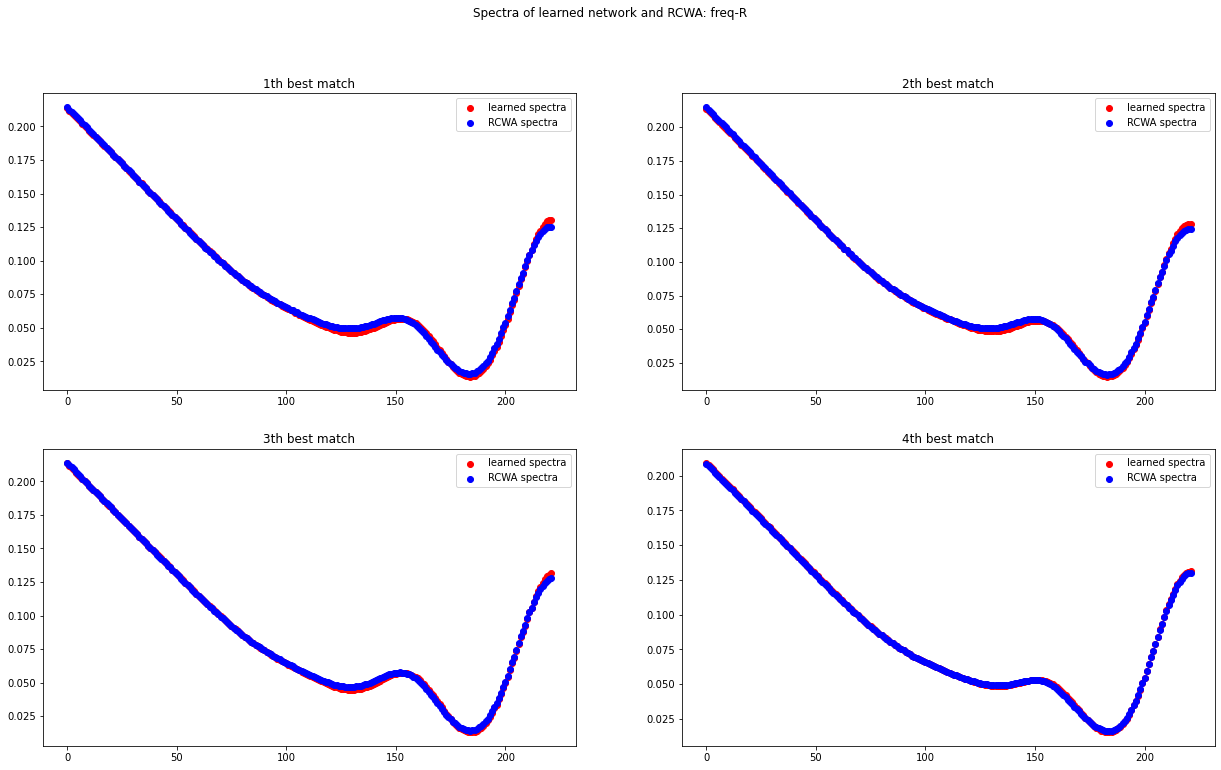

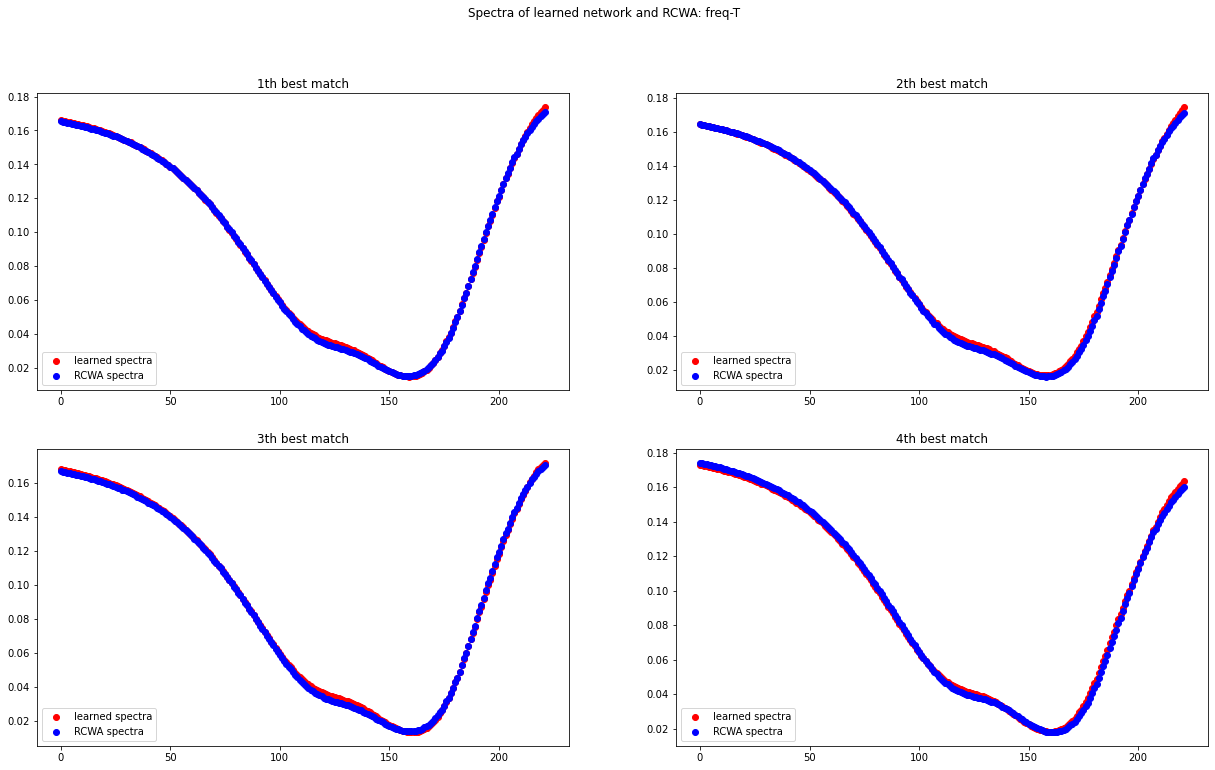

** Model saved.
**************************** ROUND 6 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 1200
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [149.  93.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [142.  78.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [ 91. 101.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [ 97. 116.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [74. 91.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [119.  79.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [119.  74.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [150. 107.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [133.  72.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [130.  68.]
Calculation

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [51. 67.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [139. 143.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [ 87. 125.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [ 83. 143.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [50. 80.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [65. 58.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [99. 86.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [ 94. 115.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [ 86. 121.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [141. 112.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [109.  58.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [ 73. 127.]
Calculation Progress: 100%
---------

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 5.9463326189851764e-05
### TEST LOSS  0.00013682158169103786
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 2.8124042491815734e-05
### TEST LOSS  6.2437219033502816e-06
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 1.1006151872419896e-05
### TEST LOSS  6.851425031426415e-05
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 1.6092162804994815e-05
### TEST LOSS  5.248431749451912e-06
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 7.963064190713945e-06
### TEST LOSS  3.0588501418707083e-06
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 4.174429702932988e-06
### TEST LOSS  4.08157927722641e-06
----------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 2.9320905091504793e-06
### TEST LOSS  3.4164639828304644e-06
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 1.7626882219268224e-06
### TEST LOSS  1.7676725860837905e-06
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 1.5534673444328463e-06
### TEST LOSS  3.82884566837068e-06
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 1.456913144573709e-06
### TEST LOSS  8.367470374853131e-07
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 1.12324117200302e-06
### TEST LOSS  7.788573176033727e-07
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 1.0218654647727494e-06
### TEST LOSS  7.151499469652359e-07
------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 2.991278544222098e-06
### TEST LOSS  1.3614395268430396e-06
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 1.4504156620276376e-06
### TEST LOSS  9.96000684002259e-07
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 1.2366309511158136e-06
### TEST LOSS  1.1180293250213758e-06
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 1.1585866464377166e-06
### TEST LOSS  8.28679522631622e-07
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 1.5089863269501791e-06
### TEST LOSS  1.0096404549939407e-06
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 9.214847793082014e-07
### TEST LOSS  1.1124818747197828e-06
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 8.717795094170811e-07
### TEST LOSS  6.185381143571552e-07
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 9.885642129425776e-07
### TEST LOSS  7.603208081895395e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 7.270171344024116e-07
### TEST LOSS  5.884838477262141e-07
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 8.123761108021673e-07
### TEST LOSS  5.533647993161139e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 7.344996226491911e-07
### TEST LOSS  5.069250714010801e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 6.941484821905892e-07
### TEST LOSS  5.258851432346192e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 5.433093877460493e-07
### TEST LOSS  5.524988198304628e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 5.281815728756338e-07
### TEST LOSS  4.5524088123885224e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 6.32368990656218e-07
### TEST LOSS  6.033627926171903e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 6.000086787860681e-07
### TEST LOSS  9.874518253935903e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 6.519686675036477e-07
### TEST LOSS  5.488068508283403e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 6.747744525685088e-07
### TEST LOSS  4.784376920320533e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 5.622482561070304e-07
### TEST LOSS  3.662478731156524e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 5.485077260540076e-07
### TEST LOSS  6.16110598785882e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 5.721091671547403e-07
### TEST LOSS  6.842138336398623e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 5.396516622428275e-07
### TEST LOSS  4.650577396761138e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 5.054521722798928e-07
### TEST LOSS  1.2129747043824561e-06
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 6.206317037094067e-07
### TEST LOSS  5.890650606311788e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 4.919440319284263e-07
### TEST LOSS  7.840398868413306e-07
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 5.252079268203147e-07
### TEST LOSS  4.3075656542946996e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 4.980720583969145e-07
### TEST LOSS  3.4658733877929785e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 6.422130534181984e-07
### TEST LOSS  5.35798537586945e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 6.657289995241437e-07
### TEST LOSS  6.966894577292098e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 4.822121634025697e-07
### TEST LOSS  3.868089351044546e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 5.478410282340936e-07
### TEST LOSS  3.504617783139313e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 5.322506690304725e-07
### TEST LOSS  3.5362232450905947e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 5.731526955295626e-07
### TEST LOSS  1.5264903936440533e-06
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 5.385441209663592e-07
### TEST LOSS  4.770292858009068e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 4.5984160180978505e-07
### TEST LOSS  3.7300590981380486e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 4.4957412965137185e-07
### TEST LOSS  3.037645023419423e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 4.4804759212387544e-07
### TEST LOSS  4.632192924544951e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 5.119471171788348e-07
### TEST LOSS  9.179843390130474e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 5.126901371651134e-07
### TEST LOSS  4.4377413467423645e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 4.5735644232417864e-07
### TEST LOSS  4.606866544539419e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 4.691559661621862e-07
### TEST LOSS  5.07090774704011e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 4.888969441137666e-07
### TEST LOSS  5.641468384788418e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 4.242783756029193e-07
### TEST LOSS  3.163081569507792e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 4.812063963832714e-07
### TEST LOSS  3.331410675223702e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 4.800433785619637e-07
### TEST LOSS  3.797551357820339e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 4.797857351294492e-07
### TEST LOSS  3.759669971891021e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 4.6136166347743313e-07
### TEST LOSS  3.3332485334843415e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 4.2353529661198763e-07
### TEST LOSS  7.513117642095798e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 4.506445312320769e-07
### TEST LOSS  3.958288709150616e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 4.7683268612708217e-07
### TEST LOSS  2.9884348783247737e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 3.9605121437820875e-07
### TEST LOSS  6.163620630180352e-07
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 4.2862175224348914e-07
### TEST LOSS  3.493163565811604e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 3.8560734314962987e-07
### TEST LOSS  4.170734623837941e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 4.995047790619841e-07
### TEST LOSS  3.6968496728049e-07
-------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 4.3693107364184415e-07
### TEST LOSS  3.563109234821443e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 4.221975332926083e-07
### TEST LOSS  3.1905102638852946e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 4.248374716849431e-07
### TEST LOSS  2.867692074914885e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 3.932470820000589e-07
### TEST LOSS  3.426898729230743e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 5.280423840403614e-07
### TEST LOSS  2.652433855764179e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 3.9925408042170336e-07
### TEST LOSS  3.31992795723737e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 4.5285949220819075e-07
### TEST LOSS  5.222707765521287e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 4.3733751924198336e-07
### TEST LOSS  4.827873820229595e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 4.552187940021213e-07
### TEST LOSS  1.3796731082038605e-06
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 4.4683590370908634e-07
### TEST LOSS  3.5581723917883005e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 4.59070088405511e-07
### TEST LOSS  3.184800602993063e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 4.0640177926931644e-07
### TEST LOSS  3.044091485548961e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 3.751478835460157e-07
### TEST LOSS  5.00781069945333e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 4.1450570138046316e-07
### TEST LOSS  5.183063744122288e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 4.6001706258754403e-07
### TEST LOSS  3.326520451688945e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 4.018393456354611e-07
### TEST LOSS  3.0820008115976333e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 4.273009557535327e-07
### TEST LOSS  4.0231304865301354e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 4.7554573437302847e-07
### TEST LOSS  4.059782238780624e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 5.40382571116993e-07
### TEST LOSS  3.7609911866335705e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 4.0889452133985317e-07
### TEST LOSS  2.6065972728398873e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 3.616341373380294e-07
### TEST LOSS  3.642247589949774e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 3.8477609176486756e-07
### TEST LOSS  3.2509576265561515e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 4.118256902341244e-07
### TEST LOSS  2.5623409053802487e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 3.792586004506641e-07
### TEST LOSS  6.674189986850049e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 3.74185195465652e-07
### TEST LOSS  3.1067656180994163e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 3.9542876181760294e-07
### TEST LOSS  5.865129395488111e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 4.1592615878253507e-07
### TEST LOSS  2.744776534452992e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 3.6983621173547474e-07
### TEST LOSS  8.567570672665978e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 3.7721355783837395e-07
### TEST LOSS  2.3554957095939244e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 3.8673845327075184e-07
### TEST LOSS  2.906363323834032e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 3.4353338572046256e-07
### TEST LOSS  5.87380635389915e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 3.760296730526136e-07
### TEST LOSS  2.3114655631515132e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 3.5291185777275304e-07
### TEST LOSS  3.5210930743940276e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 3.8964658968095495e-07
### TEST LOSS  2.7821042181130906e-07
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 3.7122679416542086e-07
### TEST LOSS  3.406672727616448e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 3.4792357584597273e-07
### TEST LOSS  3.1206005009683696e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 4.0724489286307157e-07
### TEST LOSS  5.797738096033653e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 3.567867293489494e-07
### TEST LOSS  3.422123329402085e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 3.502936496098859e-07
### TEST LOSS  2.396672845369115e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 4.0064386883938617e-07
### TEST LOSS  4.397886657317132e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 3.7769256879371936e-07
### TEST LOSS  2.494095312499667e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 3.65090076333748e-07
### TEST LOSS  2.817399007426502e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 3.3460114766015183e-07
### TEST LOSS  3.0065805292325524e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 3.4359121758124427e-07
### TEST LOSS  3.9378205150973776e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 3.68198017396774e-07
### TEST LOSS  2.9186165780477796e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 3.607592466596069e-07
### TEST LOSS  3.2995232620199505e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 3.4507707468378613e-07
### TEST LOSS  4.2849452420846825e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 3.8023953064403315e-07
### TEST LOSS  2.716403741942486e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 3.832339593505078e-07
### TEST LOSS  2.774958581931565e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 3.2580502590917603e-07
### TEST LOSS  2.507077930936753e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 3.9328405492848144e-07
### TEST LOSS  4.96340746281021e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 3.891002135455087e-07
### TEST LOSS  3.9135706389162e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 3.8375216979839405e-07
### TEST LOSS  3.3596253325009053e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 3.5606175700605056e-07
### TEST LOSS  2.4923712752903765e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 3.4827568176668917e-07
### TEST LOSS  3.8755026170949554e-07
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 3.784648775514062e-07
### TEST LOSS  3.2436688554879663e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 3.5081645220517526e-07
### TEST LOSS  3.155667861341903e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 3.3824912522166053e-07
### TEST LOSS  3.081285374011916e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 3.4055117599981105e-07
### TEST LOSS  2.7235358067577585e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 3.574338923624983e-07
### TEST LOSS  3.2156639583212785e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1112 || AVG LOSS 3.5170478105417404e-07
### TEST LOSS  4.253061421069207e-07
----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 3.389867634240318e-07
### TEST LOSS  2.518609273730969e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 3.463192956350743e-07
### TEST LOSS  5.003785111688962e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 3.452625405545954e-07
### TEST LOSS  2.7408042768684027e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 3.5123237722256563e-07
### TEST LOSS  4.6745688722340776e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 3.399650477575733e-07
### TEST LOSS  3.6233159682473746e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1164 || AVG LOSS 3.1877092186475647e-07
### TEST LOSS  2.1536257419383117e-07
----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 3.3327034670183054e-07
### TEST LOSS  4.128858661387211e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 6.018211360429386e-07
### TEST LOSS  6.175107042988909e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 4.0538992795842906e-07
### TEST LOSS  2.646296384985665e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 3.4512525121913976e-07
### TEST LOSS  2.94347212085692e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 3.5921653508038294e-07
### TEST LOSS  6.201743695378859e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1216 || AVG LOSS 3.2668424814937443e-07
### TEST LOSS  3.563854562571578e-07
----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 3.8342106666237424e-07
### TEST LOSS  3.973808051998478e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 3.928734965012263e-07
### TEST LOSS  5.492561601588225e-07
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 3.602623495050731e-07
### TEST LOSS  3.168359378315068e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 3.494588944278713e-07
### TEST LOSS  3.8036038397927365e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 3.305810949486935e-07
### TEST LOSS  2.670864442203917e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1268 || AVG LOSS 3.054084581233241e-07
### TEST LOSS  2.4809017418192525e-07
----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 3.5164994311109865e-07
### TEST LOSS  2.1593028599732457e-07
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 3.299073596352287e-07
### TEST LOSS  4.0696706883459734e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 3.614346400630334e-07
### TEST LOSS  2.62537179354341e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 3.43217714355859e-07
### TEST LOSS  1.8064852014276767e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 3.135194185155399e-07
### TEST LOSS  2.62577197121219e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1320 || AVG LOSS 3.3422729105225814e-07
### TEST LOSS  2.885941488746842e-07
----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 3.272546625998629e-07
### TEST LOSS  2.3390596245083847e-07
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 3.12015449726033e-07
### TEST LOSS  3.164745976391714e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 3.0910794460048405e-07
### TEST LOSS  5.837311947390036e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 3.4445401524270855e-07
### TEST LOSS  6.932286061732561e-07
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 3.8003768403349626e-07
### TEST LOSS  4.805596537001596e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1372 || AVG LOSS 3.197258801934666e-07
### TEST LOSS  3.7380610251602775e-07
----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 3.541909046604156e-07
### TEST LOSS  2.5816842155437473e-07
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 3.0952081293852036e-07
### TEST LOSS  2.4835246787486335e-07
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 3.810554863529584e-07
### TEST LOSS  2.2549644443061982e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 3.392078735335128e-07
### TEST LOSS  3.114941264925619e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 3.865933065760885e-07
### TEST LOSS  2.731414675673073e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1424 || AVG LOSS 3.302254626369461e-07
### TEST LOSS  2.994348686039909e-07
----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 3.20745797803094e-07
### TEST LOSS  2.967571243554327e-07
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 3.661643058953482e-07
### TEST LOSS  2.489021887362873e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 3.3181097720251054e-07
### TEST LOSS  2.7259240593164373e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 3.303131508077447e-07
### TEST LOSS  3.034434096586362e-07
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 3.1207805719931275e-07
### TEST LOSS  5.617301484208939e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1476 || AVG LOSS 3.0662686889707894e-07
### TEST LOSS  3.269361615012814e-07
----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 3.690593429113894e-07
### TEST LOSS  3.1392147390205435e-07
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 3.3645677365671627e-07
### TEST LOSS  2.612835380154542e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 3.8065874549057334e-07
### TEST LOSS  3.325523544440835e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 3.140976364039242e-07
### TEST LOSS  2.9764523487882696e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 3.5691369502247977e-07
### TEST LOSS  2.455939578125152e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1528 || AVG LOSS 4.300450920850333e-07
### TEST LOSS  3.394303433879031e-07
----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 3.307472247993104e-07
### TEST LOSS  3.755441547860351e-07
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 3.901703069756716e-07
### TEST LOSS  2.9274038995355215e-07
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 3.603544423243695e-07
### TEST LOSS  2.622827197898106e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 3.0398873722544315e-07
### TEST LOSS  2.541692501899383e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 3.809167366745451e-07
### TEST LOSS  2.5634828659804043e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1580 || AVG LOSS 3.257911429847364e-07
### TEST LOSS  2.418071874090957e-07
----------------------------------------------------------------------
*** EPOCH 1581 || AVG LOSS 3.5484048737099983e-07
### TEST LOSS  5.16592771128267e-07
----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 3.646858297123856e-07
### TEST LOSS  5.176615205628979e-07
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 3.13786837371488e-07
### TEST LOSS  3.8103137790636134e-07
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 3.5971386477484655e-07
### TEST LOSS  2.4192382694663036e-07
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 3.791027096866628e-07
### TEST LOSS  2.1992130427861412e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1632 || AVG LOSS 3.2493537583574057e-07
### TEST LOSS  3.1431718778347e-07
----------------------------------------------------------------------
*** EPOCH 1633 || AVG LOSS 3.106797202760229e-07
### TEST LOSS  2.0950362195688083e-07
----------------------------------------------------------------------
*** EPOCH 1634 || AVG LOSS 2.8759225159250924e-07
### TEST LOSS  2.627240663047006e-07
----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 3.2255319268870155e-07
### TEST LOSS  2.699794134425954e-07
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 3.480440476770023e-07
### TEST LOSS  4.76055415927274e-07
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 3.320336378331845e-07
### TEST LOSS  2.3812879372068588e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1684 || AVG LOSS 2.944025449573099e-07
### TEST LOSS  3.845515313590416e-07
----------------------------------------------------------------------
*** EPOCH 1685 || AVG LOSS 3.1455405031799443e-07
### TEST LOSS  2.766626813076477e-07
----------------------------------------------------------------------
*** EPOCH 1686 || AVG LOSS 3.1390112653628677e-07
### TEST LOSS  2.913444569053859e-07
----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 3.184781575053345e-07
### TEST LOSS  3.4669870293176547e-07
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 3.1679464110941545e-07
### TEST LOSS  2.1739665198891896e-07
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 2.8537854588487716e-07
### TEST LOSS  3.3228788096393043e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1736 || AVG LOSS 3.068097021833675e-07
### TEST LOSS  2.3745115937698654e-07
----------------------------------------------------------------------
*** EPOCH 1737 || AVG LOSS 3.787474170232249e-07
### TEST LOSS  3.4773952961586474e-07
----------------------------------------------------------------------
*** EPOCH 1738 || AVG LOSS 3.187772795302616e-07
### TEST LOSS  2.476793754782294e-07
----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 3.1919557565392626e-07
### TEST LOSS  3.2539857465331403e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 2.9079568576229064e-07
### TEST LOSS  2.421482131846157e-07
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 3.2027064237549754e-07
### TEST LOSS  2.2079549842778255e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1788 || AVG LOSS 3.0600335401883193e-07
### TEST LOSS  2.3181985634816252e-07
----------------------------------------------------------------------
*** EPOCH 1789 || AVG LOSS 2.8664836792202665e-07
### TEST LOSS  2.925745405946145e-07
----------------------------------------------------------------------
*** EPOCH 1790 || AVG LOSS 2.986278165373335e-07
### TEST LOSS  1.9925301428555838e-07
----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 3.6736435058859486e-07
### TEST LOSS  2.803577514340658e-07
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 3.375944744258656e-07
### TEST LOSS  2.4662180840727564e-07
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 3.052787980347323e-07
### TEST LOSS  6.293506468561342e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1840 || AVG LOSS 3.267706711884699e-07
### TEST LOSS  3.23206341098133e-07
----------------------------------------------------------------------
*** EPOCH 1841 || AVG LOSS 3.3591187904136177e-07
### TEST LOSS  2.69909845782321e-07
----------------------------------------------------------------------
*** EPOCH 1842 || AVG LOSS 2.942498486987096e-07
### TEST LOSS  3.8064575846874504e-07
----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 3.152299184083773e-07
### TEST LOSS  4.047641068735983e-07
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 3.428202364297306e-07
### TEST LOSS  3.987174150350054e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 3.1845273382439627e-07
### TEST LOSS  2.2087838955384439e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1892 || AVG LOSS 2.7673132337054557e-07
### TEST LOSS  6.147559727449132e-07
----------------------------------------------------------------------
*** EPOCH 1893 || AVG LOSS 3.134755927280963e-07
### TEST LOSS  2.3450728055725753e-07
----------------------------------------------------------------------
*** EPOCH 1894 || AVG LOSS 3.2188080208920646e-07
### TEST LOSS  2.580236626828183e-07
----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 3.2349109057546363e-07
### TEST LOSS  1.978252370804512e-07
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 3.4525653708280165e-07
### TEST LOSS  2.3679306259004483e-07
----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 3.0709796399186474e-07
### TEST LOSS  2.0900464805764488e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1944 || AVG LOSS 3.299143928758852e-07
### TEST LOSS  2.553113828993345e-07
----------------------------------------------------------------------
*** EPOCH 1945 || AVG LOSS 3.36700430357458e-07
### TEST LOSS  2.5774141694986e-07
----------------------------------------------------------------------
*** EPOCH 1946 || AVG LOSS 2.738954068881583e-07
### TEST LOSS  2.0194967002377476e-07
----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 2.9112987873632555e-07
### TEST LOSS  2.2647108642735878e-07
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 3.218610474379583e-07
### TEST LOSS  2.8320581514486145e-07
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 2.731422184106454e-07
### TEST LOSS  2.1055691866599267e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1996 || AVG LOSS 2.8953462561413327e-07
### TEST LOSS  2.2563835876275738e-07
----------------------------------------------------------------------
*** EPOCH 1997 || AVG LOSS 2.9941940605867263e-07
### TEST LOSS  3.9345121491704856e-07
----------------------------------------------------------------------
*** EPOCH 1998 || AVG LOSS 2.9290962069457765e-07
### TEST LOSS  2.8218046487103896e-07
----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 3.395473116718506e-07
### TEST LOSS  2.7762897600622534e-07
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 3.0300075851918964e-07
### TEST LOSS  4.293936923558148e-07
** loss_train 3.0300075851918964e-07
** loss_test 4.293936923558148e-07
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


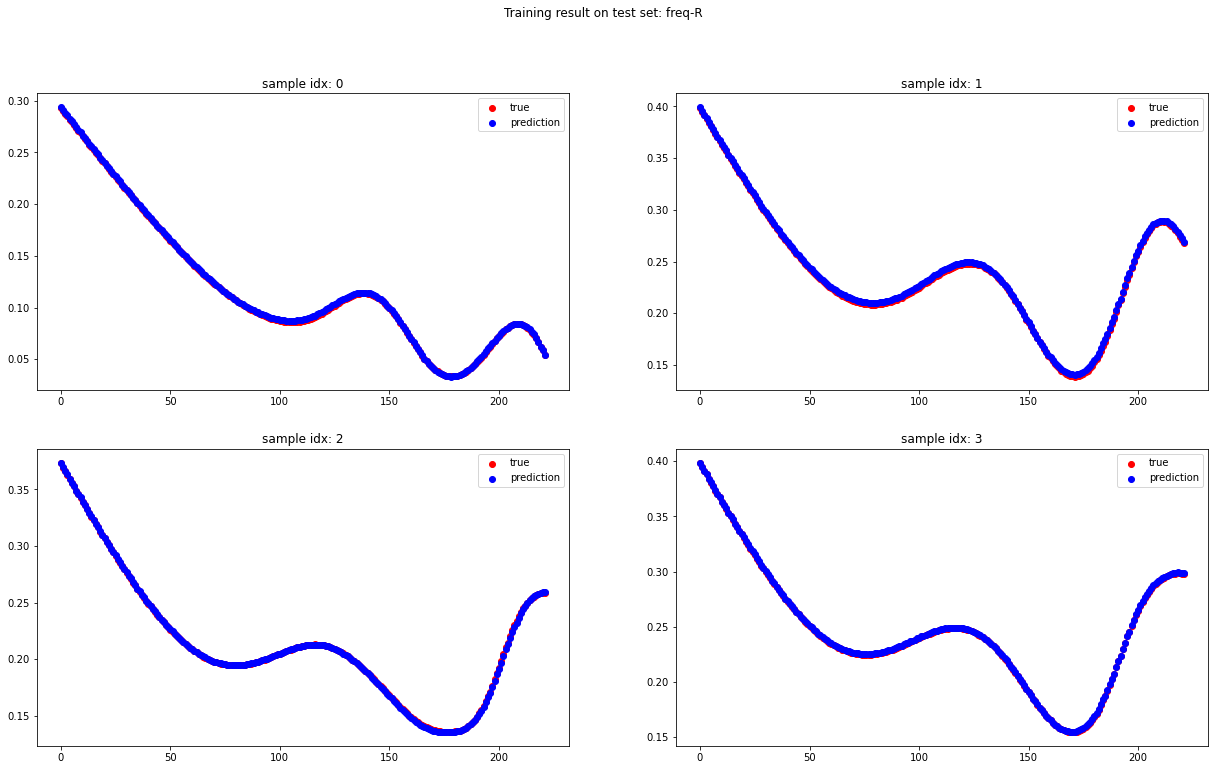

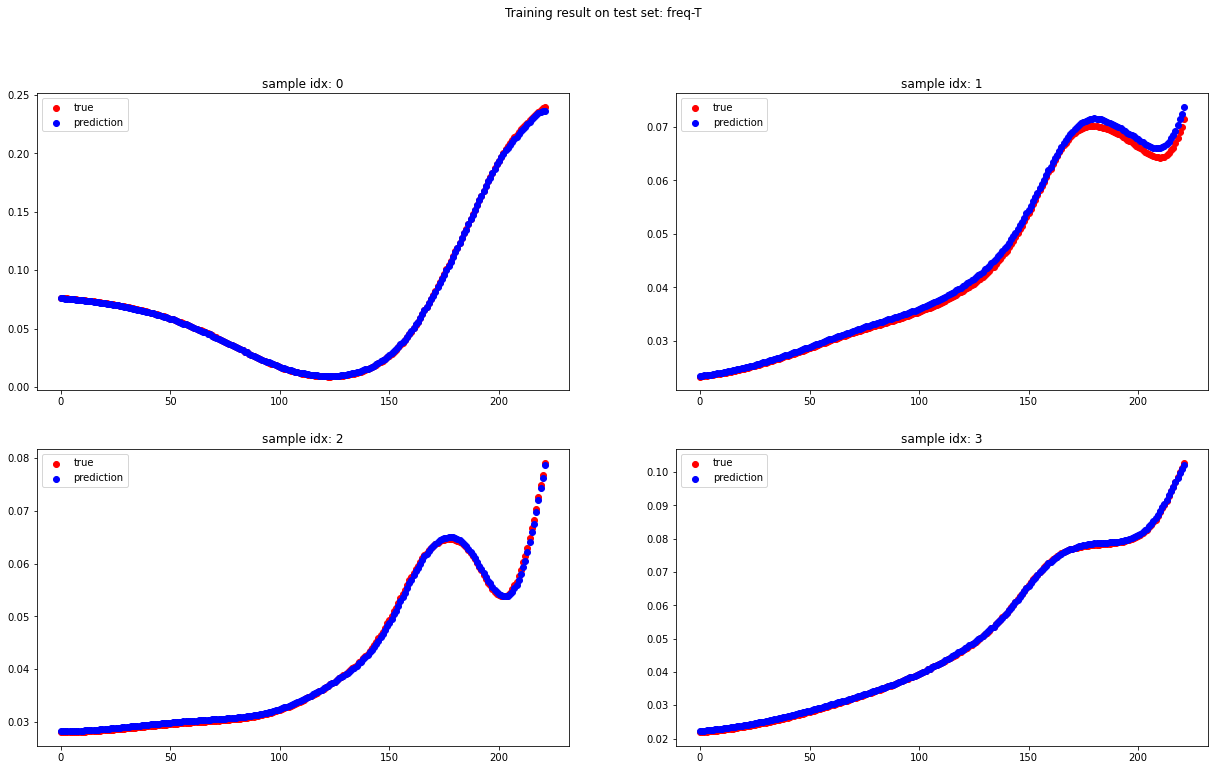

pseudo_params.shape: (10201, 4)
params_pick.shape: (10, 4)
params_pick: [[146. 123. 160.  75.]
 [146. 122. 160.  75.]
 [146. 121. 160.  75.]
 [147. 122. 160.  75.]
 [147. 121. 160.  75.]
 [147. 120. 160.  75.]
 [147. 123. 160.  75.]
 [145. 123. 160.  75.]
 [146. 120. 160.  75.]
 [145. 122. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


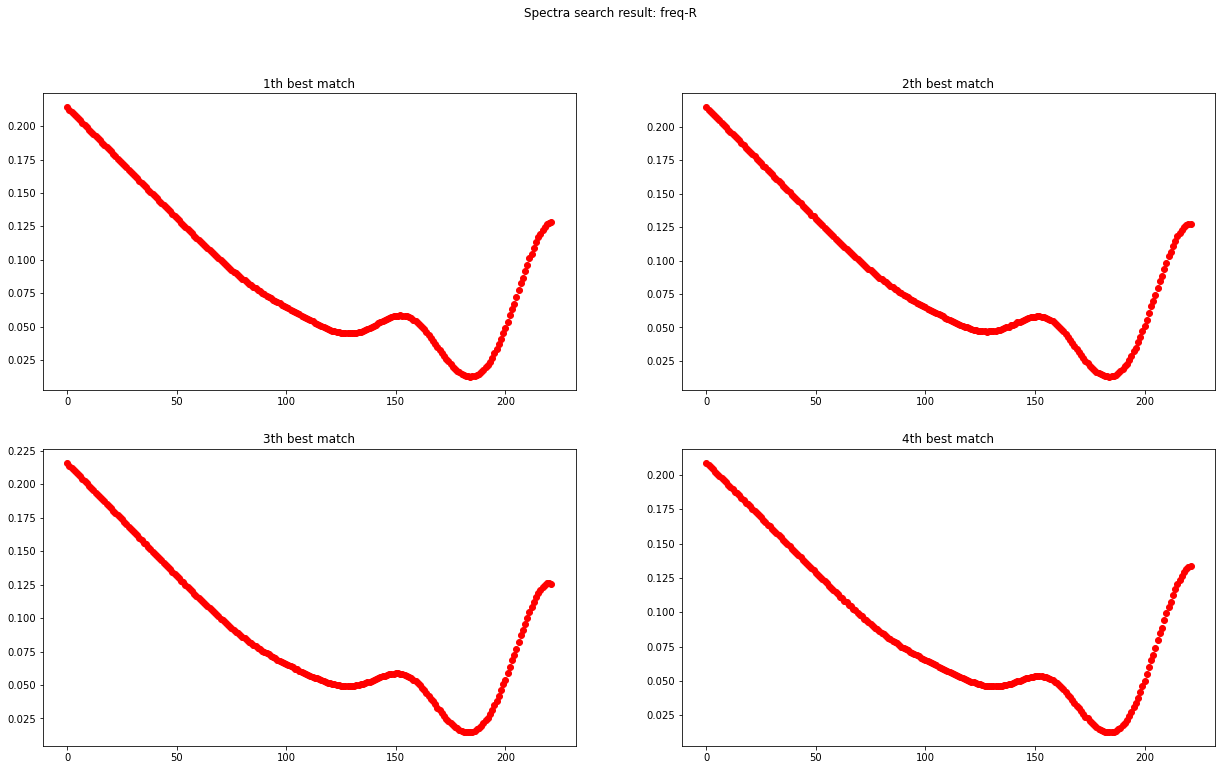

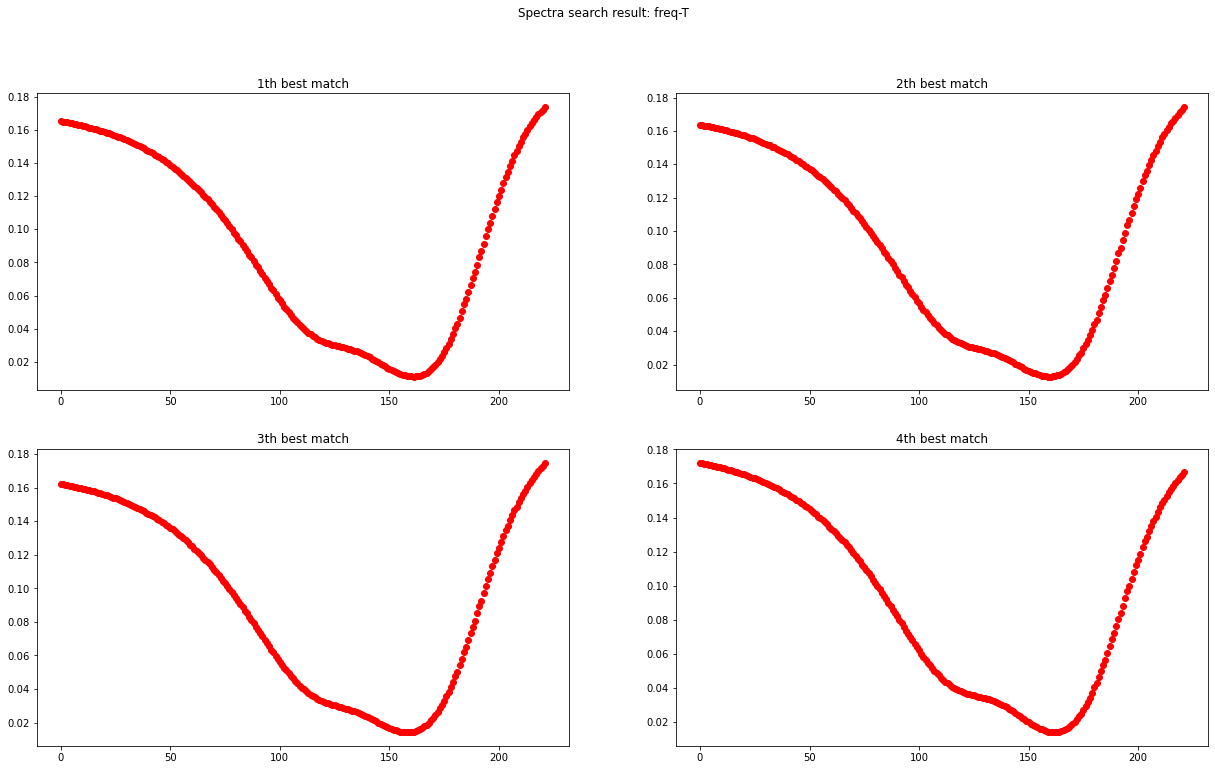

*** Reruning RCWA on picked params
params_dict.shape: (1218, 4)
R_dict.shape: (1218, 222)
T_dict.shape: (1218, 222)
--------------------
1 th match
Already in the dict.
# params_dict: [146. 123. 160.  75.] params_pick: [146. 123. 160.  75.]
--------------------
2 th match
Already in the dict.
# params_dict: [146. 122. 160.  75.] params_pick: [146. 122. 160.  75.]
--------------------
3 th match
Already in the dict.
# params_dict: [146. 121. 160.  75.] params_pick: [146. 121. 160.  75.]
--------------------
4 th match
Already in the dict.
# params_dict: [147. 122. 160.  75.] params_pick: [147. 122. 160.  75.]
--------------------
5 th match
Already in the dict.
# params_dict: [147. 121. 160.  75.] params_pick: [147. 121. 160.  75.]
--------------------
6 th match
Already in the dict.
# params_dict: [147. 120. 160.  75.] params_pick: [147. 120. 160.  75.]
--------------------
7 th match
Already in the dict.
# params_dict: [147. 123. 160.  75.] params_pick: [147. 123. 160.  75.]
---------

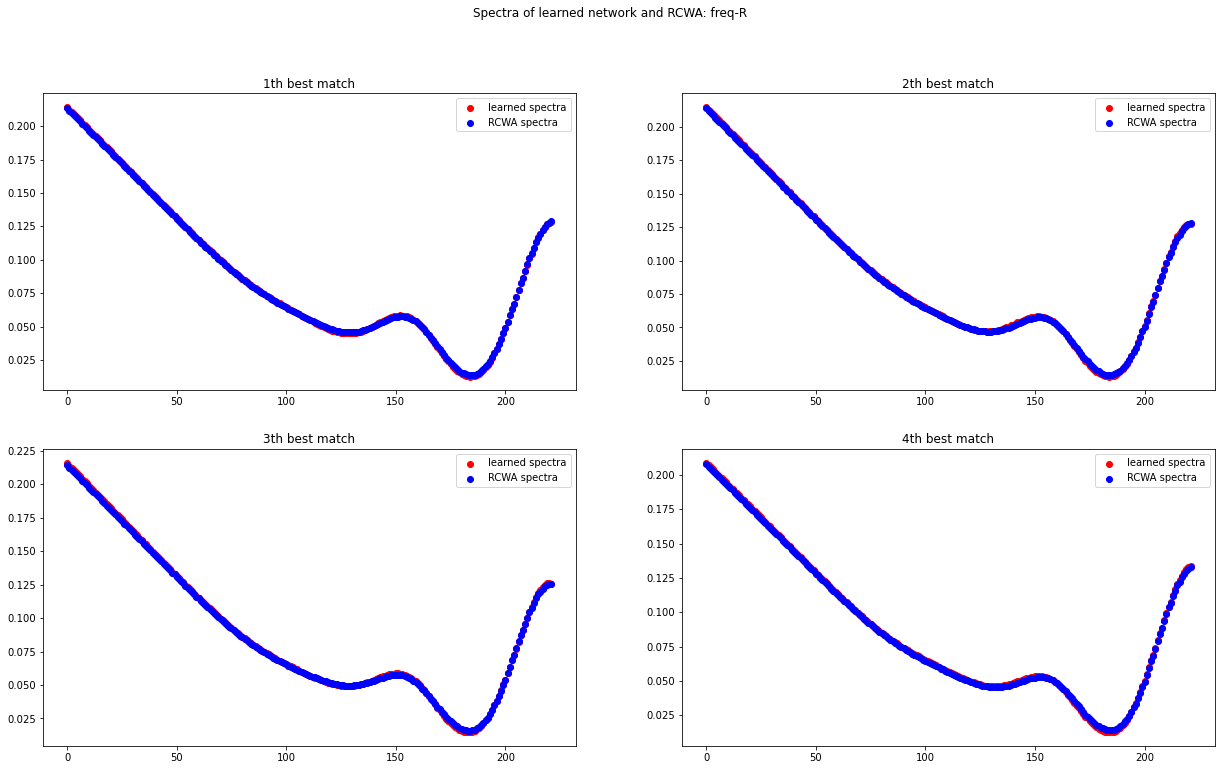

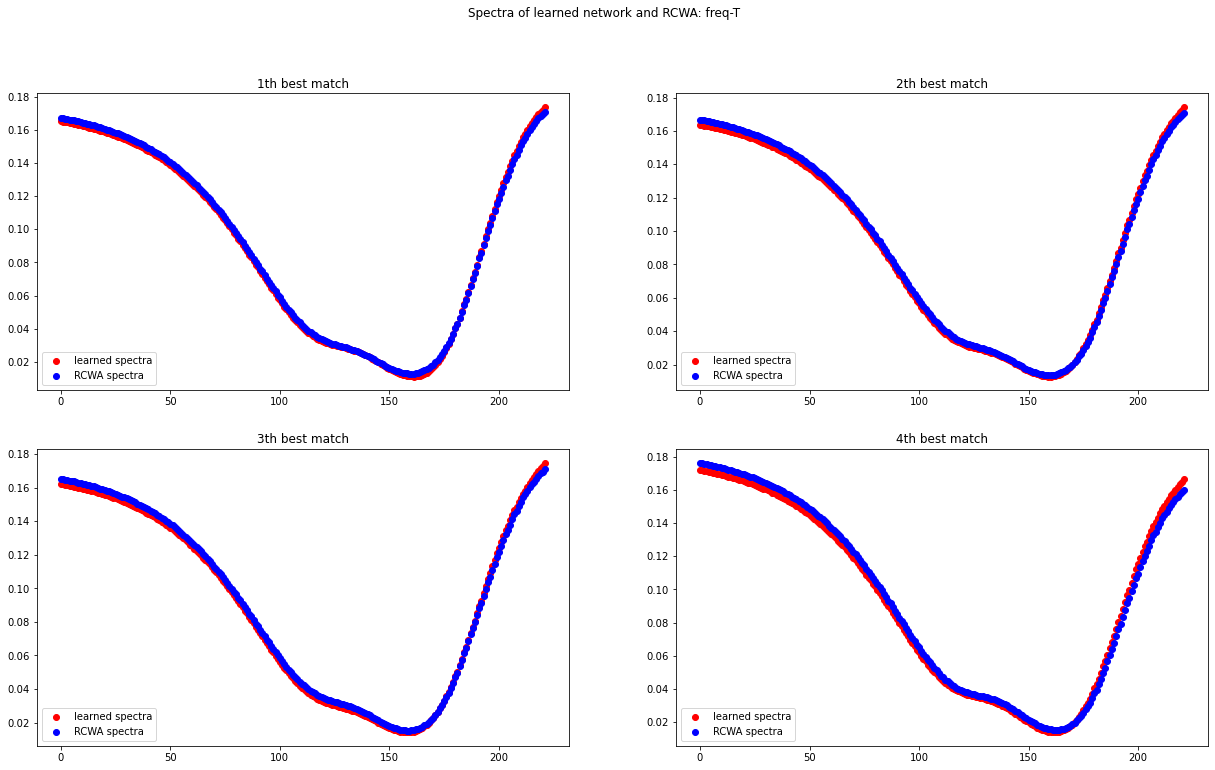

** Model saved.
**************************** ROUND 7 ****************************
Freq truncate.
freq.shape: (222,)
N_possible: [100, 100] , 10000 in total
N_needed: 1400
Sample points number available, continue calculating...
----------------
[ 1 / 200 ] [D1, D2] = [126.  81.]
Calculation Progress: 100%
----------------
[ 2 / 200 ] [D1, D2] = [ 81. 124.]
Calculation Progress: 100%
----------------
[ 3 / 200 ] [D1, D2] = [87. 95.]
Calculation Progress: 100%
----------------
[ 4 / 200 ] [D1, D2] = [138.  98.]
Calculation Progress: 100%
----------------
[ 5 / 200 ] [D1, D2] = [143.  98.]
Calculation Progress: 100%
----------------
[ 6 / 200 ] [D1, D2] = [ 90. 134.]
Calculation Progress: 100%
----------------
[ 7 / 200 ] [D1, D2] = [ 93. 134.]
Calculation Progress: 100%
----------------
[ 8 / 200 ] [D1, D2] = [141.  83.]
Calculation Progress: 100%
----------------
[ 9 / 200 ] [D1, D2] = [117.  80.]
Calculation Progress: 100%
----------------
[ 10 / 200 ] [D1, D2] = [131. 129.]
Calculation

Calculation Progress: 100%
----------------
[ 102 / 200 ] [D1, D2] = [60. 74.]
Calculation Progress: 100%
----------------
[ 103 / 200 ] [D1, D2] = [100.  84.]
Calculation Progress: 100%
----------------
[ 104 / 200 ] [D1, D2] = [116. 107.]
Calculation Progress: 100%
----------------
[ 105 / 200 ] [D1, D2] = [ 58. 146.]
Calculation Progress: 100%
----------------
[ 106 / 200 ] [D1, D2] = [132. 102.]
Calculation Progress: 100%
----------------
[ 107 / 200 ] [D1, D2] = [60. 91.]
Calculation Progress: 100%
----------------
[ 108 / 200 ] [D1, D2] = [148.  71.]
Calculation Progress: 100%
----------------
[ 109 / 200 ] [D1, D2] = [ 82. 121.]
Calculation Progress: 100%
----------------
[ 110 / 200 ] [D1, D2] = [85. 50.]
Calculation Progress: 100%
----------------
[ 111 / 200 ] [D1, D2] = [95. 70.]
Calculation Progress: 100%
----------------
[ 112 / 200 ] [D1, D2] = [139.  79.]
Calculation Progress: 100%
----------------
[ 113 / 200 ] [D1, D2] = [72. 67.]
Calculation Progress: 100%
-----------

----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 4.269852882227302e-05
### TEST LOSS  0.00020400883758239533
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 2.3454614175700985e-05
### TEST LOSS  1.6228682935351653e-05
----------------------------------------------------------------------
*** EPOCH 3 || AVG LOSS 1.3005108441197828e-05
### TEST LOSS  1.6391544746015413e-05
----------------------------------------------------------------------
*** EPOCH 4 || AVG LOSS 1.645906620341618e-05
### TEST LOSS  1.6479273571431722e-05
----------------------------------------------------------------------
*** EPOCH 5 || AVG LOSS 6.737502861682287e-06
### TEST LOSS  6.6109602440436985e-06
----------------------------------------------------------------------
*** EPOCH 6 || AVG LOSS 6.9455041308279825e-06
### TEST LOSS  2.4836103927389725e-06
-------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 54 || AVG LOSS 1.3469656651261224e-06
### TEST LOSS  1.6576042608820982e-06
----------------------------------------------------------------------
*** EPOCH 55 || AVG LOSS 1.3294859919201129e-06
### TEST LOSS  8.50627894909518e-07
----------------------------------------------------------------------
*** EPOCH 56 || AVG LOSS 1.1308741155196296e-06
### TEST LOSS  8.703084068367223e-07
----------------------------------------------------------------------
*** EPOCH 57 || AVG LOSS 1.1509580704682775e-06
### TEST LOSS  1.0746250996941276e-06
----------------------------------------------------------------------
*** EPOCH 58 || AVG LOSS 8.873641295790792e-07
### TEST LOSS  8.397475400298308e-07
----------------------------------------------------------------------
*** EPOCH 59 || AVG LOSS 1.058658941996019e-06
### TEST LOSS  1.0466147221615591e-06
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 107 || AVG LOSS 9.212685399262454e-07
### TEST LOSS  6.373158472880195e-07
----------------------------------------------------------------------
*** EPOCH 108 || AVG LOSS 7.392507755759376e-07
### TEST LOSS  8.366630507597702e-07
----------------------------------------------------------------------
*** EPOCH 109 || AVG LOSS 7.770066004399366e-07
### TEST LOSS  9.204194694492881e-07
----------------------------------------------------------------------
*** EPOCH 110 || AVG LOSS 8.295458394310831e-07
### TEST LOSS  8.590190454717892e-07
----------------------------------------------------------------------
*** EPOCH 111 || AVG LOSS 7.965466862737612e-07
### TEST LOSS  1.920681675280569e-06
----------------------------------------------------------------------
*** EPOCH 112 || AVG LOSS 7.985837856949729e-07
### TEST LOSS  8.069807093265395e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 160 || AVG LOSS 8.486442178958141e-07
### TEST LOSS  1.4270894904587872e-06
----------------------------------------------------------------------
*** EPOCH 161 || AVG LOSS 6.985375587729793e-07
### TEST LOSS  8.392046763364388e-07
----------------------------------------------------------------------
*** EPOCH 162 || AVG LOSS 7.83307339874893e-07
### TEST LOSS  1.384607256485734e-06
----------------------------------------------------------------------
*** EPOCH 163 || AVG LOSS 6.983407954511531e-07
### TEST LOSS  5.94394823462029e-07
----------------------------------------------------------------------
*** EPOCH 164 || AVG LOSS 7.3883492214171e-07
### TEST LOSS  5.3353157754414e-07
----------------------------------------------------------------------
*** EPOCH 165 || AVG LOSS 6.737747840038619e-07
### TEST LOSS  5.35656738520629e-07
----------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 213 || AVG LOSS 5.659916382657774e-07
### TEST LOSS  4.657947595309121e-07
----------------------------------------------------------------------
*** EPOCH 214 || AVG LOSS 5.969852458750527e-07
### TEST LOSS  5.534356003780968e-07
----------------------------------------------------------------------
*** EPOCH 215 || AVG LOSS 6.681794134014548e-07
### TEST LOSS  4.4896658899708863e-07
----------------------------------------------------------------------
*** EPOCH 216 || AVG LOSS 6.191120353956794e-07
### TEST LOSS  9.398203841018667e-07
----------------------------------------------------------------------
*** EPOCH 217 || AVG LOSS 6.299160162827531e-07
### TEST LOSS  5.342844892972856e-07
----------------------------------------------------------------------
*** EPOCH 218 || AVG LOSS 6.506494614352424e-07
### TEST LOSS  6.356967490587935e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 266 || AVG LOSS 6.874059571617051e-07
### TEST LOSS  4.865665087808421e-07
----------------------------------------------------------------------
*** EPOCH 267 || AVG LOSS 6.280553665836765e-07
### TEST LOSS  5.224065001191941e-07
----------------------------------------------------------------------
*** EPOCH 268 || AVG LOSS 5.505120686625073e-07
### TEST LOSS  8.188090005619002e-07
----------------------------------------------------------------------
*** EPOCH 269 || AVG LOSS 5.459055450453474e-07
### TEST LOSS  3.7320300288518576e-07
----------------------------------------------------------------------
*** EPOCH 270 || AVG LOSS 6.584976635589815e-07
### TEST LOSS  4.782655945622206e-07
----------------------------------------------------------------------
*** EPOCH 271 || AVG LOSS 5.594078598189104e-07
### TEST LOSS  4.357248060542092e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 319 || AVG LOSS 1.3918291598561235e-06
### TEST LOSS  1.3699461424659438e-06
----------------------------------------------------------------------
*** EPOCH 320 || AVG LOSS 1.3211028715634907e-06
### TEST LOSS  4.793242657735225e-07
----------------------------------------------------------------------
*** EPOCH 321 || AVG LOSS 7.271917619939522e-07
### TEST LOSS  5.492192307408252e-07
----------------------------------------------------------------------
*** EPOCH 322 || AVG LOSS 6.419095286526653e-07
### TEST LOSS  4.3563110097011304e-07
----------------------------------------------------------------------
*** EPOCH 323 || AVG LOSS 5.617211313132689e-07
### TEST LOSS  3.528188301515911e-07
----------------------------------------------------------------------
*** EPOCH 324 || AVG LOSS 5.649487828815073e-07
### TEST LOSS  3.876291249195095e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 372 || AVG LOSS 6.060324947958813e-07
### TEST LOSS  5.446329693499634e-07
----------------------------------------------------------------------
*** EPOCH 373 || AVG LOSS 6.516591338672535e-07
### TEST LOSS  5.095941769571833e-07
----------------------------------------------------------------------
*** EPOCH 374 || AVG LOSS 5.579943198392406e-07
### TEST LOSS  4.033176423945406e-07
----------------------------------------------------------------------
*** EPOCH 375 || AVG LOSS 5.229240344358946e-07
### TEST LOSS  6.147070001299487e-07
----------------------------------------------------------------------
*** EPOCH 376 || AVG LOSS 6.094268545656486e-07
### TEST LOSS  7.61362274075013e-07
----------------------------------------------------------------------
*** EPOCH 377 || AVG LOSS 6.077748416087405e-07
### TEST LOSS  4.903226960612467e-07
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 425 || AVG LOSS 4.818945816812255e-07
### TEST LOSS  6.474991306762686e-07
----------------------------------------------------------------------
*** EPOCH 426 || AVG LOSS 6.447512170788222e-07
### TEST LOSS  4.636866748342072e-07
----------------------------------------------------------------------
*** EPOCH 427 || AVG LOSS 5.417834250311314e-07
### TEST LOSS  6.372200532082801e-07
----------------------------------------------------------------------
*** EPOCH 428 || AVG LOSS 5.560971604572679e-07
### TEST LOSS  3.514107036876753e-07
----------------------------------------------------------------------
*** EPOCH 429 || AVG LOSS 4.939179915755939e-07
### TEST LOSS  4.762523718423753e-07
----------------------------------------------------------------------
*** EPOCH 430 || AVG LOSS 4.88669664167369e-07
### TEST LOSS  6.471071649436702e-07
-----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 478 || AVG LOSS 5.055831745361315e-07
### TEST LOSS  3.8959324590657407e-07
----------------------------------------------------------------------
*** EPOCH 479 || AVG LOSS 5.365783051709221e-07
### TEST LOSS  3.7926867949264226e-07
----------------------------------------------------------------------
*** EPOCH 480 || AVG LOSS 5.152750755981523e-07
### TEST LOSS  4.2854120284697605e-07
----------------------------------------------------------------------
*** EPOCH 481 || AVG LOSS 5.760740890866803e-07
### TEST LOSS  7.638395464420517e-07
----------------------------------------------------------------------
*** EPOCH 482 || AVG LOSS 4.867765266450671e-07
### TEST LOSS  3.6756407113939943e-07
----------------------------------------------------------------------
*** EPOCH 483 || AVG LOSS 5.552733205860249e-07
### TEST LOSS  4.474376489518115e-07
------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 531 || AVG LOSS 4.932747703583524e-07
### TEST LOSS  3.9991990196209703e-07
----------------------------------------------------------------------
*** EPOCH 532 || AVG LOSS 4.917785300482893e-07
### TEST LOSS  4.209890159307344e-07
----------------------------------------------------------------------
*** EPOCH 533 || AVG LOSS 5.673637808811804e-07
### TEST LOSS  1.463039263233606e-06
----------------------------------------------------------------------
*** EPOCH 534 || AVG LOSS 4.81448975526076e-07
### TEST LOSS  4.09823494413269e-07
----------------------------------------------------------------------
*** EPOCH 535 || AVG LOSS 5.302413766271132e-07
### TEST LOSS  9.6096486727633e-07
----------------------------------------------------------------------
*** EPOCH 536 || AVG LOSS 4.991908504387815e-07
### TEST LOSS  5.31394525957942e-07
--------------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 584 || AVG LOSS 4.676485524893589e-07
### TEST LOSS  5.814609639029104e-07
----------------------------------------------------------------------
*** EPOCH 585 || AVG LOSS 4.330718606583771e-07
### TEST LOSS  2.7926265292163327e-07
----------------------------------------------------------------------
*** EPOCH 586 || AVG LOSS 4.842592389030033e-07
### TEST LOSS  3.6209303547448973e-07
----------------------------------------------------------------------
*** EPOCH 587 || AVG LOSS 8.182807785495072e-07
### TEST LOSS  4.1794957571606905e-07
----------------------------------------------------------------------
*** EPOCH 588 || AVG LOSS 4.5433863990902116e-07
### TEST LOSS  2.979304877147694e-07
----------------------------------------------------------------------
*** EPOCH 589 || AVG LOSS 4.537306468017326e-07
### TEST LOSS  4.5556562740371603e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 637 || AVG LOSS 4.659946912458476e-07
### TEST LOSS  3.6621111379727983e-07
----------------------------------------------------------------------
*** EPOCH 638 || AVG LOSS 4.7459102463065507e-07
### TEST LOSS  5.889820303392216e-07
----------------------------------------------------------------------
*** EPOCH 639 || AVG LOSS 4.6005505717872095e-07
### TEST LOSS  4.691986338850091e-07
----------------------------------------------------------------------
*** EPOCH 640 || AVG LOSS 4.3674876059845196e-07
### TEST LOSS  4.591182906985771e-07
----------------------------------------------------------------------
*** EPOCH 641 || AVG LOSS 4.29748202175974e-07
### TEST LOSS  4.6715484297072346e-07
----------------------------------------------------------------------
*** EPOCH 642 || AVG LOSS 4.790136182007489e-07
### TEST LOSS  4.3076003402637236e-07
-----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 690 || AVG LOSS 5.425276002034098e-07
### TEST LOSS  5.271989028766587e-07
----------------------------------------------------------------------
*** EPOCH 691 || AVG LOSS 4.7438288852928525e-07
### TEST LOSS  5.692052385794258e-07
----------------------------------------------------------------------
*** EPOCH 692 || AVG LOSS 4.994233127700706e-07
### TEST LOSS  4.844334995368627e-07
----------------------------------------------------------------------
*** EPOCH 693 || AVG LOSS 5.613691957252951e-07
### TEST LOSS  7.237871283326637e-07
----------------------------------------------------------------------
*** EPOCH 694 || AVG LOSS 5.13451588248464e-07
### TEST LOSS  5.853540882712465e-07
----------------------------------------------------------------------
*** EPOCH 695 || AVG LOSS 4.949280918786769e-07
### TEST LOSS  3.519103702584206e-07
----------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 743 || AVG LOSS 4.2698965880256474e-07
### TEST LOSS  4.97420288070316e-07
----------------------------------------------------------------------
*** EPOCH 744 || AVG LOSS 4.4713875631430254e-07
### TEST LOSS  5.083743972859751e-07
----------------------------------------------------------------------
*** EPOCH 745 || AVG LOSS 4.527116684904797e-07
### TEST LOSS  3.259719992921749e-07
----------------------------------------------------------------------
*** EPOCH 746 || AVG LOSS 4.629954086305637e-07
### TEST LOSS  9.778367639641643e-07
----------------------------------------------------------------------
*** EPOCH 747 || AVG LOSS 4.834150783545559e-07
### TEST LOSS  4.076845721618321e-07
----------------------------------------------------------------------
*** EPOCH 748 || AVG LOSS 4.3889837462174344e-07
### TEST LOSS  4.267105237235311e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 796 || AVG LOSS 4.246707809864501e-07
### TEST LOSS  3.668819617401327e-07
----------------------------------------------------------------------
*** EPOCH 797 || AVG LOSS 4.476598668315798e-07
### TEST LOSS  3.650827777464242e-07
----------------------------------------------------------------------
*** EPOCH 798 || AVG LOSS 4.2111935693763974e-07
### TEST LOSS  3.208794387371034e-07
----------------------------------------------------------------------
*** EPOCH 799 || AVG LOSS 4.4613596770405805e-07
### TEST LOSS  3.614553246610409e-07
----------------------------------------------------------------------
*** EPOCH 800 || AVG LOSS 4.276151074072183e-07
### TEST LOSS  3.389584977950025e-07
----------------------------------------------------------------------
*** EPOCH 801 || AVG LOSS 4.094097956678208e-07
### TEST LOSS  8.333711010974102e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 849 || AVG LOSS 4.3368230570907584e-07
### TEST LOSS  4.2199881859646254e-07
----------------------------------------------------------------------
*** EPOCH 850 || AVG LOSS 5.039408849276989e-07
### TEST LOSS  3.775398482730452e-07
----------------------------------------------------------------------
*** EPOCH 851 || AVG LOSS 4.5477530104928324e-07
### TEST LOSS  3.600692482760595e-07
----------------------------------------------------------------------
*** EPOCH 852 || AVG LOSS 4.377848965044149e-07
### TEST LOSS  1.4789032001451894e-06
----------------------------------------------------------------------
*** EPOCH 853 || AVG LOSS 5.1156799558884e-07
### TEST LOSS  3.07213109739347e-07
----------------------------------------------------------------------
*** EPOCH 854 || AVG LOSS 4.6682939837339176e-07
### TEST LOSS  3.65025341993301e-07
---------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 902 || AVG LOSS 4.0796216926557753e-07
### TEST LOSS  3.8515405265115987e-07
----------------------------------------------------------------------
*** EPOCH 903 || AVG LOSS 4.579776785819588e-07
### TEST LOSS  5.006091418574049e-07
----------------------------------------------------------------------
*** EPOCH 904 || AVG LOSS 4.980192688996965e-07
### TEST LOSS  4.4235583309480053e-07
----------------------------------------------------------------------
*** EPOCH 905 || AVG LOSS 4.3394674650341714e-07
### TEST LOSS  4.841264539963546e-07
----------------------------------------------------------------------
*** EPOCH 906 || AVG LOSS 4.885449927018369e-07
### TEST LOSS  3.674502460688183e-07
----------------------------------------------------------------------
*** EPOCH 907 || AVG LOSS 4.5140357776268e-07
### TEST LOSS  2.976469068791878e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 955 || AVG LOSS 4.4283153343879383e-07
### TEST LOSS  3.333705539499864e-07
----------------------------------------------------------------------
*** EPOCH 956 || AVG LOSS 4.7664822147400597e-07
### TEST LOSS  4.787954863290493e-07
----------------------------------------------------------------------
*** EPOCH 957 || AVG LOSS 5.220327838577938e-07
### TEST LOSS  4.188894196359301e-07
----------------------------------------------------------------------
*** EPOCH 958 || AVG LOSS 4.4089352185393085e-07
### TEST LOSS  3.284671850875301e-07
----------------------------------------------------------------------
*** EPOCH 959 || AVG LOSS 3.838348409804634e-07
### TEST LOSS  5.11142489627177e-07
----------------------------------------------------------------------
*** EPOCH 960 || AVG LOSS 4.938922593135585e-07
### TEST LOSS  3.901071233320346e-07
--------------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1008 || AVG LOSS 3.969400948631931e-07
### TEST LOSS  3.540378476042282e-07
----------------------------------------------------------------------
*** EPOCH 1009 || AVG LOSS 4.2806822330884336e-07
### TEST LOSS  2.8563809515637994e-07
----------------------------------------------------------------------
*** EPOCH 1010 || AVG LOSS 4.640113259998405e-07
### TEST LOSS  2.8793296991125317e-07
----------------------------------------------------------------------
*** EPOCH 1011 || AVG LOSS 4.213223381808819e-07
### TEST LOSS  3.461407025249421e-07
----------------------------------------------------------------------
*** EPOCH 1012 || AVG LOSS 3.994902679999817e-07
### TEST LOSS  3.448046367214953e-07
----------------------------------------------------------------------
*** EPOCH 1013 || AVG LOSS 4.545576005021701e-07
### TEST LOSS  3.514054398578992e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1060 || AVG LOSS 4.010350485320454e-07
### TEST LOSS  4.1657889162458806e-07
----------------------------------------------------------------------
*** EPOCH 1061 || AVG LOSS 4.018464406081128e-07
### TEST LOSS  3.3599985856240394e-07
----------------------------------------------------------------------
*** EPOCH 1062 || AVG LOSS 3.9645525156879154e-07
### TEST LOSS  2.7090602375520495e-07
----------------------------------------------------------------------
*** EPOCH 1063 || AVG LOSS 3.942443463448139e-07
### TEST LOSS  3.513748199876235e-07
----------------------------------------------------------------------
*** EPOCH 1064 || AVG LOSS 3.994828359488167e-07
### TEST LOSS  3.4277477890430996e-07
----------------------------------------------------------------------
*** EPOCH 1065 || AVG LOSS 4.2697591841088313e-07
### TEST LOSS  4.009455277686026e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1112 || AVG LOSS 4.378131601840656e-07
### TEST LOSS  2.923412952523821e-07
----------------------------------------------------------------------
*** EPOCH 1113 || AVG LOSS 3.807974867647041e-07
### TEST LOSS  2.953645360615941e-07
----------------------------------------------------------------------
*** EPOCH 1114 || AVG LOSS 3.909057893127153e-07
### TEST LOSS  3.01460094220829e-07
----------------------------------------------------------------------
*** EPOCH 1115 || AVG LOSS 3.914568318893633e-07
### TEST LOSS  3.812079734705714e-07
----------------------------------------------------------------------
*** EPOCH 1116 || AVG LOSS 4.1898876404187846e-07
### TEST LOSS  2.870506563758888e-07
----------------------------------------------------------------------
*** EPOCH 1117 || AVG LOSS 3.901888512254053e-07
### TEST LOSS  3.079687919632141e-07
----------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1165 || AVG LOSS 4.769330474526815e-07
### TEST LOSS  3.061232715398629e-07
----------------------------------------------------------------------
*** EPOCH 1166 || AVG LOSS 3.914345122295921e-07
### TEST LOSS  4.7295577200078365e-07
----------------------------------------------------------------------
*** EPOCH 1167 || AVG LOSS 3.7264283698641116e-07
### TEST LOSS  3.011699547528224e-07
----------------------------------------------------------------------
*** EPOCH 1168 || AVG LOSS 4.1385364078954417e-07
### TEST LOSS  3.308106183329652e-07
----------------------------------------------------------------------
*** EPOCH 1169 || AVG LOSS 4.537004221713151e-07
### TEST LOSS  4.2385172543452593e-07
----------------------------------------------------------------------
*** EPOCH 1170 || AVG LOSS 3.9912414360441877e-07
### TEST LOSS  3.3372633174105265e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1217 || AVG LOSS 3.512669292859982e-07
### TEST LOSS  4.3370354257438687e-07
----------------------------------------------------------------------
*** EPOCH 1218 || AVG LOSS 4.088451946517223e-07
### TEST LOSS  3.8527001193374005e-07
----------------------------------------------------------------------
*** EPOCH 1219 || AVG LOSS 3.92080985090867e-07
### TEST LOSS  4.400117035174844e-07
----------------------------------------------------------------------
*** EPOCH 1220 || AVG LOSS 4.892791461966591e-07
### TEST LOSS  2.1972376887643721e-07
----------------------------------------------------------------------
*** EPOCH 1221 || AVG LOSS 4.123585501325522e-07
### TEST LOSS  1.382868447308283e-06
----------------------------------------------------------------------
*** EPOCH 1222 || AVG LOSS 4.820030529221038e-07
### TEST LOSS  2.741022006541078e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1269 || AVG LOSS 3.826605810987514e-07
### TEST LOSS  3.295411038999935e-07
----------------------------------------------------------------------
*** EPOCH 1270 || AVG LOSS 3.5276393757602675e-07
### TEST LOSS  2.990597920415894e-07
----------------------------------------------------------------------
*** EPOCH 1271 || AVG LOSS 3.8776815125984853e-07
### TEST LOSS  3.501377308494243e-07
----------------------------------------------------------------------
*** EPOCH 1272 || AVG LOSS 3.8091898482964634e-07
### TEST LOSS  3.0807008887346787e-07
----------------------------------------------------------------------
*** EPOCH 1273 || AVG LOSS 3.59516288391656e-07
### TEST LOSS  3.939892911313853e-07
----------------------------------------------------------------------
*** EPOCH 1274 || AVG LOSS 3.6176145934112873e-07
### TEST LOSS  2.812198047763559e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1321 || AVG LOSS 3.555205037716494e-07
### TEST LOSS  3.0536493640779966e-07
----------------------------------------------------------------------
*** EPOCH 1322 || AVG LOSS 3.8555437667905525e-07
### TEST LOSS  2.8078315042731366e-07
----------------------------------------------------------------------
*** EPOCH 1323 || AVG LOSS 3.6930153307476337e-07
### TEST LOSS  2.723385618837297e-07
----------------------------------------------------------------------
*** EPOCH 1324 || AVG LOSS 3.8350242522458954e-07
### TEST LOSS  3.648417907181118e-07
----------------------------------------------------------------------
*** EPOCH 1325 || AVG LOSS 3.7684409481946494e-07
### TEST LOSS  3.116947856989844e-07
----------------------------------------------------------------------
*** EPOCH 1326 || AVG LOSS 3.5125446413581635e-07
### TEST LOSS  3.074573006694498e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1373 || AVG LOSS 3.833839874659414e-07
### TEST LOSS  3.5134874048542936e-07
----------------------------------------------------------------------
*** EPOCH 1374 || AVG LOSS 3.9839506080393707e-07
### TEST LOSS  5.804862336266193e-07
----------------------------------------------------------------------
*** EPOCH 1375 || AVG LOSS 4.0608686502733144e-07
### TEST LOSS  4.292167352043014e-07
----------------------------------------------------------------------
*** EPOCH 1376 || AVG LOSS 3.855136330699338e-07
### TEST LOSS  2.4267151197612047e-07
----------------------------------------------------------------------
*** EPOCH 1377 || AVG LOSS 3.2616951889608003e-07
### TEST LOSS  3.9509675337450806e-07
----------------------------------------------------------------------
*** EPOCH 1378 || AVG LOSS 4.009400471335515e-07
### TEST LOSS  2.6969431520352705e-07
---------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1425 || AVG LOSS 3.7142501082141977e-07
### TEST LOSS  3.70393852154972e-07
----------------------------------------------------------------------
*** EPOCH 1426 || AVG LOSS 3.650085601845733e-07
### TEST LOSS  4.263288195199328e-07
----------------------------------------------------------------------
*** EPOCH 1427 || AVG LOSS 3.8555461628421637e-07
### TEST LOSS  2.3713709137754532e-07
----------------------------------------------------------------------
*** EPOCH 1428 || AVG LOSS 4.4052284489940316e-07
### TEST LOSS  3.368504379672934e-07
----------------------------------------------------------------------
*** EPOCH 1429 || AVG LOSS 3.529456211255016e-07
### TEST LOSS  3.443047492365539e-07
----------------------------------------------------------------------
*** EPOCH 1430 || AVG LOSS 3.664193832518338e-07
### TEST LOSS  3.3379459551952095e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1477 || AVG LOSS 3.5724499784553895e-07
### TEST LOSS  4.133741526857193e-07
----------------------------------------------------------------------
*** EPOCH 1478 || AVG LOSS 3.858118336122881e-07
### TEST LOSS  3.428024396870652e-07
----------------------------------------------------------------------
*** EPOCH 1479 || AVG LOSS 3.505741515270293e-07
### TEST LOSS  3.066704152843158e-07
----------------------------------------------------------------------
*** EPOCH 1480 || AVG LOSS 3.468110857899173e-07
### TEST LOSS  3.755873840625348e-07
----------------------------------------------------------------------
*** EPOCH 1481 || AVG LOSS 3.786290689283029e-07
### TEST LOSS  3.253701166272549e-07
----------------------------------------------------------------------
*** EPOCH 1482 || AVG LOSS 3.8918605789766455e-07
### TEST LOSS  4.324908424926186e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1529 || AVG LOSS 3.998078174305419e-07
### TEST LOSS  3.5476292029298667e-07
----------------------------------------------------------------------
*** EPOCH 1530 || AVG LOSS 3.564841719137592e-07
### TEST LOSS  2.799319932219904e-07
----------------------------------------------------------------------
*** EPOCH 1531 || AVG LOSS 3.4828085384575045e-07
### TEST LOSS  4.767957975104764e-07
----------------------------------------------------------------------
*** EPOCH 1532 || AVG LOSS 3.661922364907509e-07
### TEST LOSS  3.289153708992258e-07
----------------------------------------------------------------------
*** EPOCH 1533 || AVG LOSS 3.6034936345075153e-07
### TEST LOSS  2.7697384103413986e-07
----------------------------------------------------------------------
*** EPOCH 1534 || AVG LOSS 3.650594647832049e-07
### TEST LOSS  3.145763646340459e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1581 || AVG LOSS 3.471573931638058e-07
### TEST LOSS  2.781257031549764e-07
----------------------------------------------------------------------
*** EPOCH 1582 || AVG LOSS 3.3680458563572253e-07
### TEST LOSS  3.4049100799455284e-07
----------------------------------------------------------------------
*** EPOCH 1583 || AVG LOSS 3.5661694143611963e-07
### TEST LOSS  3.5035400649328286e-07
----------------------------------------------------------------------
*** EPOCH 1584 || AVG LOSS 3.810197461540099e-07
### TEST LOSS  3.680784549880462e-07
----------------------------------------------------------------------
*** EPOCH 1585 || AVG LOSS 3.779531453394571e-07
### TEST LOSS  5.174169760121831e-07
----------------------------------------------------------------------
*** EPOCH 1586 || AVG LOSS 3.622620292047835e-07
### TEST LOSS  3.2573264715810263e-07
-----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1633 || AVG LOSS 3.610464512604494e-07
### TEST LOSS  3.3508039688389213e-07
----------------------------------------------------------------------
*** EPOCH 1634 || AVG LOSS 3.5410125292908595e-07
### TEST LOSS  2.5255258216041265e-07
----------------------------------------------------------------------
*** EPOCH 1635 || AVG LOSS 3.7255355187758103e-07
### TEST LOSS  2.55437735771383e-07
----------------------------------------------------------------------
*** EPOCH 1636 || AVG LOSS 3.452667374505479e-07
### TEST LOSS  3.621376782286296e-07
----------------------------------------------------------------------
*** EPOCH 1637 || AVG LOSS 4.019544572082217e-07
### TEST LOSS  3.6329542235142237e-07
----------------------------------------------------------------------
*** EPOCH 1638 || AVG LOSS 3.6014222121595804e-07
### TEST LOSS  6.2492260223156e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1685 || AVG LOSS 3.3292099942374064e-07
### TEST LOSS  2.776264448233302e-07
----------------------------------------------------------------------
*** EPOCH 1686 || AVG LOSS 3.8946396515169924e-07
### TEST LOSS  3.4610565209773497e-07
----------------------------------------------------------------------
*** EPOCH 1687 || AVG LOSS 3.2839691807292784e-07
### TEST LOSS  3.713777697488364e-07
----------------------------------------------------------------------
*** EPOCH 1688 || AVG LOSS 3.2540920377347303e-07
### TEST LOSS  4.318084230383399e-07
----------------------------------------------------------------------
*** EPOCH 1689 || AVG LOSS 3.483615423479794e-07
### TEST LOSS  2.721916881786125e-07
----------------------------------------------------------------------
*** EPOCH 1690 || AVG LOSS 3.3793620806957643e-07
### TEST LOSS  3.394905031034961e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1737 || AVG LOSS 3.4816784115575065e-07
### TEST LOSS  2.629802903119195e-07
----------------------------------------------------------------------
*** EPOCH 1738 || AVG LOSS 3.4718564407398844e-07
### TEST LOSS  2.6011887076616735e-07
----------------------------------------------------------------------
*** EPOCH 1739 || AVG LOSS 3.5093521844434656e-07
### TEST LOSS  4.1524836417879257e-07
----------------------------------------------------------------------
*** EPOCH 1740 || AVG LOSS 3.1845535186140035e-07
### TEST LOSS  3.1195716781501853e-07
----------------------------------------------------------------------
*** EPOCH 1741 || AVG LOSS 3.3695345500334943e-07
### TEST LOSS  2.880493652086939e-07
----------------------------------------------------------------------
*** EPOCH 1742 || AVG LOSS 3.389794612017129e-07
### TEST LOSS  5.348035562685088e-07
--------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1789 || AVG LOSS 4.843435496049153e-07
### TEST LOSS  4.427674259556046e-07
----------------------------------------------------------------------
*** EPOCH 1790 || AVG LOSS 3.4113802823349764e-07
### TEST LOSS  3.039305237383484e-07
----------------------------------------------------------------------
*** EPOCH 1791 || AVG LOSS 3.253891349202271e-07
### TEST LOSS  2.641186424315575e-07
----------------------------------------------------------------------
*** EPOCH 1792 || AVG LOSS 3.3706949146759617e-07
### TEST LOSS  3.731191950154508e-07
----------------------------------------------------------------------
*** EPOCH 1793 || AVG LOSS 4.319106687766805e-07
### TEST LOSS  2.746527769659224e-07
----------------------------------------------------------------------
*** EPOCH 1794 || AVG LOSS 3.571460505951458e-07
### TEST LOSS  2.4624460725032227e-07
-------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1841 || AVG LOSS 3.154872377894183e-07
### TEST LOSS  2.8413023174648927e-07
----------------------------------------------------------------------
*** EPOCH 1842 || AVG LOSS 3.262660317204791e-07
### TEST LOSS  2.8147002756833733e-07
----------------------------------------------------------------------
*** EPOCH 1843 || AVG LOSS 3.779229609714361e-07
### TEST LOSS  4.3043871432825076e-07
----------------------------------------------------------------------
*** EPOCH 1844 || AVG LOSS 3.6855098337491247e-07
### TEST LOSS  2.790609769931507e-07
----------------------------------------------------------------------
*** EPOCH 1845 || AVG LOSS 4.044393381086309e-07
### TEST LOSS  3.137657122403487e-07
----------------------------------------------------------------------
*** EPOCH 1846 || AVG LOSS 3.5908071204840804e-07
### TEST LOSS  3.0257402789340465e-07
----------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1893 || AVG LOSS 3.38190438985261e-07
### TEST LOSS  2.7934411858413194e-07
----------------------------------------------------------------------
*** EPOCH 1894 || AVG LOSS 3.288710293273108e-07
### TEST LOSS  5.378121350283684e-07
----------------------------------------------------------------------
*** EPOCH 1895 || AVG LOSS 3.537017315328025e-07
### TEST LOSS  3.862164018900413e-07
----------------------------------------------------------------------
*** EPOCH 1896 || AVG LOSS 3.585731776440631e-07
### TEST LOSS  3.3782209643814814e-07
----------------------------------------------------------------------
*** EPOCH 1897 || AVG LOSS 3.343372387349624e-07
### TEST LOSS  2.262069649170619e-07
----------------------------------------------------------------------
*** EPOCH 1898 || AVG LOSS 3.566518543175943e-07
### TEST LOSS  2.9843686439273204e-07
--------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1945 || AVG LOSS 3.390657535667125e-07
### TEST LOSS  5.722004449249983e-07
----------------------------------------------------------------------
*** EPOCH 1946 || AVG LOSS 3.355126743212874e-07
### TEST LOSS  4.458904169527242e-07
----------------------------------------------------------------------
*** EPOCH 1947 || AVG LOSS 3.334647366846712e-07
### TEST LOSS  3.1785038730318277e-07
----------------------------------------------------------------------
*** EPOCH 1948 || AVG LOSS 3.268166045116467e-07
### TEST LOSS  2.6073167834862365e-07
----------------------------------------------------------------------
*** EPOCH 1949 || AVG LOSS 3.176593768345575e-07
### TEST LOSS  2.4513137830695086e-07
----------------------------------------------------------------------
*** EPOCH 1950 || AVG LOSS 3.420134427248708e-07
### TEST LOSS  3.3797248280817177e-07
------------------------------------------------------

----------------------------------------------------------------------
*** EPOCH 1997 || AVG LOSS 3.214033415321893e-07
### TEST LOSS  3.2573602546583724e-07
----------------------------------------------------------------------
*** EPOCH 1998 || AVG LOSS 4.0424918776490617e-07
### TEST LOSS  4.034338413238071e-07
----------------------------------------------------------------------
*** EPOCH 1999 || AVG LOSS 3.2349954884024e-07
### TEST LOSS  2.874292878051289e-07
----------------------------------------------------------------------
*** EPOCH 2000 || AVG LOSS 3.397577007240622e-07
### TEST LOSS  2.529027353597774e-07
** loss_train 3.397577007240622e-07
** loss_test 2.529027353597774e-07
y_test_np.shape: (20, 2, 222)
y_test_pred_np.shape: (20, 2, 222)


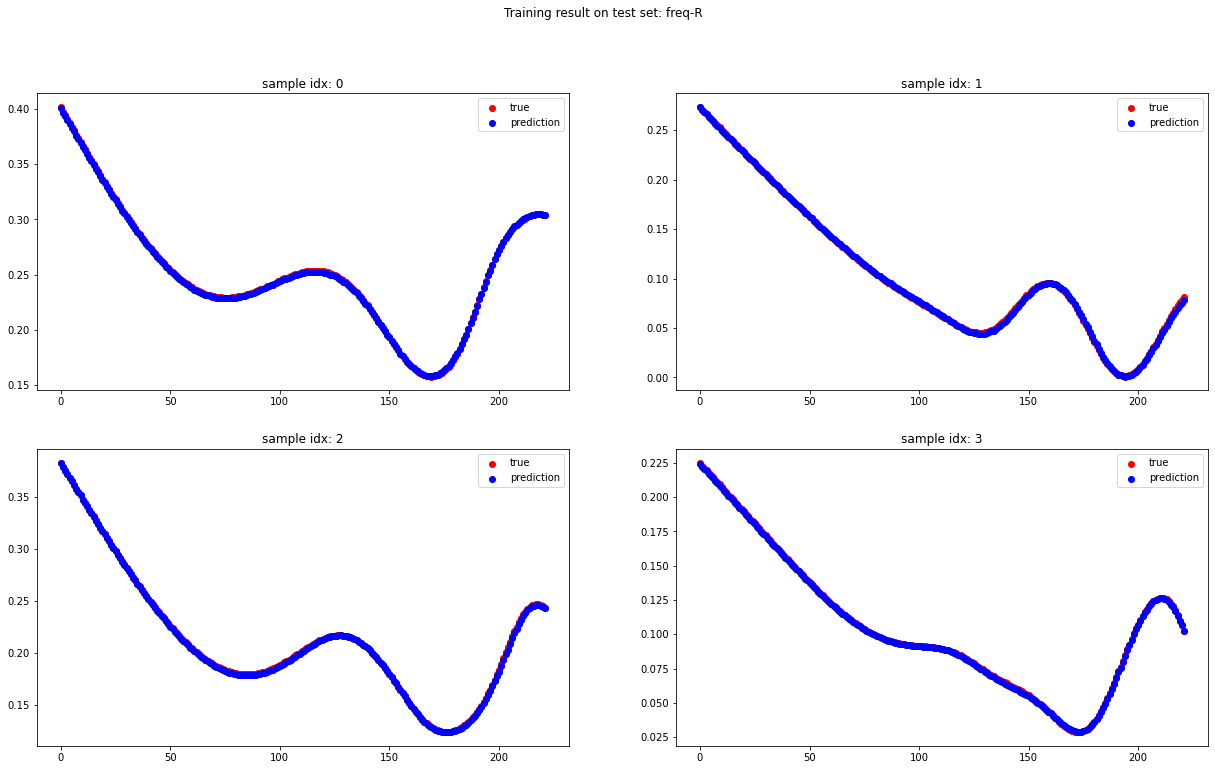

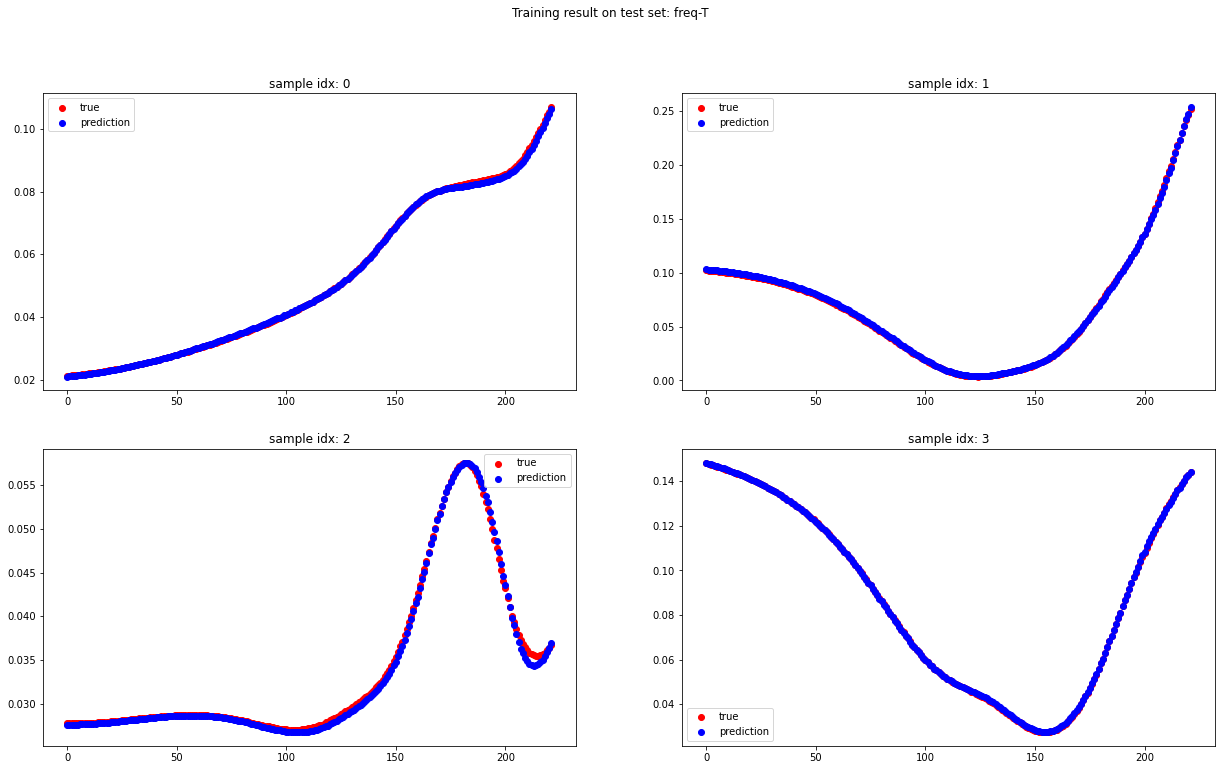

pseudo_params.shape: (10201, 4)
params_pick.shape: (10, 4)
params_pick: [[147. 121. 160.  75.]
 [147. 122. 160.  75.]
 [146. 121. 160.  75.]
 [146. 122. 160.  75.]
 [147. 120. 160.  75.]
 [146. 120. 160.  75.]
 [146. 123. 160.  75.]
 [145. 122. 160.  75.]
 [147. 123. 160.  75.]
 [148. 121. 160.  75.]]
R_pick.shape: (10, 222)
T_pick.shape: (10, 222)


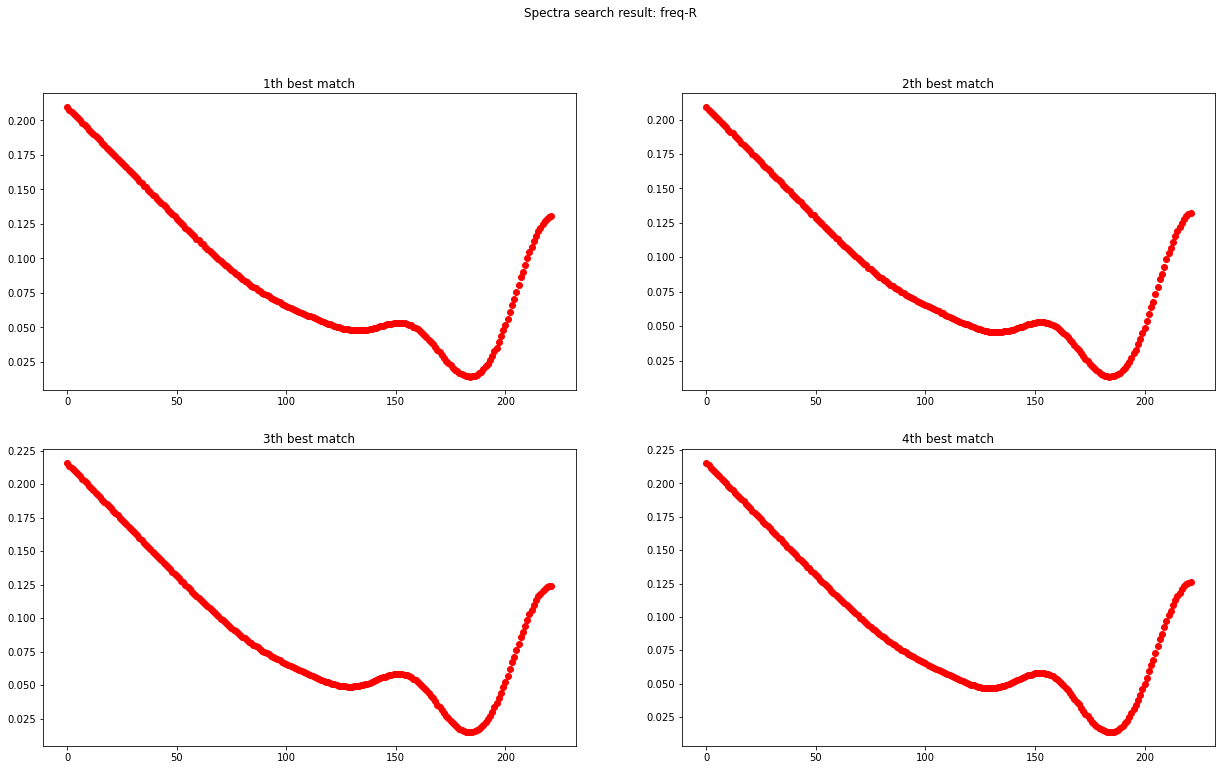

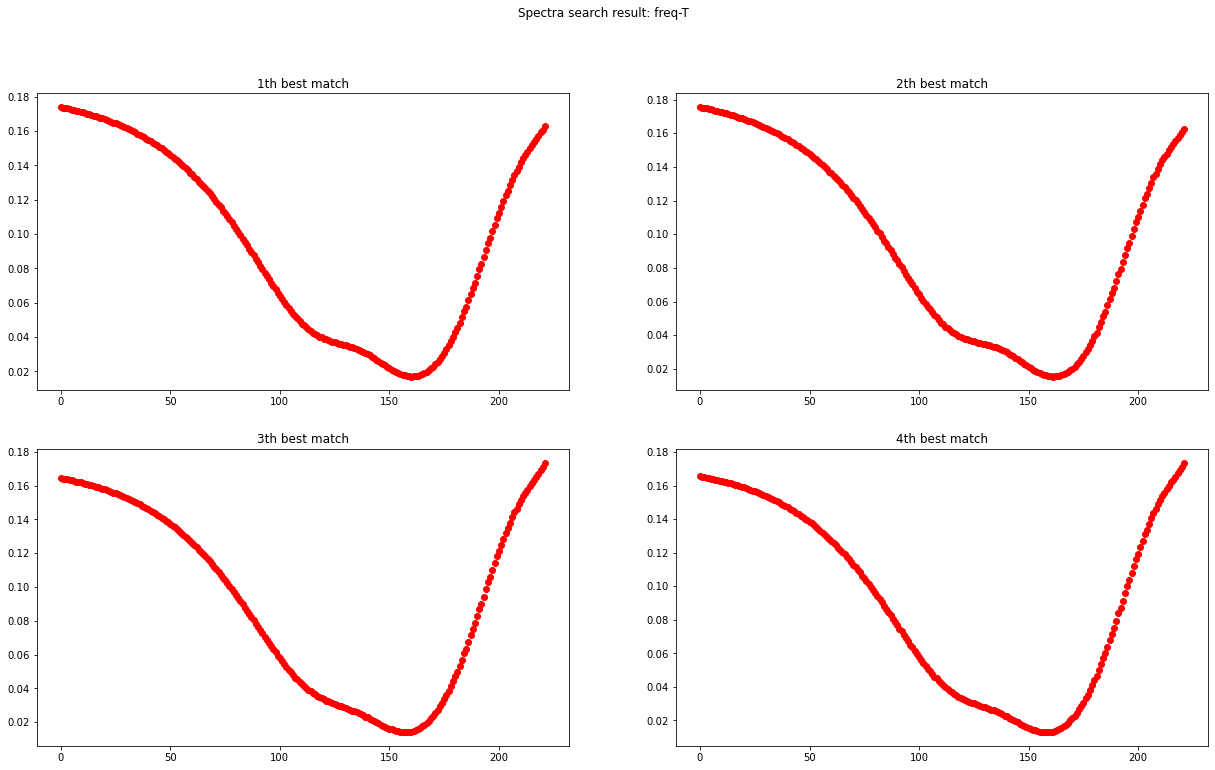

*** Reruning RCWA on picked params
params_dict.shape: (1418, 4)
R_dict.shape: (1418, 222)
T_dict.shape: (1418, 222)
--------------------
1 th match
Already in the dict.
# params_dict: [147. 121. 160.  75.] params_pick: [147. 121. 160.  75.]
--------------------
2 th match
Already in the dict.
# params_dict: [147. 122. 160.  75.] params_pick: [147. 122. 160.  75.]
--------------------
3 th match
Already in the dict.
# params_dict: [146. 121. 160.  75.] params_pick: [146. 121. 160.  75.]
--------------------
4 th match
Already in the dict.
# params_dict: [146. 122. 160.  75.] params_pick: [146. 122. 160.  75.]
--------------------
5 th match
Already in the dict.
# params_dict: [147. 120. 160.  75.] params_pick: [147. 120. 160.  75.]
--------------------
6 th match
Already in the dict.
# params_dict: [146. 120. 160.  75.] params_pick: [146. 120. 160.  75.]
--------------------
7 th match
Already in the dict.
# params_dict: [146. 123. 160.  75.] params_pick: [146. 123. 160.  75.]
---------

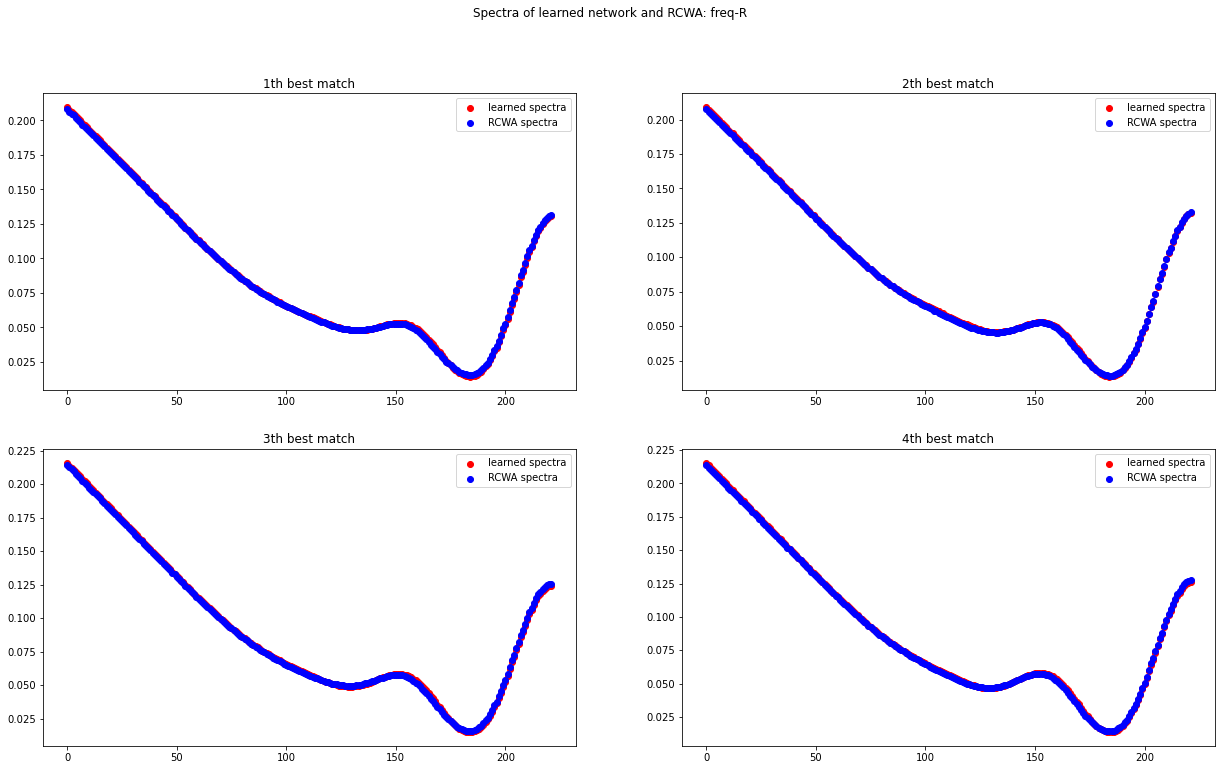

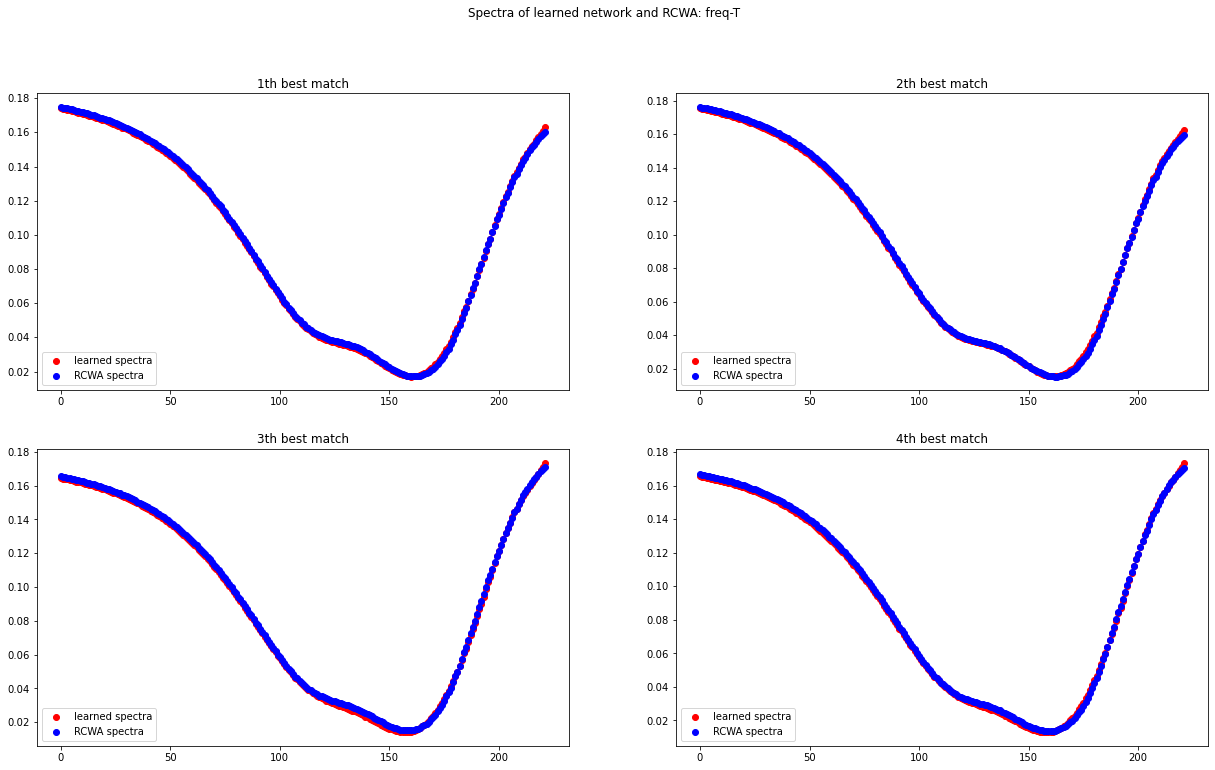

** Model saved.


In [6]:
loss_tolerance = 1e-3
loss = loss_tolerance+1  # start from a loss that bigger than tolerance
ROUND = 1  # round number for simulation and training


# ====== RCWA Simulation Prepare ======
# params range, [D1, D2]
params_range = [[50,150], [50,150]]
params_decimal = [0,0]
path_material_name = 'absorber'

# make data dir if necessary
if not os.path.exists('./data/' + path_material_name + '/'):
    os.makedirs('./data/' + path_material_name + '/')

# solver setting: [freq_step, freq_truncate, params_mesh, PQ_order, source, device]
'''
solver setting should not being changed while sampling and training!
'''
params_mesh = [512, 512]
order = 7  # RCWA accuracy, higher to be more accurate, use 7 for speed
PQ_order = [order, order]
ginc = [0, 0, 1]  # orig [0,0,1], incident source vector, unit vec
EP = [0, 1, 0]  # orig [0,1,0], incident source polarization, unit vec
source = [ginc, EP]
device_rcwa = 'gpu'
freq_step = 4  # freq step size, bigger to save more time, while less sampling freq points
freq_truncate = 1.7  # 'none' to no truncate
solver_setting = [freq_step, freq_truncate, params_mesh, PQ_order, source, device_rcwa]

# ====== Generate Pseudo Params, [D1, D2] ======
range_D1 = [50,151,1]  # [range_start, range_end, step_size]
range_D2 = [50,151,1]
list_range = [range_D1, range_D2]
pseudo_params_D1_D2 = data_utils.generate_pseudo_params(list_range)
a = 160.
t = 75.
param_other = np.array([a, t])
param_other = np.tile(param_other, (pseudo_params_D1_D2.shape[0], 1))
pseudo_params = np.concatenate((pseudo_params_D1_D2, param_other), axis=-1)  # [D1,D2,a,t]

# ====== Define Target Spectra ======
tg_idx_freq_R = np.array([129])
tg_value_R = np.array([0.03])
tg_idx_freq_T = np.array([0, 167])
tg_value_T = np.array([0.228, 0.004])
target_data = [tg_idx_freq_R, tg_value_R, tg_idx_freq_T, tg_value_T]


plt.ion()  # interactive plt while looping
while loss>loss_tolerance:
    print('**************************** ROUND', ROUND, '****************************')
    # ====== Generate Simulation ======
    num_data = 200
    if ROUND==1:
        import_list = False
    else:
        import_list = True
    params, R, T = data_utils.generate_data_absorber(num_data, params_range, params_decimal, solver_setting_list=solver_setting,
                                           path_material_name=path_material_name, import_list=import_list, use_log=True)
    print('params.shape:', params.shape)
    print('R.shape:', R.shape)
    print('T.shape:', T.shape)
    
    # save all data
    path_all_data_round = './data/' + path_material_name + '/all_data_' + path_material_name + '_ROUND_' + str(ROUND) + '.npz'
    np.savez(path_all_data_round, params=params, R=R, T=T)
    print('** Round data saved.')
    
    # generate all data stacked for all rounds
    if ROUND==1:
        params_all = params
        R_all = R
        T_all = T
    else:
        params_all = np.concatenate((params_all, params), axis=0)
        R_all = np.concatenate((R_all, R), axis=0)
        T_all = np.concatenate((T_all, T), axis=0)
    print('params_all.shape:', params_all.shape)
    print('R_all.shape:', R_all.shape)
    print('T_all.shape:', T_all.shape)
    path_all_data = './data/' + path_material_name + '/all_data_' + path_material_name + '.npz'
    np.savez(path_all_data, params=params_all, R=R_all, T=T_all)
    print('** All Rounds data saved.')
    
    
    # ====== Train Model with Simulation Data ======
    # prepare dataset
    dataset, dataloader = data_utils.generate_dataset(path_all_data, idx_pick_param=[], BTSZ=1)
    len_train = int((len(dataset)*0.7)//1)
    len_test = len(dataset)-len_train
    dataset_train, dataset_test = random_split(dataset, [len_train, len_test])
    print('LEN dataset_train:', len(dataset_train))
    print('LEN dataset_test:', len(dataset_test))
    BTSZ = 20
    dataloader_train = DataLoader(dataset_train, batch_size=BTSZ, shuffle=True)
    dataloader_test = DataLoader(dataset_test, batch_size=BTSZ, shuffle=True)
    print('LEN dataloader_train:', len(dataloader_train))
    print('LEN dataloader_test:', len(dataloader_test))
    
    # import network
    if ROUND==1:
        dim_in = params_all.shape[-1]  # N_param
        dim_out = R_all.shape[-1]  # N_freq
        net_dense = DenseConvTranspose1D(dim_in,dim_out)
        net_dense = net_dense.to(device)
    
    # *** train network
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(net_dense.parameters(), lr=learning_rate, weight_decay=0.0, amsgrad=True)
    criteon = nn.MSELoss()
    scheduler = None
    N_epoch = 2000  # number of epochs trained
    loss_train, loss_test = training_utils.train_model(dataloader, dataloader_test, optimizer, criteon, net_dense, device, NUM_EPOCH=N_epoch, scheduler=scheduler)
    print('** loss_train', loss_train)
    print('** loss_test', loss_test)
    
    # visualize spectra on test set
    visualize_trained_net(dataloader_test)
    
    
    # ====== Spectra Search ======
    pseudo_params, spectra_R, spectra_T = data_utils.generate_pseudo_data(pseudo_params, net_dense, device, PATH_pseudo_dataset='', flag_save_pseudo_data=False)
    pseudo_data = [pseudo_params, spectra_R, spectra_T]
    params_pick, R_pick, T_pick, dist_pick = data_utils.spectra_search(pseudo_data, target_data, order=2, N_top=10)
    print('pseudo_params.shape:', pseudo_params.shape)
    print('params_pick.shape:', params_pick.shape)
    print('params_pick:', params_pick)
    print('R_pick.shape:', R_pick.shape)
    print('T_pick.shape:', T_pick.shape)
    # visualize spectra search results
    visualize_spectra_search(params_pick, R_pick, T_pick)
    
    
    # ====== Run RCWA Search on Picked Params ======
    # add param dict check here to save more time
    print('*** Reruning RCWA on picked params')
    if ROUND==1:
        params_dict = params_all
        R_dict = R_all
        T_dict = T_all
    else:
        params_dict = np.concatenate((params_dict, params), axis=0)
        R_dict = np.concatenate((R_dict, R), axis=0)
        T_dict = np.concatenate((T_dict, T), axis=0)
    print('params_dict.shape:', params_dict.shape)
    print('R_dict.shape:', R_dict.shape)
    print('T_dict.shape:', T_dict.shape)
    
    rerun_params, R_simu, T_simu = np.zeros_like(params_pick), np.zeros_like(R_pick), np.zeros_like(T_pick)
    for idx_pick in range(R_pick.shape[0]):  # for each in N_top
        print('--------------------')
        print(idx_pick+1, 'th match')
        if np.any(np.all(params_dict-params_pick[idx_pick]==0, axis=-1)):  # if picked params already in the dict
            print('Already in the dict.')
            idx_same = np.argwhere(np.all(params_dict-params_pick[idx_pick]==0, axis=-1)==True)[0].squeeze()  # get the idx in the dict
            print('# params_dict:', params_dict[idx_same], 'params_pick:', params_pick[idx_pick])
            rerun_params_i, R_simu_i, T_simu_i = params_dict[idx_same][np.newaxis,...], R_dict[idx_same][np.newaxis,...], T_dict[idx_same][np.newaxis,...]
        else:  # picked params not in the dict, call rcwa solver
            print('Not in the dict, calling RCWA...')
            params_pick_rcwa = params_pick[idx_pick][np.newaxis,...]
            print('# params_pick:', params_pick[idx_pick])
            rerun_params_i, R_simu_i, T_simu_i = data_utils.generate_data_absorber(num_data, params_range, params_decimal, solver_setting_list=solver_setting,
                                           path_material_name=path_material_name, import_list=import_list, use_log=True, flag_spectra_search_rerun=True, rerun_params=params_pick_rcwa)
            # add unseen simu data into dict
            params_dict = np.concatenate((params_dict, rerun_params_i), axis=0)
            R_dict = np.concatenate((R_dict, R_simu_i), axis=0)
            T_dict = np.concatenate((T_dict, T_simu_i), axis=0)
        rerun_params[idx_pick], R_simu[idx_pick], T_simu[idx_pick] = rerun_params_i, R_simu_i, T_simu_i
    # save the dict
    path_dict = './data/' + path_material_name + '/data_dict_' + path_material_name + '.npz'
    np.savez(path_dict, params=params_dict, R=R_dict, T=T_dict)
    print('** Dict data saved.')
    # save params_list and update all_params as params_dict (*optional)
#     path_params_list = './data/' + path_material_name + '/params_list_' + path_material_name + '.npz'
#     print('params_dict[..., 0:2].shape:', params_dict[..., 0:2].shape)
#     np.savez(path_params_list, params_list=params_dict[..., 0:2])
#     params_all, R_all, T_all = params_dict, R_dict, T_dict
#     print('params_dict.shape:', params_dict.shape)
    
    # MSE between learned spectra and simulated spectra
    mse_R = ((R_pick - R_simu)**2).mean(axis=-1)  # [N_top]
    mse_T = ((T_pick - T_simu)**2).mean(axis=-1)
    print('* MSE_R for each:', mse_R)
    print('* MSE_T for each:', mse_T)
    print('* MSE_R:', np.average(mse_R))
    print('* MSE_T:', np.average(mse_T))
    sqrt_mse_R = np.average(np.sqrt(mse_R))
    sqrt_mse_T = np.average(np.sqrt(mse_T))
    loss_mse = np.average([sqrt_mse_R, sqrt_mse_T])
    print('* sqrt MSE_R:', sqrt_mse_R)
    print('* sqrt MSE_T:', sqrt_mse_T)
    print('* LOSS_SQRT_MSE:', loss_mse)
    loss = loss_mse

    print('*** Average SQRT MSE Loss between Trained Spectra and RCWA Spectra:', loss_mse)
    # visualize learned spectra and RCWA true spectra
    visualize_learned_and_rcwa(params_pick, R_pick, T_pick, R_simu, T_simu, size_fig=(21,12))
    
    
    # ====== Save Trained Model ======
    # make data dir if necessary
    if not os.path.exists('./trained_models/' + path_material_name + '/'):
        os.makedirs('./trained_models/' + path_material_name + '/')
    PATH_MODEL = './trained_models/' + path_material_name + '/autoRCWA_DenseConvTranspose1D_EPOCH_' + str(ROUND) + '.pt'
    torch.save(net_dense.state_dict(), PATH_MODEL)
    print('** Model saved.')
    
    ROUND += 1
    
plt.ioff()

In [13]:
a = np.array([[1,2,3],[4,5,6]])
b = np.array([[5,2,3],[4,18,6]])
loss_np = np.linalg.norm(a-b, ord=2, axis=-1)
print('loss_np l2 norm:', loss_np)

mse = ((a-b)**2).mean(axis=-1)
print('mse:', mse)

mse = ((a-b)**2).mean(axis=-1)
print('mse:', np.average(np.sqrt(mse)))

mse = np.sqrt(((a-b)**2).mean(axis=-1)).mean()
print('mse:', mse)

loss_np l2 norm: [ 4. 13.]
mse: [ 5.33333333 56.33333333]
mse: 4.907477288111819
mse: 4.907477288111819


## Save Trained Model

In [ ]:
PATH_MODEL = './trained_models/autoRCWA_DenseConvTranspose1D_EPOCH_' + str(ROUND) + '.pt'
torch.save(net_dense.state_dict(), PATH_MODEL)
print('Model saved.')